- OpenClassrooms Project 7, Data Scientist
- Author : Oumeima EL GHARBI
- Date : November and December 2022, January and February 2023

### Importing libraries

In [1]:
#%reset -f

import warnings

import joblib

warnings.filterwarnings(action="ignore")

# to compute time of pipeline
from time import time, strftime, gmtime

from evaluation_metrics import *
from model_train_functions import *

%matplotlib inline
%autosave 300

Autosaving every 300 seconds


In [2]:
import sys
print("Python version {}.{}.{}".format(str(sys.version_info[0]), str(sys.version_info[1]), str(sys.version_info[2])))

Python version 3.10.9


In [3]:
# Create local directories to save data
os.makedirs("dataset/cleaned", exist_ok=True)

In [4]:
global seed
seed = 42

In [5]:
# Starting time
t0 = time()

input_path = "dataset/cleaned/"
output_path = "dataset/cleaned/"

## Part I : Preparing vectors
Feature engineering
Train / test split
Train and val in Folds

#### 1) Feature engineering

**The feature engineering is done by running the script feature_engineering.py, this notebook's purpose is to make a train and validation set and train models**

It takes around 5 minutes to generate the preprocessed training dataset. The cell below is deactivated since the file is saved locally.

import subprocess

print("__Generate train set__")
subprocess.call(r'python feature_engineering.py', shell=True)

After running the script **feature_engineering.py**, we create a train and validation set.

In [6]:
data = pd.read_csv(input_path + "data_train_preprocessed_vf.csv", index_col="SK_ID_CURR")
data = data.replace([np.inf, -np.inf], np.nan) # inplace = True
data = data.fillna(value=data.mean())
count = np.isinf(data).values.sum()
print("It contains " + str(count) + " infinite values")

data.to_csv("{}{}".format(output_path, "data_train_preprocessed_cleaned.csv"), encoding='utf-8', index_label="SK_ID_CURR")
print(data.shape)

It contains 0 infinite values
(307507, 778)


In [7]:
data[data.TARGET.isna()]

Empty DataFrame
Columns: [TARGET, CODE_GENDER, FLAG_OWN_CAR, FLAG_OWN_REALTY, CNT_CHILDREN, AMT_INCOME_TOTAL, AMT_CREDIT, AMT_ANNUITY, AMT_GOODS_PRICE, REGION_POPULATION_RELATIVE, DAYS_BIRTH, DAYS_EMPLOYED, DAYS_REGISTRATION, DAYS_ID_PUBLISH, OWN_CAR_AGE, FLAG_MOBIL, FLAG_EMP_PHONE, FLAG_WORK_PHONE, FLAG_CONT_MOBILE, FLAG_PHONE, FLAG_EMAIL, CNT_FAM_MEMBERS, REGION_RATING_CLIENT, REGION_RATING_CLIENT_W_CITY, HOUR_APPR_PROCESS_START, REG_REGION_NOT_LIVE_REGION, REG_REGION_NOT_WORK_REGION, LIVE_REGION_NOT_WORK_REGION, REG_CITY_NOT_LIVE_CITY, REG_CITY_NOT_WORK_CITY, LIVE_CITY_NOT_WORK_CITY, EXT_SOURCE_1, EXT_SOURCE_2, EXT_SOURCE_3, APARTMENTS_AVG, BASEMENTAREA_AVG, YEARS_BEGINEXPLUATATION_AVG, YEARS_BUILD_AVG, COMMONAREA_AVG, ELEVATORS_AVG, ENTRANCES_AVG, FLOORSMAX_AVG, FLOORSMIN_AVG, LANDAREA_AVG, LIVINGAPARTMENTS_AVG, LIVINGAREA_AVG, NONLIVINGAPARTMENTS_AVG, NONLIVINGAREA_AVG, APARTMENTS_MODE, BASEMENTAREA_MODE, YEARS_BEGINEXPLUATATION_MODE, YEARS_BUILD_MODE, COMMONAREA_MODE, ELEVATORS_MODE, ENTRANCES_MODE, FLOORSMAX_MODE, FLOORSMIN_MODE, LANDAREA_MODE, LIVINGAPARTMENTS_MODE, LIVINGAREA_MODE, NONLIVINGAPARTMENTS_MODE, NONLIVINGAREA_MODE, APARTMENTS_MEDI, BASEMENTAREA_MEDI, YEARS_BEGINEXPLUATATION_MEDI, YEARS_BUILD_MEDI, COMMONAREA_MEDI, ELEVATORS_MEDI, ENTRANCES_MEDI, FLOORSMAX_MEDI, FLOORSMIN_MEDI, LANDAREA_MEDI, LIVINGAPARTMENTS_MEDI, LIVINGAREA_MEDI, NONLIVINGAPARTMENTS_MEDI, NONLIVINGAREA_MEDI, TOTALAREA_MODE, OBS_30_CNT_SOCIAL_CIRCLE, DEF_30_CNT_SOCIAL_CIRCLE, OBS_60_CNT_SOCIAL_CIRCLE, DEF_60_CNT_SOCIAL_CIRCLE, DAYS_LAST_PHONE_CHANGE, FLAG_DOCUMENT_2, FLAG_DOCUMENT_3, FLAG_DOCUMENT_4, FLAG_DOCUMENT_5, FLAG_DOCUMENT_6, FLAG_DOCUMENT_7, FLAG_DOCUMENT_8, FLAG_DOCUMENT_9, FLAG_DOCUMENT_10, FLAG_DOCUMENT_11, FLAG_DOCUMENT_12, FLAG_DOCUMENT_13, FLAG_DOCUMENT_14, FLAG_DOCUMENT_15, FLAG_DOCUMENT_16, FLAG_DOCUMENT_17, FLAG_DOCUMENT_18, FLAG_DOCUMENT_19, ...]
Index: []

[0 rows x 778 columns]

In [8]:
data.isna().sum(axis=0)

TARGET                                 0
CODE_GENDER                            0
FLAG_OWN_CAR                           0
FLAG_OWN_REALTY                        0
CNT_CHILDREN                           0
                                      ..
CC_NAME_CONTRACT_STATUS_Signed_MAX     0
CC_NAME_CONTRACT_STATUS_Signed_MEAN    0
CC_NAME_CONTRACT_STATUS_Signed_SUM     0
CC_NAME_CONTRACT_STATUS_Signed_VAR     0
CC_COUNT                               0
Length: 778, dtype: int64

#### 2) Train / test split

In [9]:
# We create a training set and a test set (the test set contains 30% of the dataset)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)
train, test = train_test_split(data, test_size=0.3, random_state=seed)

In [10]:
#data.select_dtypes('object') # we don't have 'object' here but it is just in case.

In [11]:
categorical_columns = data.select_dtypes('object').columns
numerical_columns = data.select_dtypes(include='number').columns
#numerical_columns = X.select_dtypes(include='number').columns

print("Shape of categorical variables : ", categorical_columns.shape)
print("Shape of numerical variables :", numerical_columns.shape)

Shape of categorical variables :  (0,)
Shape of numerical variables : (778,)


In [12]:
# Saving dataset
train.to_csv("{}{}".format(output_path, "train.csv"), encoding='utf-8', index_label="SK_ID_CURR")
test.to_csv("{}{}".format(output_path, "test.csv"), encoding='utf-8', index_label="SK_ID_CURR")

## Part II : Prediction

#### Loading dataset

In [13]:
#data = pd.read_csv(input_path + "data_train_preprocessed_cleaned.csv", index_col="SK_ID_CURR")
#print(data.shape)

train_file = input_path + "train.csv"
test_file = input_path + "test.csv"

train = pd.read_csv(train_file, sep=",", index_col="SK_ID_CURR")
test = pd.read_csv(test_file, sep=",", index_col="SK_ID_CURR")

print(train.shape)
print(test.shape)

target = "TARGET"
# all rows, not target and removes SK_ID_CURR the PK
features = [f for f in data.columns if f not in ['TARGET','SK_ID_CURR']] # ,'SK_ID_BUREAU','SK_ID_PREV','index' / deleted

(215254, 778)
(92253, 778)


##### Separating X and y vectors for training

In [14]:
X = train[features]

#X = X.replace([np.inf, -np.inf], np.nan) # inplace = True
#X = X.fillna(value=X.mean())

print(X.isna().sum(axis=0))
count = np.isinf(X).values.sum()
print("It contains " + str(count) + " infinite values")

X.to_csv("{}{}".format(output_path, "X.csv"), encoding='utf-8', index_label="SK_ID_CURR")

CODE_GENDER                            0
FLAG_OWN_CAR                           0
FLAG_OWN_REALTY                        0
CNT_CHILDREN                           0
AMT_INCOME_TOTAL                       0
                                      ..
CC_NAME_CONTRACT_STATUS_Signed_MAX     0
CC_NAME_CONTRACT_STATUS_Signed_MEAN    0
CC_NAME_CONTRACT_STATUS_Signed_SUM     0
CC_NAME_CONTRACT_STATUS_Signed_VAR     0
CC_COUNT                               0
Length: 777, dtype: int64
It contains 0 infinite values


In [15]:
X = pd.read_csv(input_path + "X.csv", sep=",", index_col="SK_ID_CURR")
y = train[target]

In [16]:
print("The shape of the X matrix :", X.shape, "and this is the shape of the target vector :", y.shape)

The shape of the X matrix : (215254, 777) and this is the shape of the target vector : (215254,)


##### Preparing X_train, X_test, y_train and y_test

In [17]:
#X_train = train.loc[:, train.columns != 'TARGET'].iloc[:, 1:]
#X_val = val.loc[:, val.columns != 'TARGET'].iloc[:, 1:] # all rows, not target and removes SK_ID_CURR the PK

# all rows, not target and removes SK_ID_CURR the PK
#X_train = train[features]
X_test = test[features]

#y_train = train[target]
y_test = test[target]

In [18]:
print("The shape of the training matrix :", X.shape, "and this is the shape of the target vector :", y.shape)
print("The shape of the test matrix :", X_test.shape, "and this is the shape of the target vector :", y_test.shape)

The shape of the training matrix : (215254, 777) and this is the shape of the target vector : (215254,)
The shape of the test matrix : (92253, 777) and this is the shape of the target vector : (92253,)


### 2) Training models

#### Baseline : DummyClassifier

Fitting classifier on X_train and y_train
Saving model with joblib
Predicting
Evaluating
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     84811
           1       0.00      0.00      0.00      7442

    accuracy                           0.92     92253
   macro avg       0.46      0.50      0.48     92253
weighted avg       0.85      0.92      0.88     92253

ROC-AUC 0.5


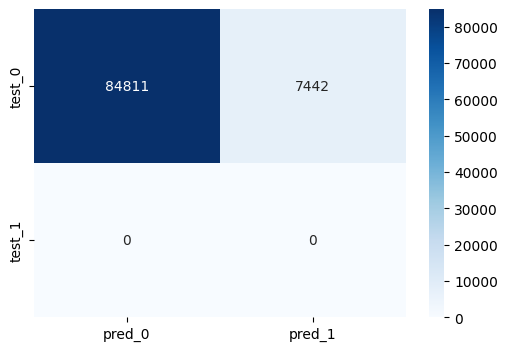

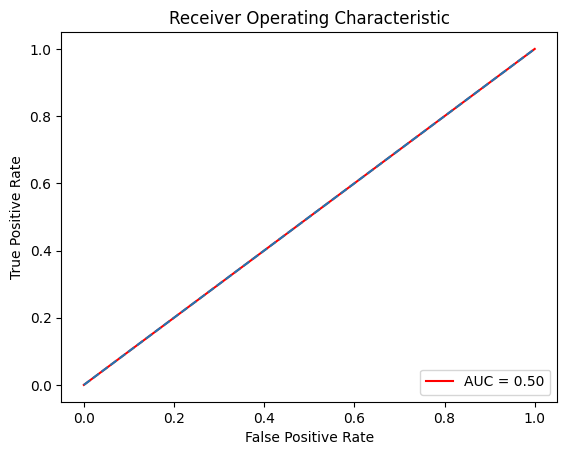

Updating the results dataframe
Prediction for :  TARGET


___Model___  __ROC-AUC__  __F-score Beta = 2__  __Recall__  Precision  \
0       Dummy          0.5                   0.0         0.0        0.0   

   F1-score  F1-score weighted  Accuracy  
0       0.0              0.881     0.919

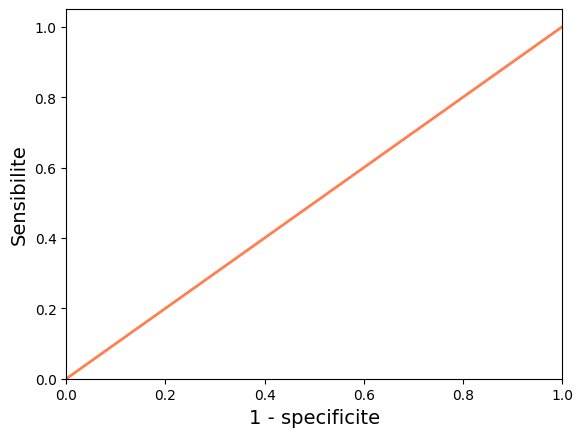

In [19]:
from sklearn.dummy import DummyClassifier
dummy_clf = DummyClassifier(strategy="most_frequent")

print("Fitting classifier on X_train and y_train")
dummy_clf.fit(X, y)

# save the model to disk
print("Saving model with joblib")
filename_joblib = 'models/{}.joblib'.format("Dummy")
joblib.dump(dummy_clf, filename_joblib)

print("Predicting")
y_pred = dummy_clf.predict(X_test)

print("Evaluating")
evaluate_classification(y_test, y_pred, y_pred_proba=y_pred)

print("Updating the results dataframe")
results = evaluate_models("Dummy", results, y_test, y_pred)

#### Logistic Regression

##### Standardisation

In [23]:
count = np.isinf(X).values.sum()
print("It contains " + str(count) + " infinite values")

It contains 0 infinite values


In [56]:
tmp = X.nunique() == 2

columns_NOT_to_std = []
columns_to_std = []

for col in tmp.index.tolist():
    if tmp[tmp.index == col][0]: # if True means 2 values
        if X[col].min() == 0 and X[col].max() == 1:
            columns_NOT_to_std.append(col)

columns_to_std = [col for col in X.columns.tolist() if col not in columns_NOT_to_std]


In [57]:
print(len(columns_to_std))
print(len(columns_NOT_to_std))

603
174


In [58]:
std_scaler = StandardScaler().fit(X[columns_to_std])
# We transform the training set and the testing set / Performs standardization by centering and scaling.
X_std, X_test_std = X.copy(), X_test.copy()

X_std[columns_to_std] = std_scaler.transform(X_std[columns_to_std])
X_test_std[columns_to_std] = std_scaler.transform(X_test_std[columns_to_std])

print("Before")
display(X.head())
print("After")
display(X_std.head())

Before


CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  CNT_CHILDREN  \
SK_ID_CURR                                                             
343662                0             1                1             0   
399013                0             1                1             0   
277383                0             0                0             2   
285198                1             1                0             2   
415660                1             1                1             0   

            AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
SK_ID_CURR                                                               
343662              225000.0   1800000.0      62568.0        1800000.0   
399013              180000.0   1494486.0      39555.0        1305000.0   
277383              135000.0    755190.0      38686.5         675000.0   
285198               90000.0    254700.0      17149.5         225000.0   
415660              247500.0   1350000.0      72058.5        1350000.0   

            REGION_POPULATION_RELATIVE  DAYS_BIRTH  ...  \
SK_ID_CURR                                          ...   
343662                        0.019101      -14339  ...   
399013                        0.035792      -10965  ...   
277383                        0.006852      -12831  ...   
285198                        0.020713      -11222  ...   
415660                        0.028663      -20195  ...   

            CC_NAME_CONTRACT_STATUS_Sent proposal_MAX  \
SK_ID_CURR                                              
343662                                       0.005293   
399013                                       0.005293   
277383                                       0.005293   
285198                                       0.000000   
415660                                       0.005293   

            CC_NAME_CONTRACT_STATUS_Sent proposal_MEAN  \
SK_ID_CURR                                               
343662                                        0.000064   
399013                                        0.000064   
277383                                        0.000064   
285198                                        0.000000   
415660                                        0.000064   

            CC_NAME_CONTRACT_STATUS_Sent proposal_SUM  \
SK_ID_CURR                                              
343662                                       0.005293   
399013                                       0.005293   
277383                                       0.005293   
285198                                       0.000000   
415660                                       0.005293   

            CC_NAME_CONTRACT_STATUS_Sent proposal_VAR  \
SK_ID_CURR                                              
343662                                       0.000064   
399013                                       0.000064   
277383                                       0.000064   
285198                                       0.000000   
415660                                       0.000064   

            CC_NAME_CONTRACT_STATUS_Signed_MIN  \
SK_ID_CURR                                       
343662                                0.000368   
399013                                0.000368   
277383                                0.000368   
285198                                0.000000   
415660                                0.000368   

            CC_NAME_CONTRACT_STATUS_Signed_MAX  \
SK_ID_CURR                                       
343662                                0.049376   
399013                                0.049376   
277383                                0.049376   
285198                                0.000000   
415660                                0.049376   

            CC_NAME_CONTRACT_STATUS_Signed_MEAN  \
SK_ID_CURR                                        
343662                                 0.003738   
399013                                 0.003738   
277383                                 0.003738   
285198    

After


CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  CNT_CHILDREN  \
SK_ID_CURR                                                             
343662                0             1                1     -0.577285   
399013                0             1                1     -0.577285   
277383                0             0                0      2.194029   
285198                1             1                0      2.194029   
415660                1             1                1     -0.577285   

            AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
SK_ID_CURR                                                               
343662              0.524737    2.973913     2.440516         3.405485   
399013              0.105965    2.217063     0.856014         2.068824   
277383             -0.312807    0.385603     0.796216         0.367619   
285198             -0.731580   -0.854262    -0.686660        -0.847528   
415660              0.734123    1.859127     3.093961         2.190338   

            REGION_POPULATION_RELATIVE  DAYS_BIRTH  ...  \
SK_ID_CURR                                          ...   
343662                       -0.126849    0.387961  ...   
399013                        1.080881    1.161194  ...   
277383                       -1.013164    0.733555  ...   
285198                       -0.010208    1.102296  ...   
415660                        0.565040   -0.954080  ...   

            CC_NAME_CONTRACT_STATUS_Sent proposal_MAX  \
SK_ID_CURR                                              
343662                                      -0.001366   
399013                                      -0.001366   
277383                                      -0.001366   
285198                                      -0.136109   
415660                                      -0.001366   

            CC_NAME_CONTRACT_STATUS_Sent proposal_MEAN  \
SK_ID_CURR                                               
343662                                       -0.001507   
399013                                       -0.001507   
277383                                       -0.001507   
285198                                       -0.134560   
415660                                       -0.001507   

            CC_NAME_CONTRACT_STATUS_Sent proposal_SUM  \
SK_ID_CURR                                              
343662                                      -0.001366   
399013                                      -0.001366   
277383                                      -0.001366   
285198                                      -0.136109   
415660                                      -0.001366   

            CC_NAME_CONTRACT_STATUS_Sent proposal_VAR  \
SK_ID_CURR                                              
343662                                      -0.001502   
399013                                      -0.001502   
277383                                      -0.001502   
285198                                      -0.135532   
415660                                      -0.001502   

            CC_NAME_CONTRACT_STATUS_Signed_MIN  \
SK_ID_CURR                                       
343662                                0.000198   
399013                                0.000198   
277383                                0.000198   
285198                               -0.036231   
415660                                0.000198   

            CC_NAME_CONTRACT_STATUS_Signed_MAX  \
SK_ID_CURR                                       
343662                                0.001783   
399013                                0.001783   
277383                                0.001783   
285198                               -0.429617   
415660                                0.001783   

            CC_NAME_CONTRACT_STATUS_Signed_MEAN  \
SK_ID_CURR                                        
343662                                 0.000744   
399013                                 0.000744   
277383                                 0.000744   
285198    

##### 1) Using GridSearchCV to get the best hyper-parameters

log_reg = LogisticRegression(class_weight='balanced', max_iter=1000, )
param_grid = {'C':[0.001, 0.01, 0.1, 1, 10, 100, 1000]}
score, params = make_grisearch(log_reg, X_std, y, param_grid=param_grid)
print(score, params)

##### 2) Training model based on Cross-Validation

In [62]:
log_reg_best_params = LogisticRegression(class_weight='balanced', max_iter=1000, C=1)

scores = evaluate(log_reg_best_params, 'log_reg', X_std, y, k_fold=5, beta=2)
#display(scores)

Starting time
Iteration :  0
Starting fit and predict
Saving model with joblib
Iteration :  1
Starting fit and predict
Saving model with joblib
Iteration :  2
Starting fit and predict
Saving model with joblib
Iteration :  3
Starting fit and predict
Saving model with joblib
Iteration :  4
Starting fit and predict
Saving model with joblib
Computing time : 685.3930673599243 seconds


Loading Logistic Regression
              precision    recall  f1-score   support

           0       0.88      0.09      0.16     84811
           1       0.08      0.87      0.14      7442

    accuracy                           0.15     92253
   macro avg       0.48      0.48      0.15     92253
weighted avg       0.82      0.15      0.15     92253

ROC-AUC 0.479


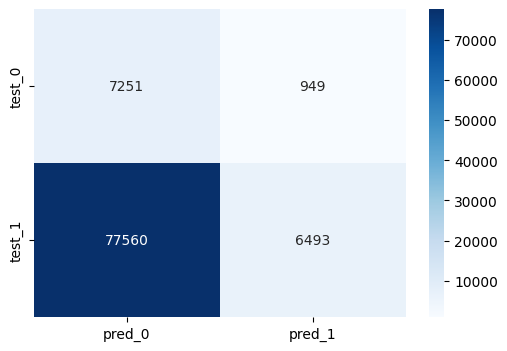

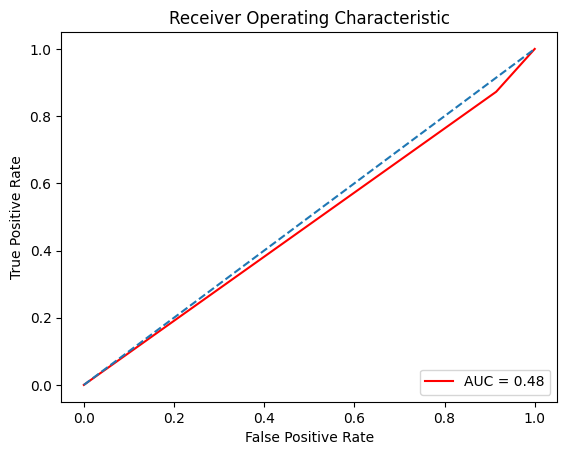

Prediction for :  TARGET


___Model___  __ROC-AUC__  __F-score Beta = 2__  __Recall__  Precision  \
0       Dummy        0.500                 0.000       0.000      0.000   
0   log_reg_0        0.479                 0.285       0.872      0.077   

   F1-score  F1-score weighted  Accuracy  
0     0.000              0.881     0.919  
0     0.142              0.155     0.149

Loading Logistic Regression
              precision    recall  f1-score   support

           0       0.84      0.02      0.03     84811
           1       0.08      0.96      0.15      7442

    accuracy                           0.09     92253
   macro avg       0.46      0.49      0.09     92253
weighted avg       0.78      0.09      0.04     92253

ROC-AUC 0.489


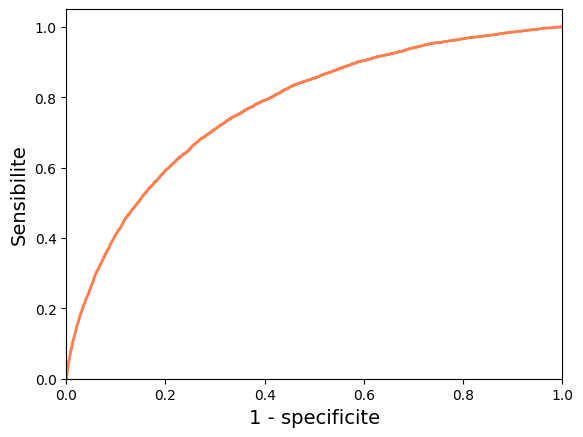

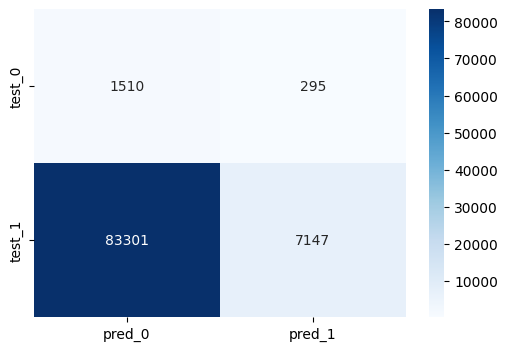

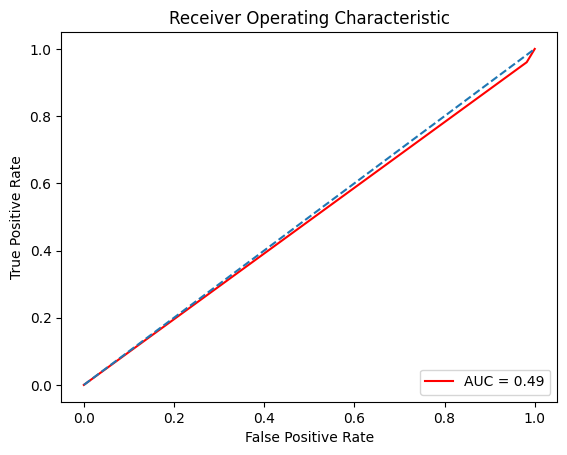

Prediction for :  TARGET


___Model___  __ROC-AUC__  __F-score Beta = 2__  __Recall__  Precision  \
0       Dummy        0.500                 0.000       0.000      0.000   
0   log_reg_1        0.489                 0.297       0.960      0.079   
0   log_reg_0        0.479                 0.285       0.872      0.077   

   F1-score  F1-score weighted  Accuracy  
0     0.000              0.881     0.919  
0     0.146              0.044     0.094  
0     0.142              0.155     0.149

Loading Logistic Regression
              precision    recall  f1-score   support

           0       0.84      0.01      0.03     84811
           1       0.08      0.97      0.15      7442

    accuracy                           0.09     92253
   macro avg       0.46      0.49      0.09     92253
weighted avg       0.78      0.09      0.04     92253

ROC-AUC 0.493


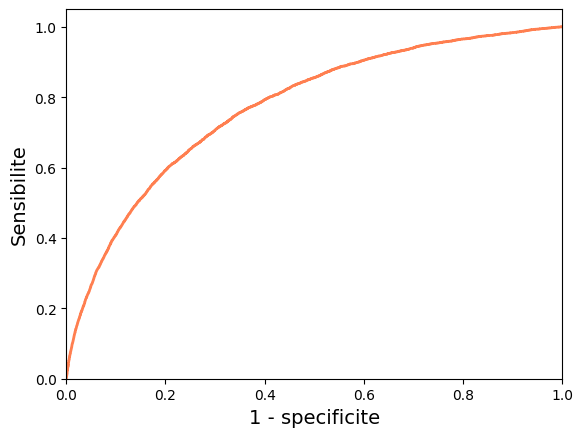

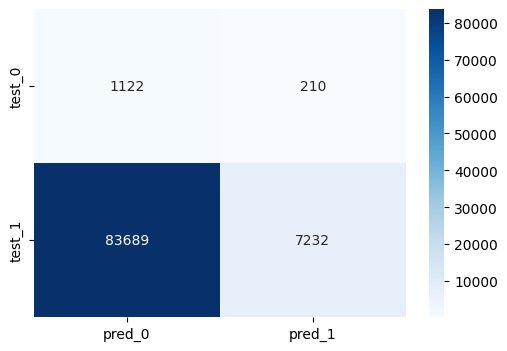

Prediction for :  TARGET


___Model___  __ROC-AUC__  __F-score Beta = 2__  __Recall__  Precision  \
0       Dummy        0.500                 0.000       0.000      0.000   
0   log_reg_2        0.493                 0.300       0.972      0.080   
0   log_reg_1        0.489                 0.297       0.960      0.079   
0   log_reg_0        0.479                 0.285       0.872      0.077   

   F1-score  F1-score weighted  Accuracy  
0     0.000              0.881     0.919  
0     0.147              0.036     0.091  
0     0.146              0.044     0.094  
0     0.142              0.155     0.149

Loading Logistic Regression
              precision    recall  f1-score   support

           0       0.82      0.01      0.02     84811
           1       0.08      0.98      0.15      7442

    accuracy                           0.09     92253
   macro avg       0.45      0.49      0.08     92253
weighted avg       0.76      0.09      0.03     92253

ROC-AUC 0.494


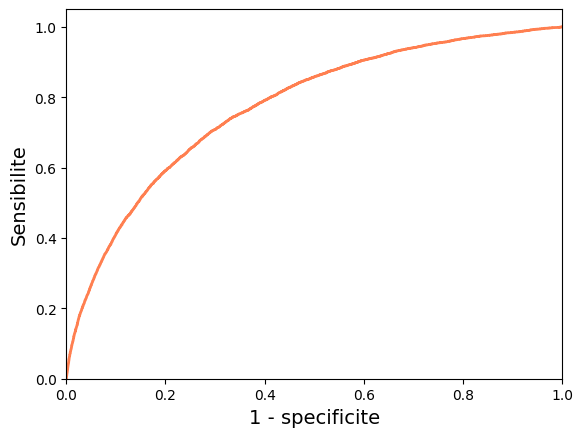

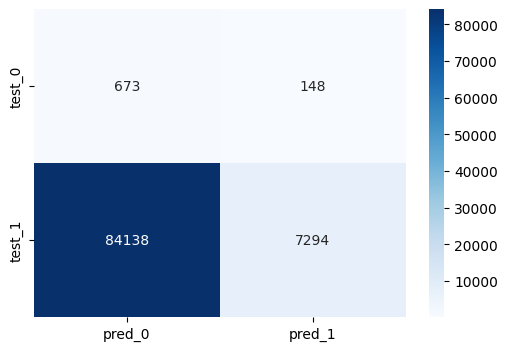

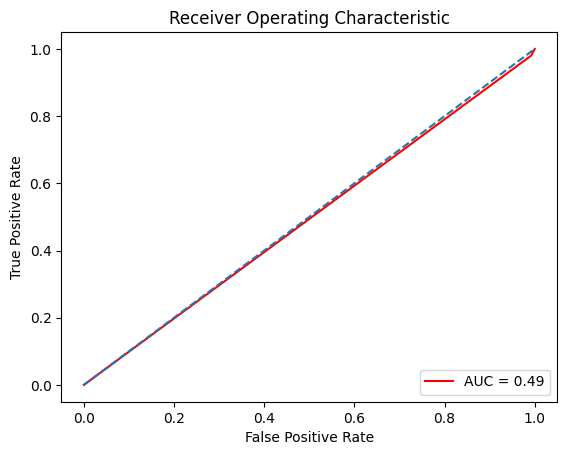

Prediction for :  TARGET


___Model___  __ROC-AUC__  __F-score Beta = 2__  __Recall__  Precision  \
0       Dummy        0.500                 0.000       0.000      0.000   
0   log_reg_3        0.494                 0.301       0.980      0.080   
0   log_reg_2        0.493                 0.300       0.972      0.080   
0   log_reg_1        0.489                 0.297       0.960      0.079   
0   log_reg_0        0.479                 0.285       0.872      0.077   

   F1-score  F1-score weighted  Accuracy  
0     0.000              0.881     0.919  
0     0.148              0.026     0.086  
0     0.147              0.036     0.091  
0     0.146              0.044     0.094  
0     0.142              0.155     0.149

Loading Logistic Regression
              precision    recall  f1-score   support

           0       0.88      0.07      0.13     84811
           1       0.08      0.89      0.14      7442

    accuracy                           0.13     92253
   macro avg       0.48      0.48      0.13     92253
weighted avg       0.82      0.13      0.13     92253

ROC-AUC 0.481


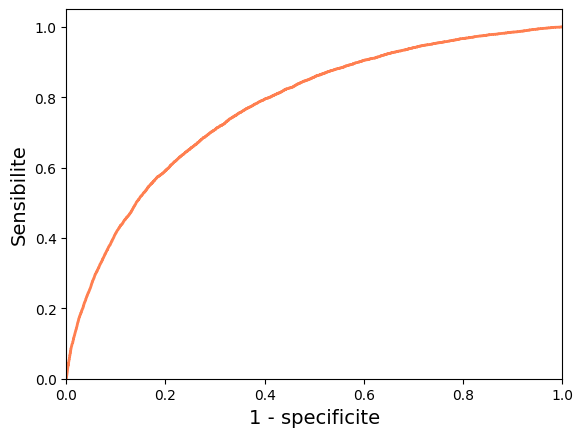

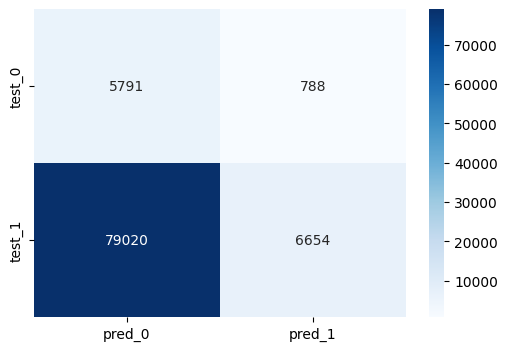

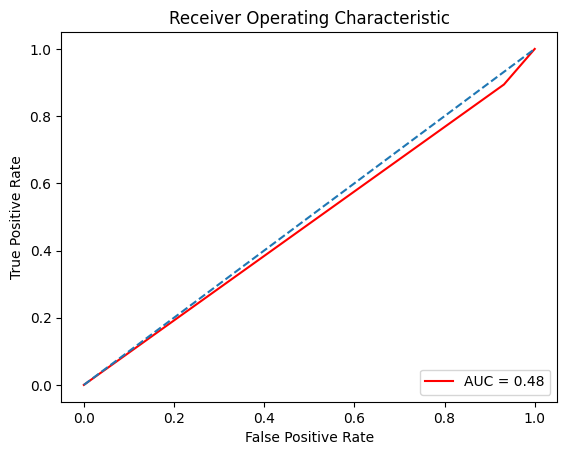

Prediction for :  TARGET


___Model___  __ROC-AUC__  __F-score Beta = 2__  __Recall__  Precision  \
0       Dummy        0.500                 0.000       0.000      0.000   
0   log_reg_3        0.494                 0.301       0.980      0.080   
0   log_reg_2        0.493                 0.300       0.972      0.080   
0   log_reg_1        0.489                 0.297       0.960      0.079   
0   log_reg_4        0.481                 0.288       0.894      0.078   
0   log_reg_0        0.479                 0.285       0.872      0.077   

   F1-score  F1-score weighted  Accuracy  
0     0.000              0.881     0.919  
0     0.148              0.026     0.086  
0     0.147              0.036     0.091  
0     0.146              0.044     0.094  
0     0.143              0.128     0.135  
0     0.142              0.155     0.149

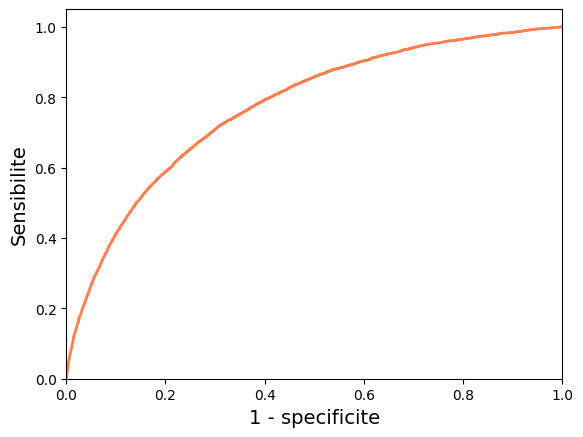

In [63]:
for i in range(5):
    # load model
    print("Loading Logistic Regression")
    clf = joblib.load('models/log_reg/log_reg_fold_{}.joblib'.format(i))

    y_pred = clf.predict(X_test)
    y_pred_proba = clf.predict_proba(X_test_std)[:, 1] # we take the prediction for the class 1
    evaluate_classification(y_test, y_pred, y_pred_proba=y_pred_proba)
    results = evaluate_models("log_reg_{}".format(i), results, y_test, y_pred)

##### 3) Training model based on Cross-Validation and SMOTE

print("Searching for best hyper-parameters using SMOTE")

log_reg_smote = LogisticRegression(class_weight='balanced', max_iter=1000,)
param_grid = {'classifier__C':[0.001, 0.01, 0.1, 1, 10, 100]}

score, params = make_grisearch_smote(log_reg_smote, X_std, y, param_grid=param_grid)
print(score, params)

In [64]:
log_reg_smote_best_params = LogisticRegression(class_weight='balanced', max_iter=1000, C=0.01)
scores = evaluate(log_reg_smote_best_params, 'log_reg_SMOTE', X_std, y, k_fold=5, beta=2,apply_smote=True,
                      smote_params={'k_neighbors':100, 'sampling_strategy':0.5})
#display(scores)

Starting time
Iteration :  0
Starting fit and predict
Saving model with joblib
Iteration :  1
Starting fit and predict
Saving model with joblib
Iteration :  2
Starting fit and predict
Saving model with joblib
Iteration :  3
Starting fit and predict
Saving model with joblib
Iteration :  4
Starting fit and predict
Saving model with joblib
Computing time : 512.8488202095032 seconds


Loading Logistic Regression SMOTE
              precision    recall  f1-score   support

           0       0.87      0.03      0.06     84811
           1       0.08      0.94      0.15      7442

    accuracy                           0.11     92253
   macro avg       0.47      0.49      0.11     92253
weighted avg       0.81      0.11      0.07     92253

ROC-AUC 0.488


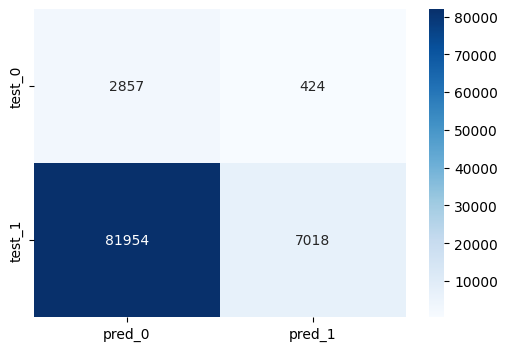

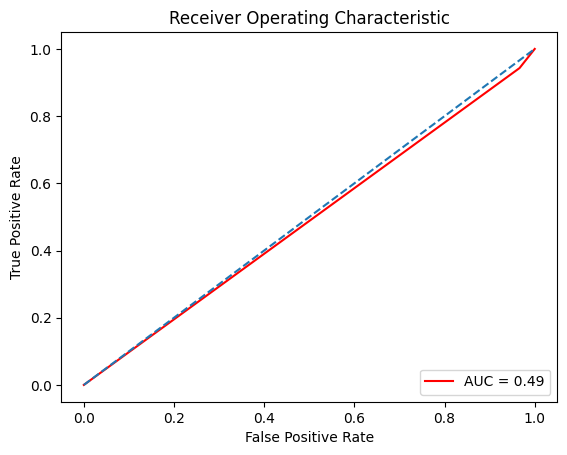

Prediction for :  TARGET


___Model___  __ROC-AUC__  __F-score Beta = 2__  __Recall__  Precision  \
0            Dummy        0.500                 0.000       0.000      0.000   
0        log_reg_3        0.494                 0.301       0.980      0.080   
0        log_reg_2        0.493                 0.300       0.972      0.080   
0        log_reg_1        0.489                 0.297       0.960      0.079   
0  log_reg_SMOTE_0        0.488                 0.296       0.943      0.079   
0        log_reg_4        0.481                 0.288       0.894      0.078   
0        log_reg_0        0.479                 0.285       0.872      0.077   

   F1-score  F1-score weighted  Accuracy  
0     0.000              0.881     0.919  
0     0.148              0.026     0.086  
0     0.147              0.036     0.091  
0     0.146              0.044     0.094  
0     0.146              0.071     0.107  
0     0.143              0.128     0.135  
0     0.142              0.155     0.149

Loading Logistic Regression SMOTE
              precision    recall  f1-score   support

           0       0.84      0.01      0.02     84811
           1       0.08      0.98      0.15      7442

    accuracy                           0.09     92253
   macro avg       0.46      0.49      0.08     92253
weighted avg       0.78      0.09      0.03     92253

ROC-AUC 0.495


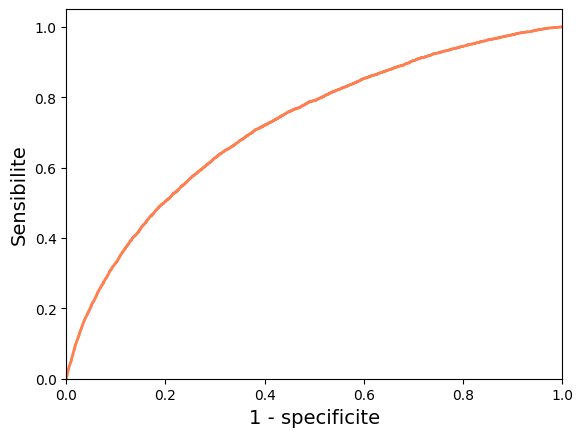

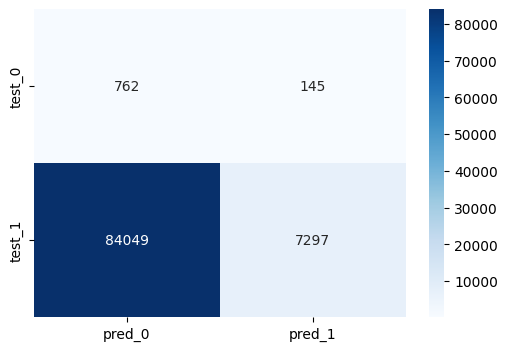

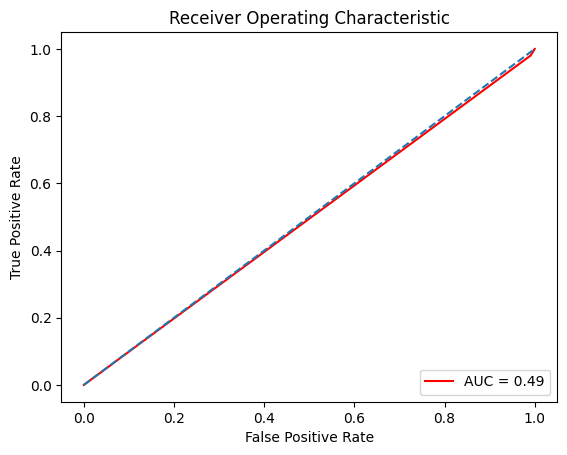

Prediction for :  TARGET


___Model___  __ROC-AUC__  __F-score Beta = 2__  __Recall__  Precision  \
0            Dummy        0.500                 0.000       0.000      0.000   
0  log_reg_SMOTE_1        0.495                 0.301       0.981      0.080   
0        log_reg_3        0.494                 0.301       0.980      0.080   
0        log_reg_2        0.493                 0.300       0.972      0.080   
0        log_reg_1        0.489                 0.297       0.960      0.079   
0  log_reg_SMOTE_0        0.488                 0.296       0.943      0.079   
0        log_reg_4        0.481                 0.288       0.894      0.078   
0        log_reg_0        0.479                 0.285       0.872      0.077   

   F1-score  F1-score weighted  Accuracy  
0     0.000              0.881     0.919  
0     0.148              0.028     0.087  
0     0.148              0.026     0.086  
0     0.147              0.036     0.091  
0     0.146              0.044     0.094  
0     0.146              0.071     0.107  
0     0.143              0.128     0.135  
0     0.142              0.155     0.149

Loading Logistic Regression SMOTE
              precision    recall  f1-score   support

           0       0.84      0.01      0.02     84811
           1       0.08      0.98      0.15      7442

    accuracy                           0.09     92253
   macro avg       0.46      0.49      0.08     92253
weighted avg       0.78      0.09      0.03     92253

ROC-AUC 0.495


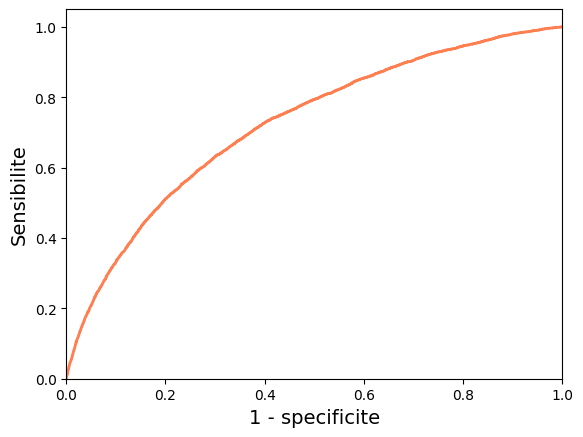

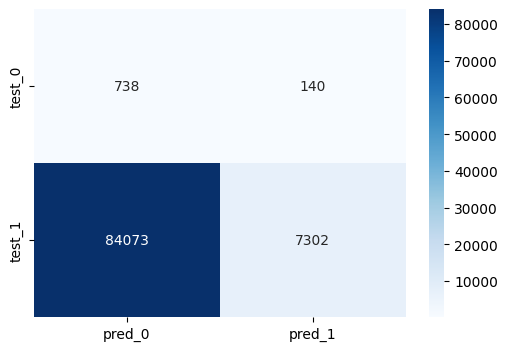

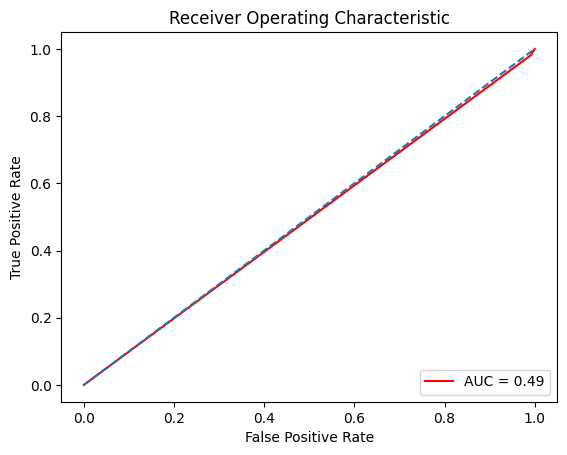

Prediction for :  TARGET


___Model___  __ROC-AUC__  __F-score Beta = 2__  __Recall__  Precision  \
0            Dummy        0.500                 0.000       0.000      0.000   
0  log_reg_SMOTE_1        0.495                 0.301       0.981      0.080   
0  log_reg_SMOTE_2        0.495                 0.301       0.981      0.080   
0        log_reg_3        0.494                 0.301       0.980      0.080   
0        log_reg_2        0.493                 0.300       0.972      0.080   
0        log_reg_1        0.489                 0.297       0.960      0.079   
0  log_reg_SMOTE_0        0.488                 0.296       0.943      0.079   
0        log_reg_4        0.481                 0.288       0.894      0.078   
0        log_reg_0        0.479                 0.285       0.872      0.077   

   F1-score  F1-score weighted  Accuracy  
0     0.000              0.881     0.919  
0     0.148              0.028     0.087  
0     0.148              0.028     0.087  
0     0.148              0.026     0.086  
0     0.147              0.036     0.091  
0     0.146              0.044     0.094  
0     0.146              0.071     0.107  
0     0.143              0.128     0.135  
0     0.142              0.155     0.149

Loading Logistic Regression SMOTE
              precision    recall  f1-score   support

           0       0.83      0.01      0.02     84811
           1       0.08      0.98      0.15      7442

    accuracy                           0.09     92253
   macro avg       0.46      0.49      0.08     92253
weighted avg       0.77      0.09      0.03     92253

ROC-AUC 0.493


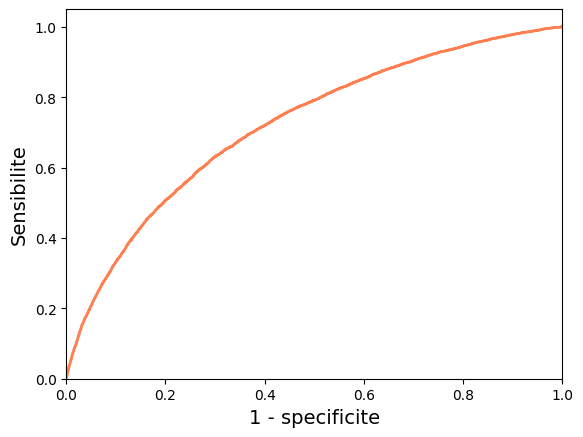

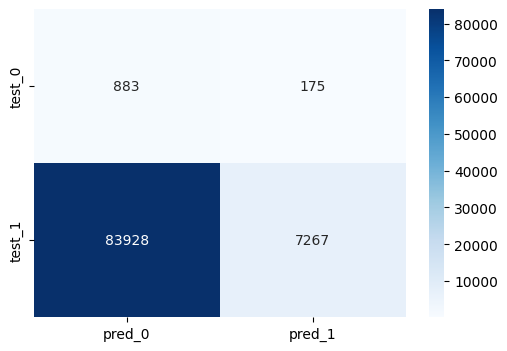

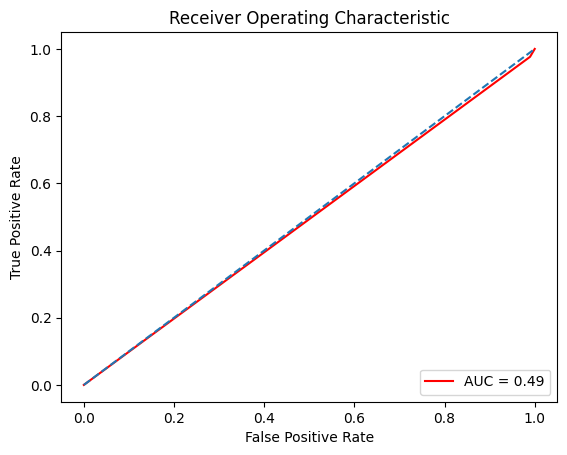

Prediction for :  TARGET


___Model___  __ROC-AUC__  __F-score Beta = 2__  __Recall__  Precision  \
0            Dummy        0.500                 0.000       0.000      0.000   
0  log_reg_SMOTE_1        0.495                 0.301       0.981      0.080   
0  log_reg_SMOTE_2        0.495                 0.301       0.981      0.080   
0        log_reg_3        0.494                 0.301       0.980      0.080   
0        log_reg_2        0.493                 0.300       0.972      0.080   
0  log_reg_SMOTE_3        0.493                 0.300       0.976      0.080   
0        log_reg_1        0.489                 0.297       0.960      0.079   
0  log_reg_SMOTE_0        0.488                 0.296       0.943      0.079   
0        log_reg_4        0.481                 0.288       0.894      0.078   
0        log_reg_0        0.479                 0.285       0.872      0.077   

   F1-score  F1-score weighted  Accuracy  
0     0.000              0.881     0.919  
0     0.148              0.028     0.087  
0     0.148              0.028     0.087  
0     0.148              0.026     0.086  
0     0.147              0.036     0.091  
0     0.147              0.031     0.088  
0     0.146              0.044     0.094  
0     0.146              0.071     0.107  
0     0.143              0.128     0.135  
0     0.142              0.155     0.149

Loading Logistic Regression SMOTE
              precision    recall  f1-score   support

           0       0.84      0.01      0.03     84811
           1       0.08      0.97      0.15      7442

    accuracy                           0.09     92253
   macro avg       0.46      0.49      0.09     92253
weighted avg       0.78      0.09      0.04     92253

ROC-AUC 0.492


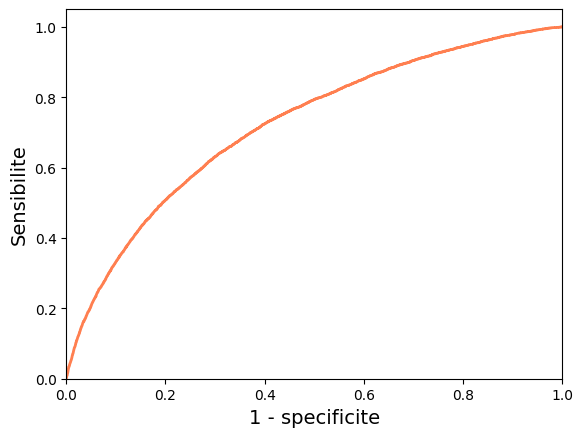

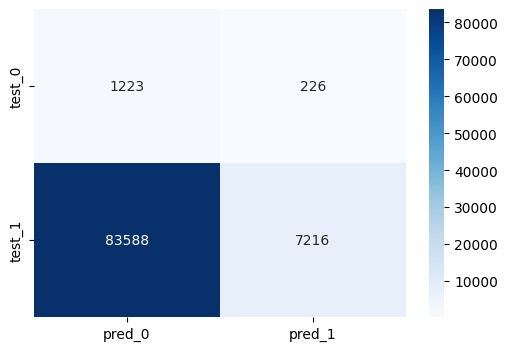

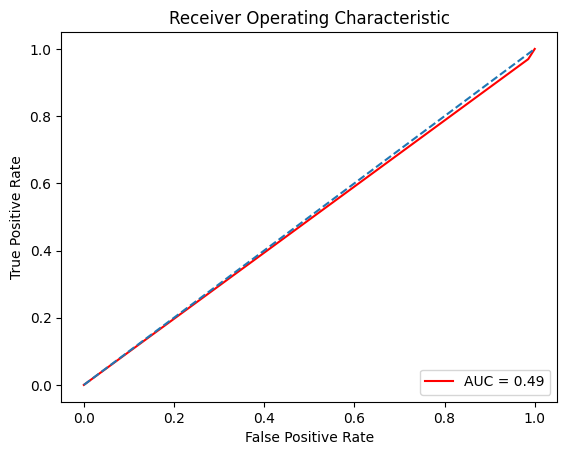

Prediction for :  TARGET


___Model___  __ROC-AUC__  __F-score Beta = 2__  __Recall__  Precision  \
0            Dummy        0.500                 0.000       0.000      0.000   
0  log_reg_SMOTE_1        0.495                 0.301       0.981      0.080   
0  log_reg_SMOTE_2        0.495                 0.301       0.981      0.080   
0        log_reg_3        0.494                 0.301       0.980      0.080   
0        log_reg_2        0.493                 0.300       0.972      0.080   
0  log_reg_SMOTE_3        0.493                 0.300       0.976      0.080   
0  log_reg_SMOTE_4        0.492                 0.299       0.970      0.079   
0        log_reg_1        0.489                 0.297       0.960      0.079   
0  log_reg_SMOTE_0        0.488                 0.296       0.943      0.079   
0        log_reg_4        0.481                 0.288       0.894      0.078   
0        log_reg_0        0.479                 0.285       0.872      0.077   

   F1-score  F1-score weighted  Accuracy  
0     0.000              0.881     0.919  
0     0.148              0.028     0.087  
0     0.148              0.028     0.087  
0     0.148              0.026     0.086  
0     0.147              0.036     0.091  
0     0.147              0.031     0.088  
0     0.147              0.038     0.091  
0     0.146              0.044     0.094  
0     0.146              0.071     0.107  
0     0.143              0.128     0.135  
0     0.142              0.155     0.149

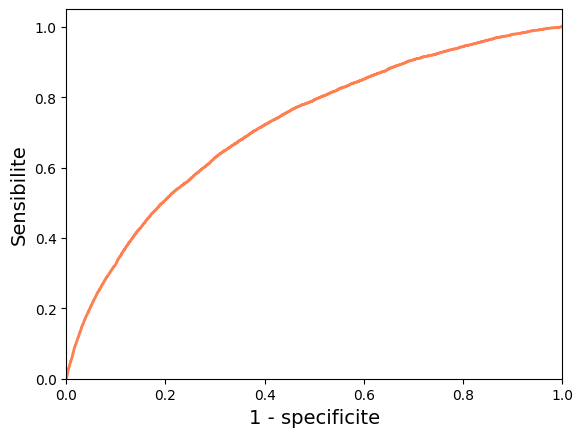

In [65]:
for i in range(5):
    # load model
    print("Loading Logistic Regression SMOTE")
    clf = joblib.load('models/log_reg_SMOTE/log_reg_SMOTE_fold_{}.joblib'.format(i))

    y_pred = clf.predict(X_test)
    y_pred_proba = clf.predict_proba(X_test_std)[:, 1] # we take the prediction for the class 1
    evaluate_classification(y_test, y_pred, y_pred_proba=y_pred_proba)
    results = evaluate_models("log_reg_SMOTE_{}".format(i), results, y_test, y_pred)

#### LightGBM

##### 1) Training using Cross-Validation with 10 stratified folds

**For the lightGBM model, we used another training method in the script train_models.py, the running time to train 10 LightGBM model is more than 3 hours, thus here, we load these trained models and evaluate them just like the others above.**

Since it takes around 3 hours to generate the 10 LightGBM models, the cell below is deactivated since the models are saved locally.


import subprocess

print("__Generate LGBM models using Cross-Validation__")
subprocess.call(r'python train_models.py', shell=True)

Loading LGBM
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     84811
           1       0.88      0.04      0.07      7442

    accuracy                           0.92     92253
   macro avg       0.90      0.52      0.52     92253
weighted avg       0.92      0.92      0.89     92253

ROC-AUC 0.519


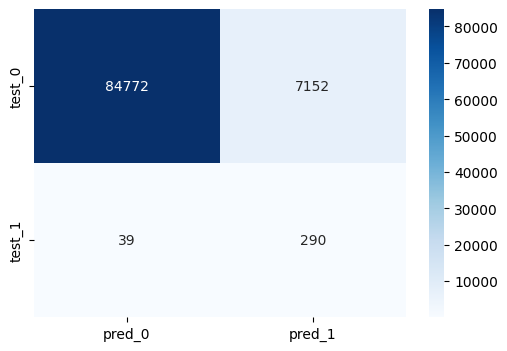

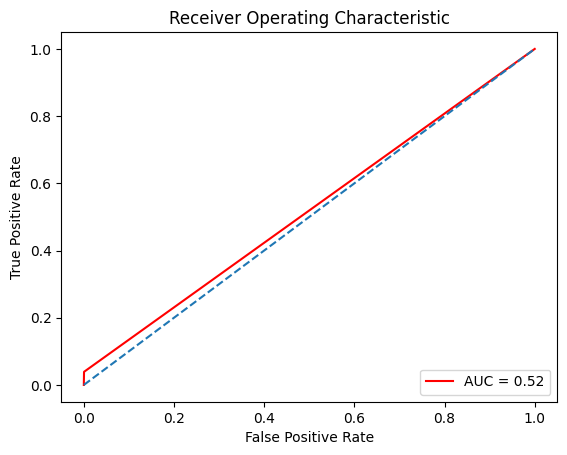

Prediction for :  TARGET


___Model___  __ROC-AUC__  __F-score Beta = 2__  __Recall__  Precision  \
0       LightGBM_0        0.519                 0.048       0.039      0.881   
0            Dummy        0.500                 0.000       0.000      0.000   
0  log_reg_SMOTE_1        0.495                 0.301       0.981      0.080   
0  log_reg_SMOTE_2        0.495                 0.301       0.981      0.080   
0        log_reg_3        0.494                 0.301       0.980      0.080   
0        log_reg_2        0.493                 0.300       0.972      0.080   
0  log_reg_SMOTE_3        0.493                 0.300       0.976      0.080   
0  log_reg_SMOTE_4        0.492                 0.299       0.970      0.079   
0        log_reg_1        0.489                 0.297       0.960      0.079   
0  log_reg_SMOTE_0        0.488                 0.296       0.943      0.079   
0        log_reg_4        0.481                 0.288       0.894      0.078   
0        log_reg_0        0.479                 0.285       0.872      0.077   

   F1-score  F1-score weighted  Accuracy  
0     0.075              0.888     0.922  
0     0.000              0.881     0.919  
0     0.148              0.028     0.087  
0     0.148              0.028     0.087  
0     0.148              0.026     0.086  
0     0.147              0.036     0.091  
0     0.147              0.031     0.088  
0     0.147              0.038     0.091  
0     0.146              0.044     0.094  
0     0.146              0.071     0.107  
0     0.143              0.128     0.135  
0     0.142              0.155     0.149

Loading LGBM
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     84811
           1       0.81      0.04      0.08      7442

    accuracy                           0.92     92253
   macro avg       0.87      0.52      0.52     92253
weighted avg       0.91      0.92      0.89     92253

ROC-AUC 0.521


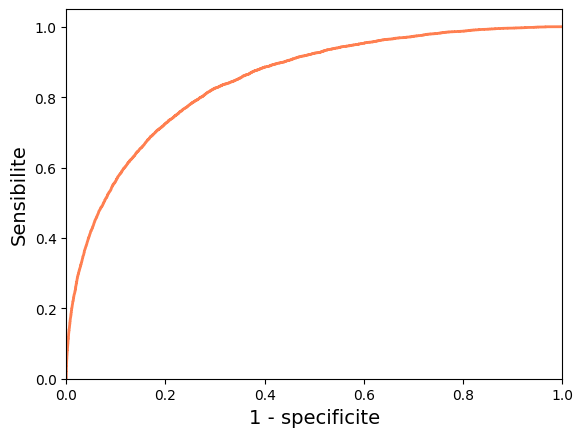

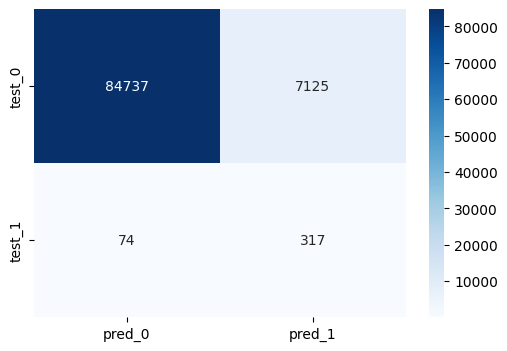

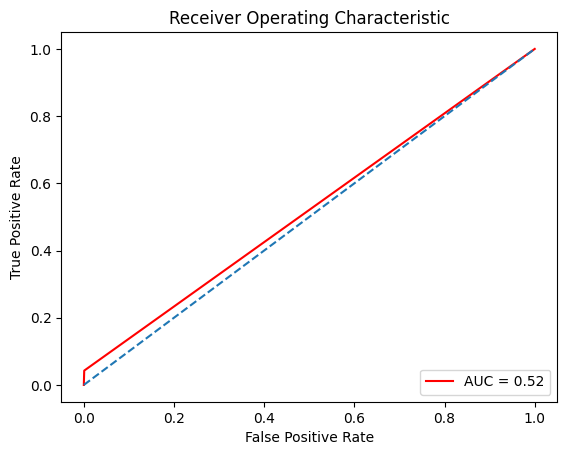

Prediction for :  TARGET


___Model___  __ROC-AUC__  __F-score Beta = 2__  __Recall__  Precision  \
0       LightGBM_1        0.521                 0.053       0.043      0.811   
0       LightGBM_0        0.519                 0.048       0.039      0.881   
0            Dummy        0.500                 0.000       0.000      0.000   
0  log_reg_SMOTE_1        0.495                 0.301       0.981      0.080   
0  log_reg_SMOTE_2        0.495                 0.301       0.981      0.080   
0        log_reg_3        0.494                 0.301       0.980      0.080   
0        log_reg_2        0.493                 0.300       0.972      0.080   
0  log_reg_SMOTE_3        0.493                 0.300       0.976      0.080   
0  log_reg_SMOTE_4        0.492                 0.299       0.970      0.079   
0        log_reg_1        0.489                 0.297       0.960      0.079   
0  log_reg_SMOTE_0        0.488                 0.296       0.943      0.079   
0        log_reg_4        0.481                 0.288       0.894      0.078   
0        log_reg_0        0.479                 0.285       0.872      0.077   

   F1-score  F1-score weighted  Accuracy  
0     0.081              0.888     0.922  
0     0.075              0.888     0.922  
0     0.000              0.881     0.919  
0     0.148              0.028     0.087  
0     0.148              0.028     0.087  
0     0.148              0.026     0.086  
0     0.147              0.036     0.091  
0     0.147              0.031     0.088  
0     0.147              0.038     0.091  
0     0.146              0.044     0.094  
0     0.146              0.071     0.107  
0     0.143              0.128     0.135  
0     0.142              0.155     0.149

Loading LGBM
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     84811
           1       0.86      0.04      0.07      7442

    accuracy                           0.92     92253
   macro avg       0.89      0.52      0.51     92253
weighted avg       0.92      0.92      0.89     92253

ROC-AUC 0.518


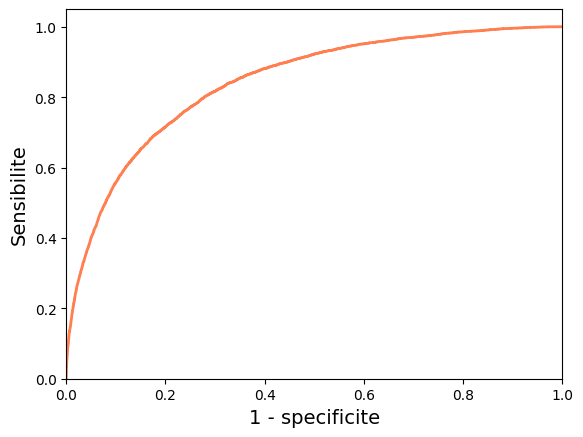

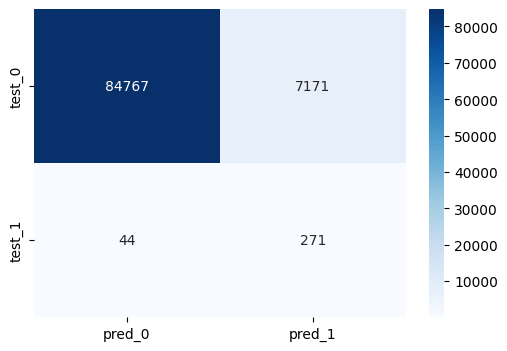

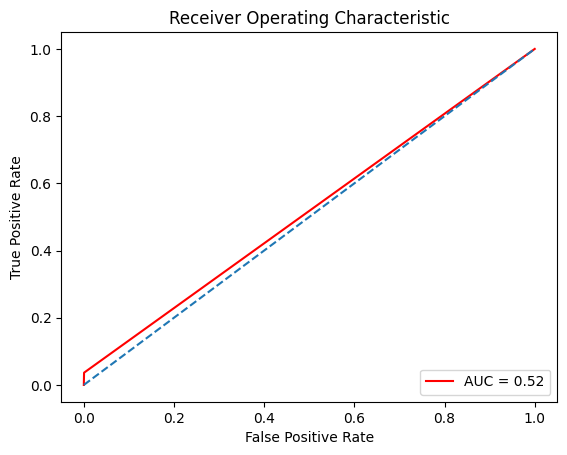

Prediction for :  TARGET


___Model___  __ROC-AUC__  __F-score Beta = 2__  __Recall__  Precision  \
0       LightGBM_1        0.521                 0.053       0.043      0.811   
0       LightGBM_0        0.519                 0.048       0.039      0.881   
0       LightGBM_2        0.518                 0.045       0.036      0.860   
0            Dummy        0.500                 0.000       0.000      0.000   
0  log_reg_SMOTE_1        0.495                 0.301       0.981      0.080   
0  log_reg_SMOTE_2        0.495                 0.301       0.981      0.080   
0        log_reg_3        0.494                 0.301       0.980      0.080   
0        log_reg_2        0.493                 0.300       0.972      0.080   
0  log_reg_SMOTE_3        0.493                 0.300       0.976      0.080   
0  log_reg_SMOTE_4        0.492                 0.299       0.970      0.079   
0        log_reg_1        0.489                 0.297       0.960      0.079   
0  log_reg_SMOTE_0        0.488                 0.296       0.943      0.079   
0        log_reg_4        0.481                 0.288       0.894      0.078   
0        log_reg_0        0.479                 0.285       0.872      0.077   

   F1-score  F1-score weighted  Accuracy  
0     0.081              0.888     0.922  
0     0.075              0.888     0.922  
0     0.070              0.887     0.922  
0     0.000              0.881     0.919  
0     0.148              0.028     0.087  
0     0.148              0.028     0.087  
0     0.148              0.026     0.086  
0     0.147              0.036     0.091  
0     0.147              0.031     0.088  
0     0.147              0.038     0.091  
0     0.146              0.044     0.094  
0     0.146              0.071     0.107  
0     0.143              0.128     0.135  
0     0.142              0.155     0.149

Loading LGBM
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     84811
           1       0.87      0.04      0.08      7442

    accuracy                           0.92     92253
   macro avg       0.90      0.52      0.52     92253
weighted avg       0.92      0.92      0.89     92253

ROC-AUC 0.521


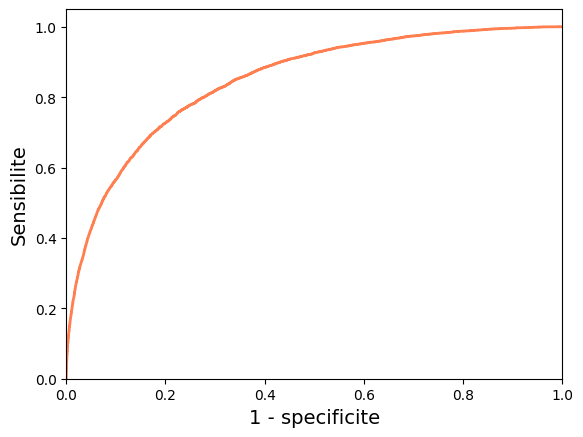

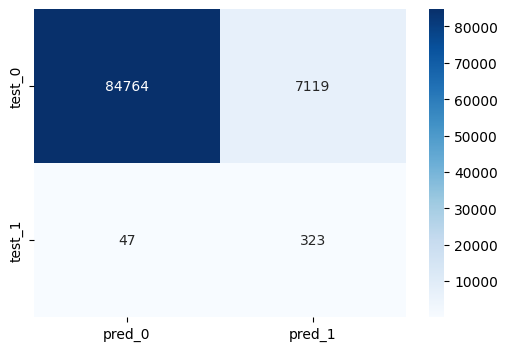

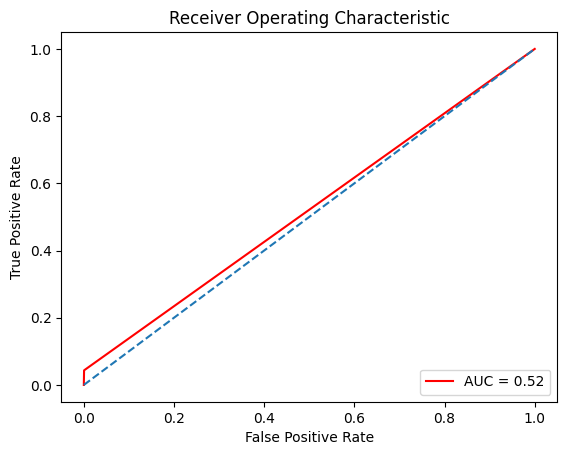

Prediction for :  TARGET


___Model___  __ROC-AUC__  __F-score Beta = 2__  __Recall__  Precision  \
0       LightGBM_1        0.521                 0.053       0.043      0.811   
0       LightGBM_3        0.521                 0.054       0.043      0.873   
0       LightGBM_0        0.519                 0.048       0.039      0.881   
0       LightGBM_2        0.518                 0.045       0.036      0.860   
0            Dummy        0.500                 0.000       0.000      0.000   
0  log_reg_SMOTE_1        0.495                 0.301       0.981      0.080   
0  log_reg_SMOTE_2        0.495                 0.301       0.981      0.080   
0        log_reg_3        0.494                 0.301       0.980      0.080   
0        log_reg_2        0.493                 0.300       0.972      0.080   
0  log_reg_SMOTE_3        0.493                 0.300       0.976      0.080   
0  log_reg_SMOTE_4        0.492                 0.299       0.970      0.079   
0        log_reg_1        0.489                 0.297       0.960      0.079   
0  log_reg_SMOTE_0        0.488                 0.296       0.943      0.079   
0        log_reg_4        0.481                 0.288       0.894      0.078   
0        log_reg_0        0.479                 0.285       0.872      0.077   

   F1-score  F1-score weighted  Accuracy  
0     0.081              0.888     0.922  
0     0.083              0.889     0.922  
0     0.075              0.888     0.922  
0     0.070              0.887     0.922  
0     0.000              0.881     0.919  
0     0.148              0.028     0.087  
0     0.148              0.028     0.087  
0     0.148              0.026     0.086  
0     0.147              0.036     0.091  
0     0.147              0.031     0.088  
0     0.147              0.038     0.091  
0     0.146              0.044     0.094  
0     0.146              0.071     0.107  
0     0.143              0.128     0.135  
0     0.142              0.155     0.149

Loading LGBM
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     84811
           1       0.83      0.05      0.09      7442

    accuracy                           0.92     92253
   macro avg       0.88      0.52      0.52     92253
weighted avg       0.92      0.92      0.89     92253

ROC-AUC 0.523


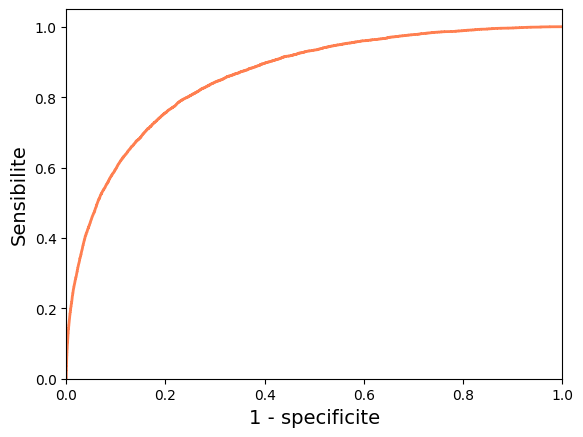

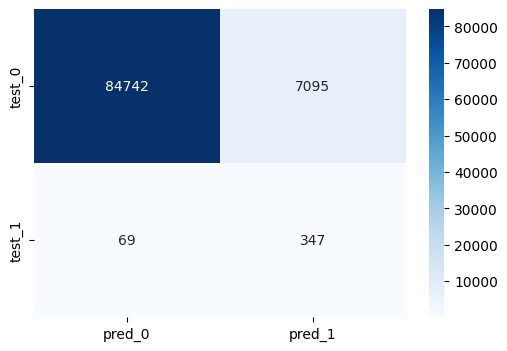

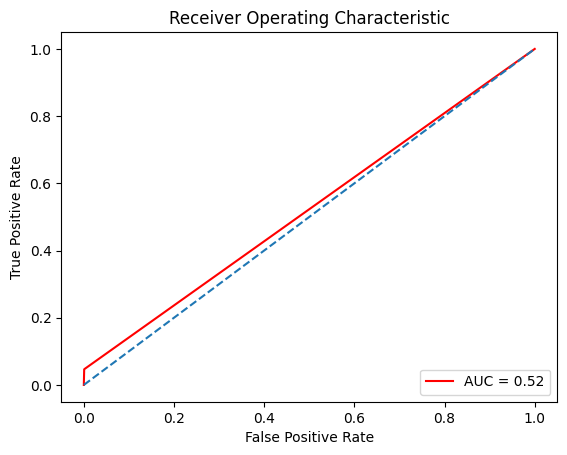

Prediction for :  TARGET


___Model___  __ROC-AUC__  __F-score Beta = 2__  __Recall__  Precision  \
0       LightGBM_4        0.523                 0.057       0.047      0.834   
0       LightGBM_1        0.521                 0.053       0.043      0.811   
0       LightGBM_3        0.521                 0.054       0.043      0.873   
0       LightGBM_0        0.519                 0.048       0.039      0.881   
0       LightGBM_2        0.518                 0.045       0.036      0.860   
0            Dummy        0.500                 0.000       0.000      0.000   
0  log_reg_SMOTE_1        0.495                 0.301       0.981      0.080   
0  log_reg_SMOTE_2        0.495                 0.301       0.981      0.080   
0        log_reg_3        0.494                 0.301       0.980      0.080   
0        log_reg_2        0.493                 0.300       0.972      0.080   
0  log_reg_SMOTE_3        0.493                 0.300       0.976      0.080   
0  log_reg_SMOTE_4        0.492                 0.299       0.970      0.079   
0        log_reg_1        0.489                 0.297       0.960      0.079   
0  log_reg_SMOTE_0        0.488                 0.296       0.943      0.079   
0        log_reg_4        0.481                 0.288       0.894      0.078   
0        log_reg_0        0.479                 0.285       0.872      0.077   

   F1-score  F1-score weighted  Accuracy  
0     0.088              0.889     0.922  
0     0.081              0.888     0.922  
0     0.083              0.889     0.922  
0     0.075              0.888     0.922  
0     0.070              0.887     0.922  
0     0.000              0.881     0.919  
0     0.148              0.028     0.087  
0     0.148              0.028     0.087  
0     0.148              0.026     0.086  
0     0.147              0.036     0.091  
0     0.147              0.031     0.088  
0     0.147              0.038     0.091  
0     0.146              0.044     0.094  
0     0.146              0.071     0.107  
0     0.143              0.128     0.135  
0     0.142              0.155     0.149

Loading LGBM
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     84811
           1       0.80      0.04      0.08      7442

    accuracy                           0.92     92253
   macro avg       0.86      0.52      0.52     92253
weighted avg       0.91      0.92      0.89     92253

ROC-AUC 0.52


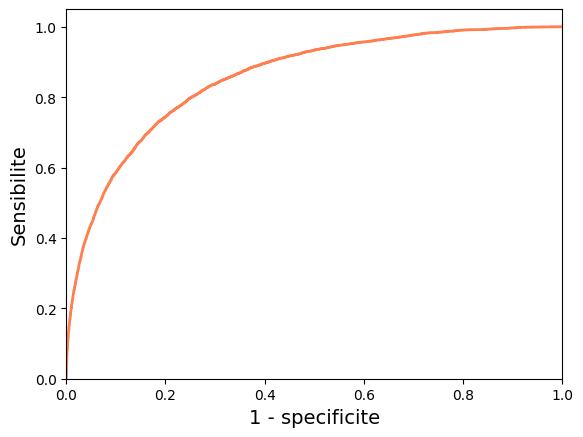

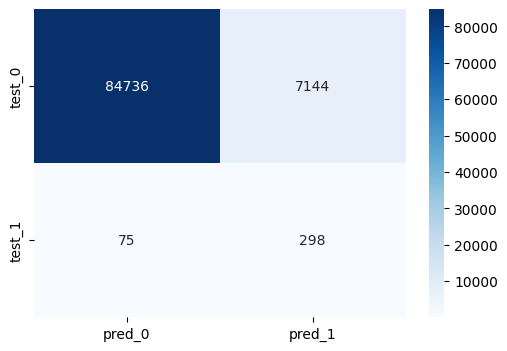

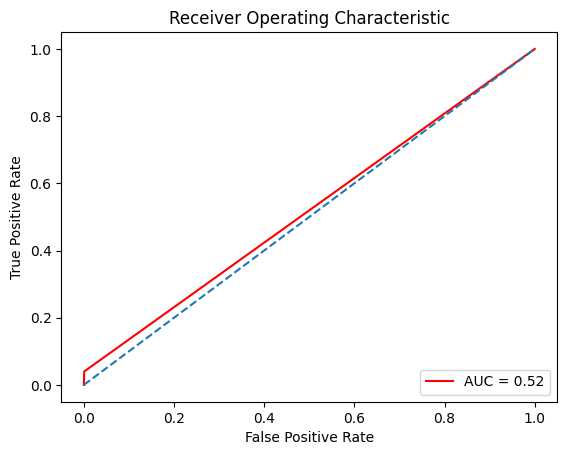

Prediction for :  TARGET


___Model___  __ROC-AUC__  __F-score Beta = 2__  __Recall__  Precision  \
0       LightGBM_4        0.523                 0.057       0.047      0.834   
0       LightGBM_1        0.521                 0.053       0.043      0.811   
0       LightGBM_3        0.521                 0.054       0.043      0.873   
0       LightGBM_5        0.520                 0.049       0.040      0.799   
0       LightGBM_0        0.519                 0.048       0.039      0.881   
0       LightGBM_2        0.518                 0.045       0.036      0.860   
0            Dummy        0.500                 0.000       0.000      0.000   
0  log_reg_SMOTE_1        0.495                 0.301       0.981      0.080   
0  log_reg_SMOTE_2        0.495                 0.301       0.981      0.080   
0        log_reg_3        0.494                 0.301       0.980      0.080   
0        log_reg_2        0.493                 0.300       0.972      0.080   
0  log_reg_SMOTE_3        0.493                 0.300       0.976      0.080   
0  log_reg_SMOTE_4        0.492                 0.299       0.970      0.079   
0        log_reg_1        0.489                 0.297       0.960      0.079   
0  log_reg_SMOTE_0        0.488                 0.296       0.943      0.079   
0        log_reg_4        0.481                 0.288       0.894      0.078   
0        log_reg_0        0.479                 0.285       0.872      0.077   

   F1-score  F1-score weighted  Accuracy  
0     0.088              0.889     0.922  
0     0.081              0.888     0.922  
0     0.083              0.889     0.922  
0     0.076              0.888     0.922  
0     0.075              0.888     0.922  
0     0.070              0.887     0.922  
0     0.000              0.881     0.919  
0     0.148              0.028     0.087  
0     0.148              0.028     0.087  
0     0.148              0.026     0.086  
0     0.147              0.036     0.091  
0     0.147              0.031     0.088  
0     0.147              0.038     0.091  
0     0.146              0.044     0.094  
0     0.146              0.071     0.107  
0     0.143              0.128     0.135  
0     0.142              0.155     0.149

Loading LGBM
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     84811
           1       0.82      0.04      0.08      7442

    accuracy                           0.92     92253
   macro avg       0.87      0.52      0.52     92253
weighted avg       0.91      0.92      0.89     92253

ROC-AUC 0.52


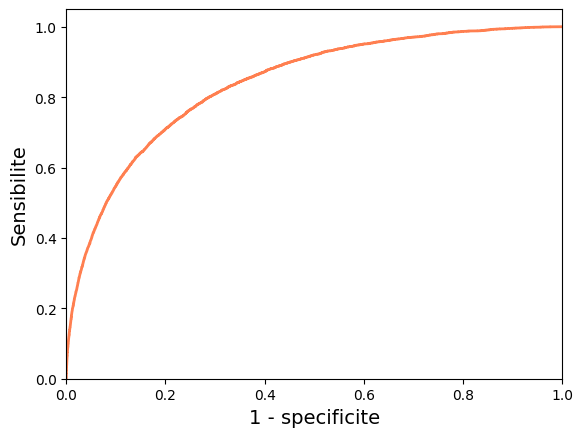

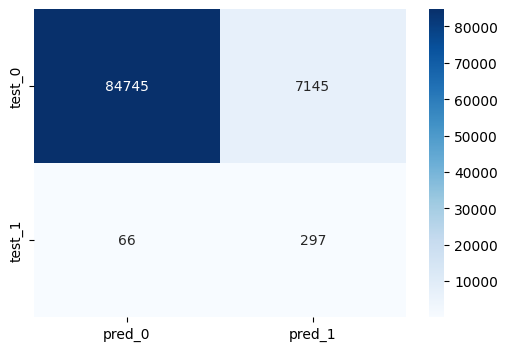

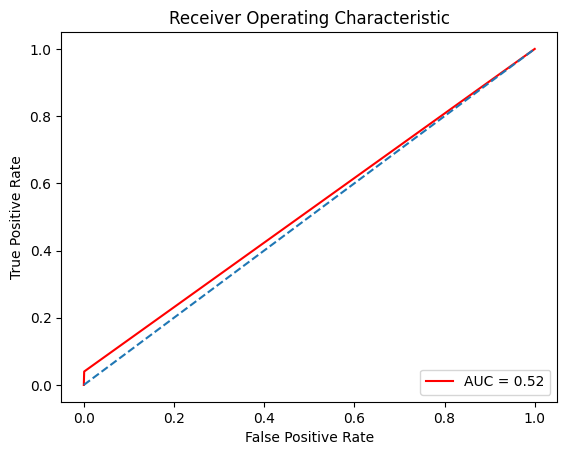

Prediction for :  TARGET


___Model___  __ROC-AUC__  __F-score Beta = 2__  __Recall__  Precision  \
0       LightGBM_4        0.523                 0.057       0.047      0.834   
0       LightGBM_1        0.521                 0.053       0.043      0.811   
0       LightGBM_3        0.521                 0.054       0.043      0.873   
0       LightGBM_6        0.520                 0.049       0.040      0.818   
0       LightGBM_5        0.520                 0.049       0.040      0.799   
0       LightGBM_0        0.519                 0.048       0.039      0.881   
0       LightGBM_2        0.518                 0.045       0.036      0.860   
0            Dummy        0.500                 0.000       0.000      0.000   
0  log_reg_SMOTE_1        0.495                 0.301       0.981      0.080   
0  log_reg_SMOTE_2        0.495                 0.301       0.981      0.080   
0        log_reg_3        0.494                 0.301       0.980      0.080   
0        log_reg_2        0.493                 0.300       0.972      0.080   
0  log_reg_SMOTE_3        0.493                 0.300       0.976      0.080   
0  log_reg_SMOTE_4        0.492                 0.299       0.970      0.079   
0        log_reg_1        0.489                 0.297       0.960      0.079   
0  log_reg_SMOTE_0        0.488                 0.296       0.943      0.079   
0        log_reg_4        0.481                 0.288       0.894      0.078   
0        log_reg_0        0.479                 0.285       0.872      0.077   

   F1-score  F1-score weighted  Accuracy  
0     0.088              0.889     0.922  
0     0.081              0.888     0.922  
0     0.083              0.889     0.922  
0     0.076              0.888     0.922  
0     0.076              0.888     0.922  
0     0.075              0.888     0.922  
0     0.070              0.887     0.922  
0     0.000              0.881     0.919  
0     0.148              0.028     0.087  
0     0.148              0.028     0.087  
0     0.148              0.026     0.086  
0     0.147              0.036     0.091  
0     0.147              0.031     0.088  
0     0.147              0.038     0.091  
0     0.146              0.044     0.094  
0     0.146              0.071     0.107  
0     0.143              0.128     0.135  
0     0.142              0.155     0.149

Loading LGBM
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     84811
           1       0.88      0.06      0.12      7442

    accuracy                           0.92     92253
   macro avg       0.90      0.53      0.54     92253
weighted avg       0.92      0.92      0.89     92253

ROC-AUC 0.531


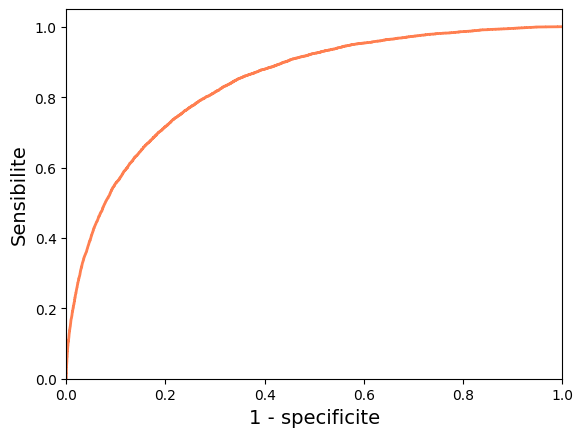

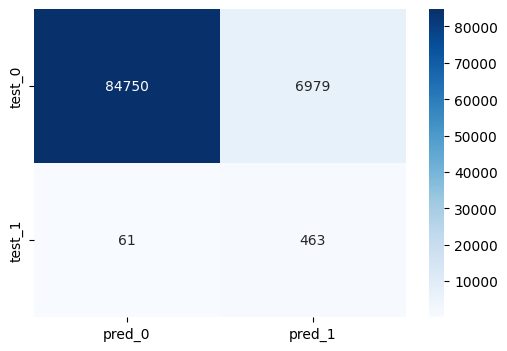

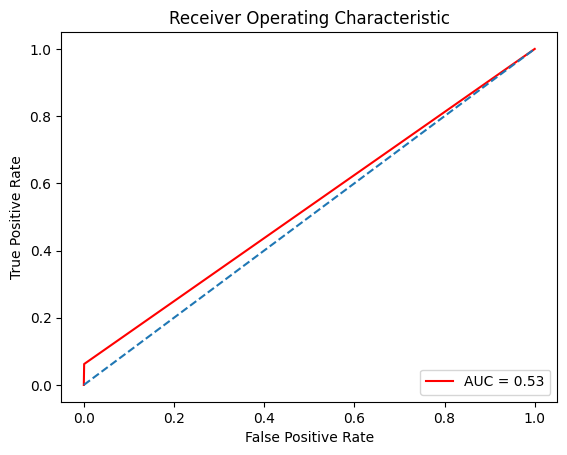

Prediction for :  TARGET


___Model___  __ROC-AUC__  __F-score Beta = 2__  __Recall__  Precision  \
0       LightGBM_7        0.531                 0.076       0.062      0.884   
0       LightGBM_4        0.523                 0.057       0.047      0.834   
0       LightGBM_3        0.521                 0.054       0.043      0.873   
0       LightGBM_1        0.521                 0.053       0.043      0.811   
0       LightGBM_5        0.520                 0.049       0.040      0.799   
0       LightGBM_6        0.520                 0.049       0.040      0.818   
0       LightGBM_0        0.519                 0.048       0.039      0.881   
0       LightGBM_2        0.518                 0.045       0.036      0.860   
0            Dummy        0.500                 0.000       0.000      0.000   
0  log_reg_SMOTE_2        0.495                 0.301       0.981      0.080   
0  log_reg_SMOTE_1        0.495                 0.301       0.981      0.080   
0        log_reg_3        0.494                 0.301       0.980      0.080   
0        log_reg_2        0.493                 0.300       0.972      0.080   
0  log_reg_SMOTE_3        0.493                 0.300       0.976      0.080   
0  log_reg_SMOTE_4        0.492                 0.299       0.970      0.079   
0        log_reg_1        0.489                 0.297       0.960      0.079   
0  log_reg_SMOTE_0        0.488                 0.296       0.943      0.079   
0        log_reg_4        0.481                 0.288       0.894      0.078   
0        log_reg_0        0.479                 0.285       0.872      0.077   

   F1-score  F1-score weighted  Accuracy  
0     0.116              0.892     0.924  
0     0.088              0.889     0.922  
0     0.083              0.889     0.922  
0     0.081              0.888     0.922  
0     0.076              0.888     0.922  
0     0.076              0.888     0.922  
0     0.075              0.888     0.922  
0     0.070              0.887     0.922  
0     0.000              0.881     0.919  
0     0.148              0.028     0.087  
0     0.148              0.028     0.087  
0     0.148              0.026     0.086  
0     0.147              0.036     0.091  
0     0.147              0.031     0.088  
0     0.147              0.038     0.091  
0     0.146              0.044     0.094  
0     0.146              0.071     0.107  
0     0.143              0.128     0.135  
0     0.142              0.155     0.149

Loading LGBM
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     84811
           1       0.84      0.05      0.09      7442

    accuracy                           0.92     92253
   macro avg       0.88      0.52      0.52     92253
weighted avg       0.92      0.92      0.89     92253

ROC-AUC 0.523


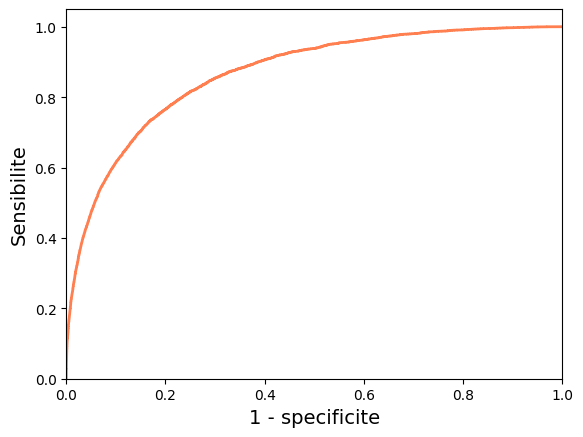

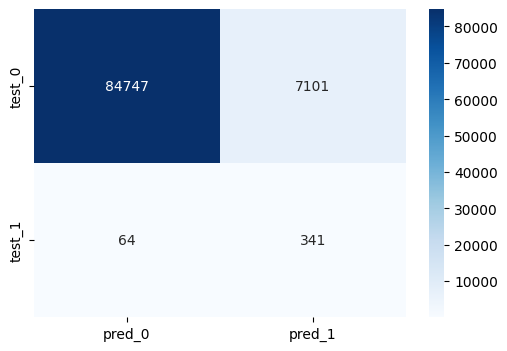

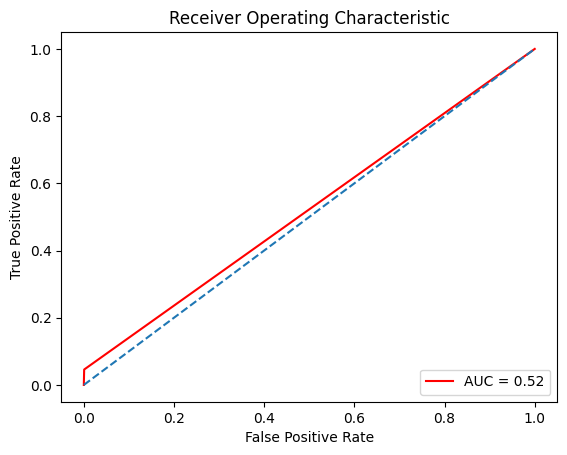

Prediction for :  TARGET


___Model___  __ROC-AUC__  __F-score Beta = 2__  __Recall__  Precision  \
0       LightGBM_7        0.531                 0.076       0.062      0.884   
0       LightGBM_4        0.523                 0.057       0.047      0.834   
0       LightGBM_8        0.523                 0.057       0.046      0.842   
0       LightGBM_1        0.521                 0.053       0.043      0.811   
0       LightGBM_3        0.521                 0.054       0.043      0.873   
0       LightGBM_6        0.520                 0.049       0.040      0.818   
0       LightGBM_5        0.520                 0.049       0.040      0.799   
0       LightGBM_0        0.519                 0.048       0.039      0.881   
0       LightGBM_2        0.518                 0.045       0.036      0.860   
0            Dummy        0.500                 0.000       0.000      0.000   
0  log_reg_SMOTE_1        0.495                 0.301       0.981      0.080   
0  log_reg_SMOTE_2        0.495                 0.301       0.981      0.080   
0        log_reg_3        0.494                 0.301       0.980      0.080   
0        log_reg_2        0.493                 0.300       0.972      0.080   
0  log_reg_SMOTE_3        0.493                 0.300       0.976      0.080   
0  log_reg_SMOTE_4        0.492                 0.299       0.970      0.079   
0        log_reg_1        0.489                 0.297       0.960      0.079   
0  log_reg_SMOTE_0        0.488                 0.296       0.943      0.079   
0        log_reg_4        0.481                 0.288       0.894      0.078   
0        log_reg_0        0.479                 0.285       0.872      0.077   

   F1-score  F1-score weighted  Accuracy  
0     0.116              0.892     0.924  
0     0.088              0.889     0.922  
0     0.087              0.889     0.922  
0     0.081              0.888     0.922  
0     0.083              0.889     0.922  
0     0.076              0.888     0.922  
0     0.076              0.888     0.922  
0     0.075              0.888     0.922  
0     0.070              0.887     0.922  
0     0.000              0.881     0.919  
0     0.148              0.028     0.087  
0     0.148              0.028     0.087  
0     0.148              0.026     0.086  
0     0.147              0.036     0.091  
0     0.147              0.031     0.088  
0     0.147              0.038     0.091  
0     0.146              0.044     0.094  
0     0.146              0.071     0.107  
0     0.143              0.128     0.135  
0     0.142              0.155     0.149

Loading LGBM
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     84811
           1       0.85      0.04      0.08      7442

    accuracy                           0.92     92253
   macro avg       0.88      0.52      0.52     92253
weighted avg       0.92      0.92      0.89     92253

ROC-AUC 0.52


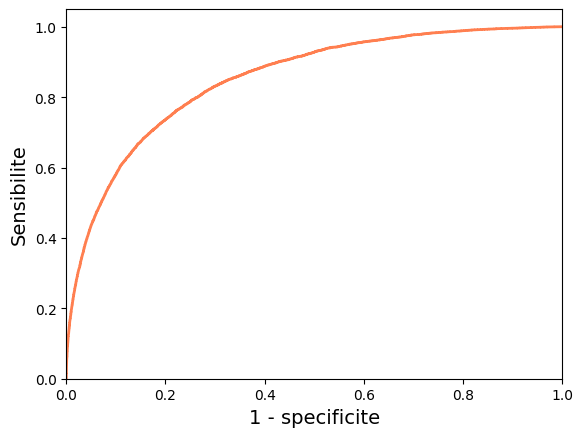

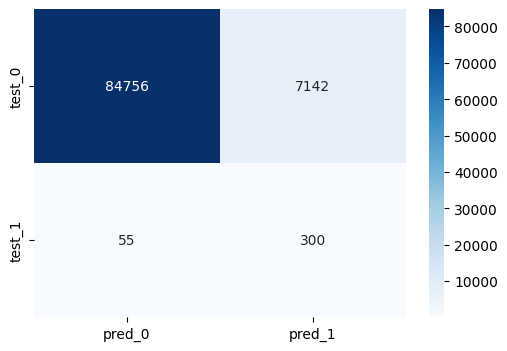

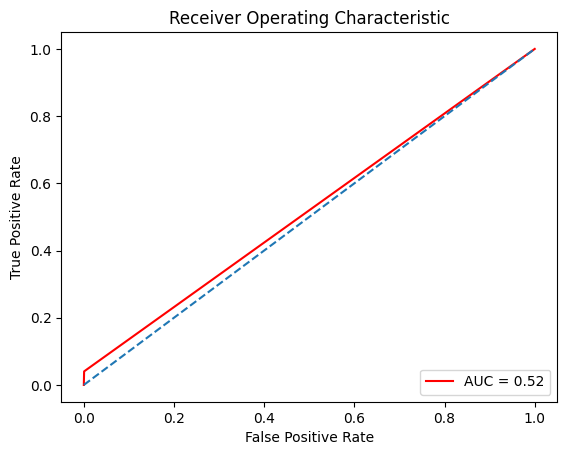

Prediction for :  TARGET


___Model___  __ROC-AUC__  __F-score Beta = 2__  __Recall__  Precision  \
0       LightGBM_7        0.531                 0.076       0.062      0.884   
0       LightGBM_8        0.523                 0.057       0.046      0.842   
0       LightGBM_4        0.523                 0.057       0.047      0.834   
0       LightGBM_1        0.521                 0.053       0.043      0.811   
0       LightGBM_3        0.521                 0.054       0.043      0.873   
0       LightGBM_5        0.520                 0.049       0.040      0.799   
0       LightGBM_9        0.520                 0.050       0.040      0.845   
0       LightGBM_6        0.520                 0.049       0.040      0.818   
0       LightGBM_0        0.519                 0.048       0.039      0.881   
0       LightGBM_2        0.518                 0.045       0.036      0.860   
0            Dummy        0.500                 0.000       0.000      0.000   
0  log_reg_SMOTE_2        0.495                 0.301       0.981      0.080   
0  log_reg_SMOTE_1        0.495                 0.301       0.981      0.080   
0        log_reg_3        0.494                 0.301       0.980      0.080   
0        log_reg_2        0.493                 0.300       0.972      0.080   
0  log_reg_SMOTE_3        0.493                 0.300       0.976      0.080   
0  log_reg_SMOTE_4        0.492                 0.299       0.970      0.079   
0        log_reg_1        0.489                 0.297       0.960      0.079   
0  log_reg_SMOTE_0        0.488                 0.296       0.943      0.079   
0        log_reg_4        0.481                 0.288       0.894      0.078   
0        log_reg_0        0.479                 0.285       0.872      0.077   

   F1-score  F1-score weighted  Accuracy  
0     0.116              0.892     0.924  
0     0.087              0.889     0.922  
0     0.088              0.889     0.922  
0     0.081              0.888     0.922  
0     0.083              0.889     0.922  
0     0.076              0.888     0.922  
0     0.077              0.888     0.922  
0     0.076              0.888     0.922  
0     0.075              0.888     0.922  
0     0.070              0.887     0.922  
0     0.000              0.881     0.919  
0     0.148              0.028     0.087  
0     0.148              0.028     0.087  
0     0.148              0.026     0.086  
0     0.147              0.036     0.091  
0     0.147              0.031     0.088  
0     0.147              0.038     0.091  
0     0.146              0.044     0.094  
0     0.146              0.071     0.107  
0     0.143              0.128     0.135  
0     0.142              0.155     0.149

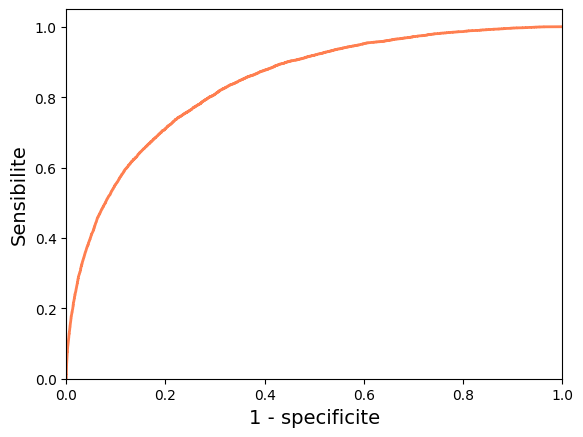

In [66]:
for i in range(10):
    # load model
    print("Loading LGBM")
    clf = joblib.load('models/LGBM/LGBMClassifier_fold_{}.joblib'.format(i))

    y_pred = clf.predict(X_test)
    y_pred_proba = clf.predict_proba(X_test)[:, 1] # we take the prediction for the class 1
    evaluate_classification(y_test, y_pred, y_pred_proba=y_pred_proba)
    results = evaluate_models("LightGBM_{}".format(i), results, y_test, y_pred)

#### HistBoost

In [67]:
from sklearn.ensemble import HistGradientBoostingClassifier

##### 1) Using GridSearchCV to get the best hyper-parameters

In [68]:
params = {
    'max_iter': [50, 100],
    'max_leaf_nodes': [5, 10, 31],
}

#     'learning_rate': [0.1, 0.5],
# 'max_depth': [3, 4, 5],

# the computing time was too long to try more hyperparameters

histBoost_clf = HistGradientBoostingClassifier()

score, params = make_grisearch(histBoost_clf, X, y, param_grid=params)
print(score, params)

##### 2) Training model based on Cross-Validation

In [69]:
histBoost_clf_best_params = HistGradientBoostingClassifier(max_iter=100, max_leaf_nodes=31)
score = evaluate(histBoost_clf_best_params,
                     'HistBoost',
                     X,
                     y,
                     k_fold=5,
                     beta=2,
                     apply_smote=False,
                     smote_params=None)
#print(score)

Starting time
Iteration :  0
Starting fit and predict
Saving model with joblib
Iteration :  1
Starting fit and predict
Saving model with joblib
Iteration :  2
Starting fit and predict
Saving model with joblib
Iteration :  3
Starting fit and predict
Saving model with joblib
Iteration :  4
Starting fit and predict
Saving model with joblib
Computing time : 524.4673223495483 seconds


Loading HistBoost
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     84811
           1       0.52      0.03      0.06      7442

    accuracy                           0.92     92253
   macro avg       0.72      0.52      0.51     92253
weighted avg       0.89      0.92      0.89     92253

ROC-AUC 0.515


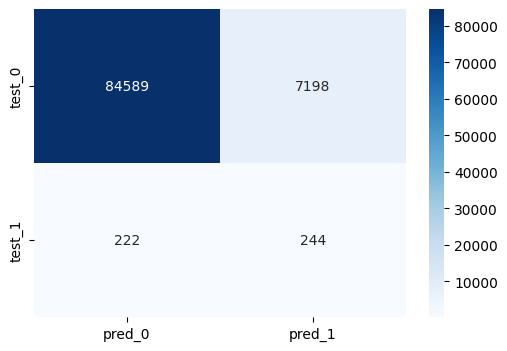

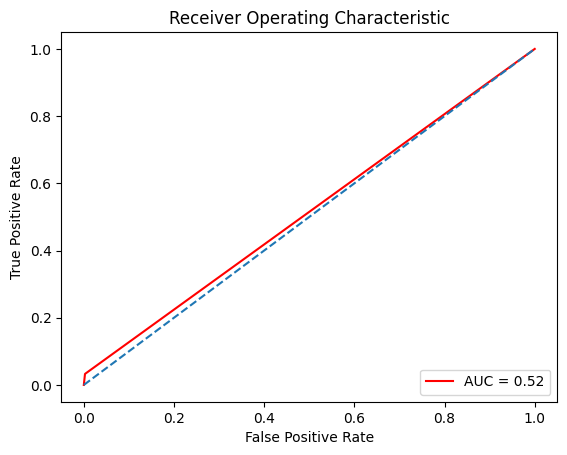

Prediction for :  TARGET


___Model___  __ROC-AUC__  __F-score Beta = 2__  __Recall__  Precision  \
0       LightGBM_7        0.531                 0.076       0.062      0.884   
0       LightGBM_8        0.523                 0.057       0.046      0.842   
0       LightGBM_4        0.523                 0.057       0.047      0.834   
0       LightGBM_1        0.521                 0.053       0.043      0.811   
0       LightGBM_3        0.521                 0.054       0.043      0.873   
0       LightGBM_5        0.520                 0.049       0.040      0.799   
0       LightGBM_9        0.520                 0.050       0.040      0.845   
0       LightGBM_6        0.520                 0.049       0.040      0.818   
0       LightGBM_0        0.519                 0.048       0.039      0.881   
0       LightGBM_2        0.518                 0.045       0.036      0.860   
0      HistBoost_0        0.515                 0.040       0.033      0.524   
0            Dummy        0.500                 0.000       0.000      0.000   
0  log_reg_SMOTE_1        0.495                 0.301       0.981      0.080   
0  log_reg_SMOTE_2        0.495                 0.301       0.981      0.080   
0        log_reg_3        0.494                 0.301       0.980      0.080   
0        log_reg_2        0.493                 0.300       0.972      0.080   
0  log_reg_SMOTE_3        0.493                 0.300       0.976      0.080   
0  log_reg_SMOTE_4        0.492                 0.299       0.970      0.079   
0        log_reg_1        0.489                 0.297       0.960      0.079   
0  log_reg_SMOTE_0        0.488                 0.296       0.943      0.079   
0        log_reg_4        0.481                 0.288       0.894      0.078   
0        log_reg_0        0.479                 0.285       0.872      0.077   

   F1-score  F1-score weighted  Accuracy  
0     0.116              0.892     0.924  
0     0.087              0.889     0.922  
0     0.088              0.889     0.922  
0     0.081              0.888     0.922  
0     0.083              0.889     0.922  
0     0.076              0.888     0.922  
0     0.077              0.888     0.922  
0     0.076              0.888     0.922  
0     0.075              0.888     0.922  
0     0.070              0.887     0.922  
0     0.062              0.886     0.920  
0     0.000              0.881     0.919  
0     0.148              0.028     0.087  
0     0.148              0.028     0.087  
0     0.148              0.026     0.086  
0     0.147              0.036     0.091  
0     0.147              0.031     0.088  
0     0.147              0.038     0.091  
0     0.146              0.044     0.094  
0     0.146              0.071     0.107  
0     0.143              0.128     0.135  
0     0.142              0.155     0.149

Loading HistBoost
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     84811
           1       0.54      0.04      0.07      7442

    accuracy                           0.92     92253
   macro avg       0.73      0.52      0.51     92253
weighted avg       0.89      0.92      0.89     92253

ROC-AUC 0.517


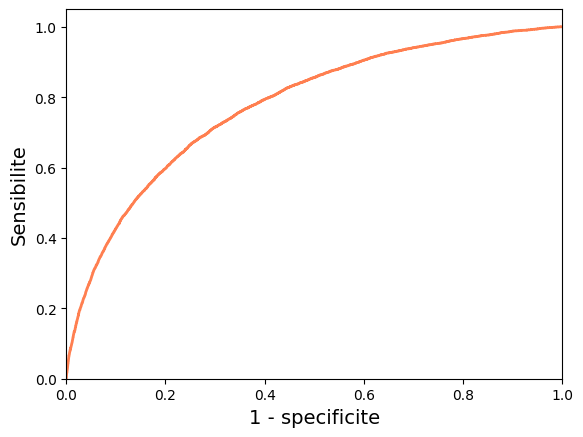

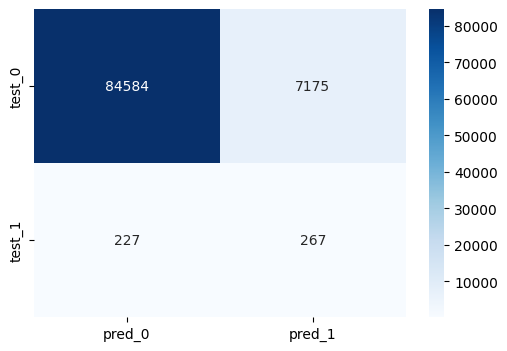

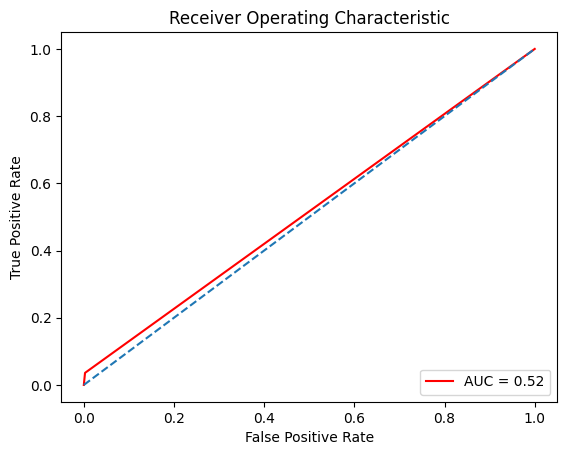

Prediction for :  TARGET


___Model___  __ROC-AUC__  __F-score Beta = 2__  __Recall__  Precision  \
0       LightGBM_7        0.531                 0.076       0.062      0.884   
0       LightGBM_8        0.523                 0.057       0.046      0.842   
0       LightGBM_4        0.523                 0.057       0.047      0.834   
0       LightGBM_1        0.521                 0.053       0.043      0.811   
0       LightGBM_3        0.521                 0.054       0.043      0.873   
0       LightGBM_5        0.520                 0.049       0.040      0.799   
0       LightGBM_9        0.520                 0.050       0.040      0.845   
0       LightGBM_6        0.520                 0.049       0.040      0.818   
0       LightGBM_0        0.519                 0.048       0.039      0.881   
0       LightGBM_2        0.518                 0.045       0.036      0.860   
0      HistBoost_1        0.517                 0.044       0.036      0.540   
0      HistBoost_0        0.515                 0.040       0.033      0.524   
0            Dummy        0.500                 0.000       0.000      0.000   
0  log_reg_SMOTE_1        0.495                 0.301       0.981      0.080   
0  log_reg_SMOTE_2        0.495                 0.301       0.981      0.080   
0        log_reg_3        0.494                 0.301       0.980      0.080   
0        log_reg_2        0.493                 0.300       0.972      0.080   
0  log_reg_SMOTE_3        0.493                 0.300       0.976      0.080   
0  log_reg_SMOTE_4        0.492                 0.299       0.970      0.079   
0        log_reg_1        0.489                 0.297       0.960      0.079   
0  log_reg_SMOTE_0        0.488                 0.296       0.943      0.079   
0        log_reg_4        0.481                 0.288       0.894      0.078   
0        log_reg_0        0.479                 0.285       0.872      0.077   

   F1-score  F1-score weighted  Accuracy  
0     0.116              0.892     0.924  
0     0.087              0.889     0.922  
0     0.088              0.889     0.922  
0     0.081              0.888     0.922  
0     0.083              0.889     0.922  
0     0.076              0.888     0.922  
0     0.077              0.888     0.922  
0     0.076              0.888     0.922  
0     0.075              0.888     0.922  
0     0.070              0.887     0.922  
0     0.067              0.886     0.920  
0     0.062              0.886     0.920  
0     0.000              0.881     0.919  
0     0.148              0.028     0.087  
0     0.148              0.028     0.087  
0     0.148              0.026     0.086  
0     0.147              0.036     0.091  
0     0.147              0.031     0.088  
0     0.147              0.038     0.091  
0     0.146              0.044     0.094  
0     0.146              0.071     0.107  
0     0.143              0.128     0.135  
0     0.142              0.155     0.149

Loading HistBoost
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     84811
           1       0.55      0.04      0.07      7442

    accuracy                           0.92     92253
   macro avg       0.74      0.52      0.52     92253
weighted avg       0.89      0.92      0.89     92253

ROC-AUC 0.518


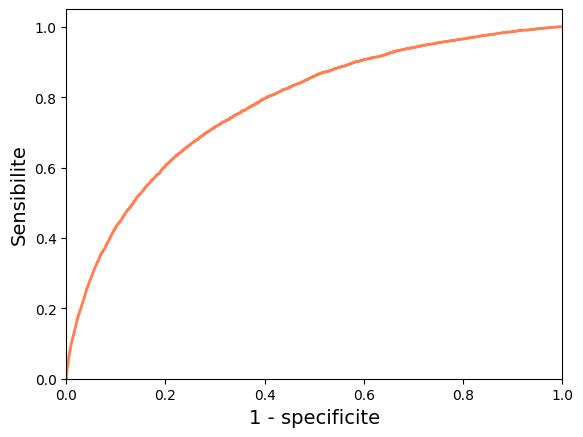

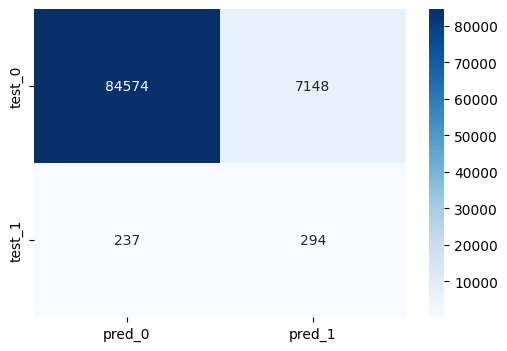

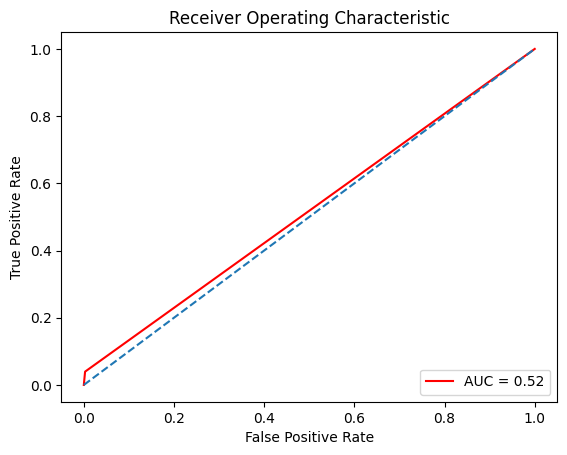

Prediction for :  TARGET


___Model___  __ROC-AUC__  __F-score Beta = 2__  __Recall__  Precision  \
0       LightGBM_7        0.531                 0.076       0.062      0.884   
0       LightGBM_8        0.523                 0.057       0.046      0.842   
0       LightGBM_4        0.523                 0.057       0.047      0.834   
0       LightGBM_1        0.521                 0.053       0.043      0.811   
0       LightGBM_3        0.521                 0.054       0.043      0.873   
0       LightGBM_5        0.520                 0.049       0.040      0.799   
0       LightGBM_9        0.520                 0.050       0.040      0.845   
0       LightGBM_6        0.520                 0.049       0.040      0.818   
0       LightGBM_0        0.519                 0.048       0.039      0.881   
0      HistBoost_2        0.518                 0.049       0.040      0.554   
0       LightGBM_2        0.518                 0.045       0.036      0.860   
0      HistBoost_1        0.517                 0.044       0.036      0.540   
0      HistBoost_0        0.515                 0.040       0.033      0.524   
0            Dummy        0.500                 0.000       0.000      0.000   
0  log_reg_SMOTE_1        0.495                 0.301       0.981      0.080   
0  log_reg_SMOTE_2        0.495                 0.301       0.981      0.080   
0        log_reg_3        0.494                 0.301       0.980      0.080   
0        log_reg_2        0.493                 0.300       0.972      0.080   
0  log_reg_SMOTE_3        0.493                 0.300       0.976      0.080   
0  log_reg_SMOTE_4        0.492                 0.299       0.970      0.079   
0        log_reg_1        0.489                 0.297       0.960      0.079   
0  log_reg_SMOTE_0        0.488                 0.296       0.943      0.079   
0        log_reg_4        0.481                 0.288       0.894      0.078   
0        log_reg_0        0.479                 0.285       0.872      0.077   

   F1-score  F1-score weighted  Accuracy  
0     0.116              0.892     0.924  
0     0.087              0.889     0.922  
0     0.088              0.889     0.922  
0     0.081              0.888     0.922  
0     0.083              0.889     0.922  
0     0.076              0.888     0.922  
0     0.077              0.888     0.922  
0     0.076              0.888     0.922  
0     0.075              0.888     0.922  
0     0.074              0.887     0.920  
0     0.070              0.887     0.922  
0     0.067              0.886     0.920  
0     0.062              0.886     0.920  
0     0.000              0.881     0.919  
0     0.148              0.028     0.087  
0     0.148              0.028     0.087  
0     0.148              0.026     0.086  
0     0.147              0.036     0.091  
0     0.147              0.031     0.088  
0     0.147              0.038     0.091  
0     0.146              0.044     0.094  
0     0.146              0.071     0.107  
0     0.143              0.128     0.135  
0     0.142              0.155     0.149

Loading HistBoost
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     84811
           1       0.53      0.03      0.07      7442

    accuracy                           0.92     92253
   macro avg       0.73      0.52      0.51     92253
weighted avg       0.89      0.92      0.89     92253

ROC-AUC 0.516


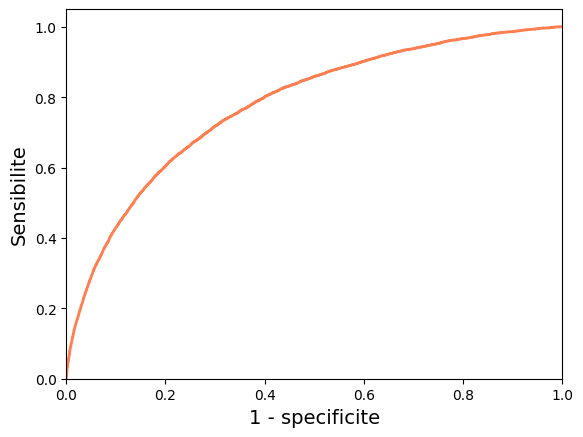

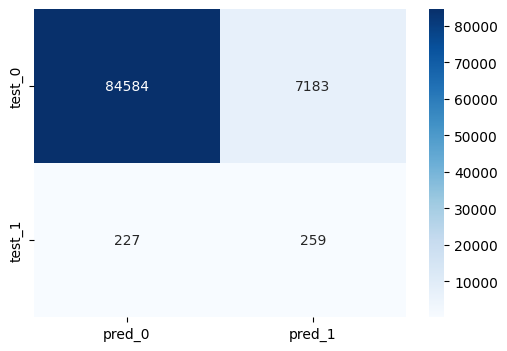

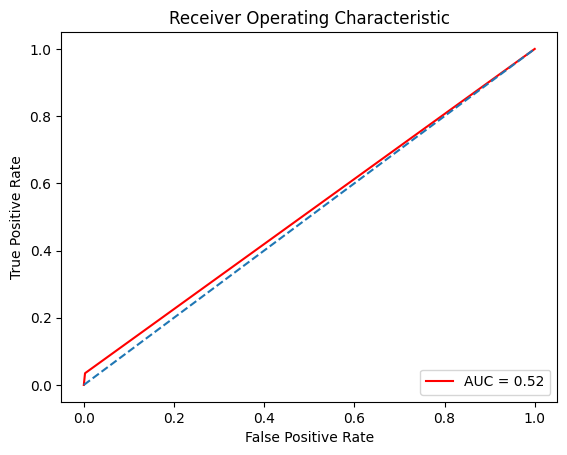

Prediction for :  TARGET


___Model___  __ROC-AUC__  __F-score Beta = 2__  __Recall__  Precision  \
0       LightGBM_7        0.531                 0.076       0.062      0.884   
0       LightGBM_8        0.523                 0.057       0.046      0.842   
0       LightGBM_4        0.523                 0.057       0.047      0.834   
0       LightGBM_1        0.521                 0.053       0.043      0.811   
0       LightGBM_3        0.521                 0.054       0.043      0.873   
0       LightGBM_5        0.520                 0.049       0.040      0.799   
0       LightGBM_9        0.520                 0.050       0.040      0.845   
0       LightGBM_6        0.520                 0.049       0.040      0.818   
0       LightGBM_0        0.519                 0.048       0.039      0.881   
0      HistBoost_2        0.518                 0.049       0.040      0.554   
0       LightGBM_2        0.518                 0.045       0.036      0.860   
0      HistBoost_1        0.517                 0.044       0.036      0.540   
0      HistBoost_3        0.516                 0.043       0.035      0.533   
0      HistBoost_0        0.515                 0.040       0.033      0.524   
0            Dummy        0.500                 0.000       0.000      0.000   
0  log_reg_SMOTE_1        0.495                 0.301       0.981      0.080   
0  log_reg_SMOTE_2        0.495                 0.301       0.981      0.080   
0        log_reg_3        0.494                 0.301       0.980      0.080   
0        log_reg_2        0.493                 0.300       0.972      0.080   
0  log_reg_SMOTE_3        0.493                 0.300       0.976      0.080   
0  log_reg_SMOTE_4        0.492                 0.299       0.970      0.079   
0        log_reg_1        0.489                 0.297       0.960      0.079   
0  log_reg_SMOTE_0        0.488                 0.296       0.943      0.079   
0        log_reg_4        0.481                 0.288       0.894      0.078   
0        log_reg_0        0.479                 0.285       0.872      0.077   

   F1-score  F1-score weighted  Accuracy  
0     0.116              0.892     0.924  
0     0.087              0.889     0.922  
0     0.088              0.889     0.922  
0     0.081              0.888     0.922  
0     0.083              0.889     0.922  
0     0.076              0.888     0.922  
0     0.077              0.888     0.922  
0     0.076              0.888     0.922  
0     0.075              0.888     0.922  
0     0.074              0.887     0.920  
0     0.070              0.887     0.922  
0     0.067              0.886     0.920  
0     0.065              0.886     0.920  
0     0.062              0.886     0.920  
0     0.000              0.881     0.919  
0     0.148              0.028     0.087  
0     0.148              0.028     0.087  
0     0.148              0.026     0.086  
0     0.147              0.036     0.091  
0     0.147              0.031     0.088  
0     0.147              0.038     0.091  
0     0.146              0.044     0.094  
0     0.146              0.071     0.107  
0     0.143              0.128     0.135  
0     0.142              0.155     0.149

Loading HistBoost
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     84811
           1       0.54      0.04      0.07      7442

    accuracy                           0.92     92253
   macro avg       0.73      0.52      0.51     92253
weighted avg       0.89      0.92      0.89     92253

ROC-AUC 0.517


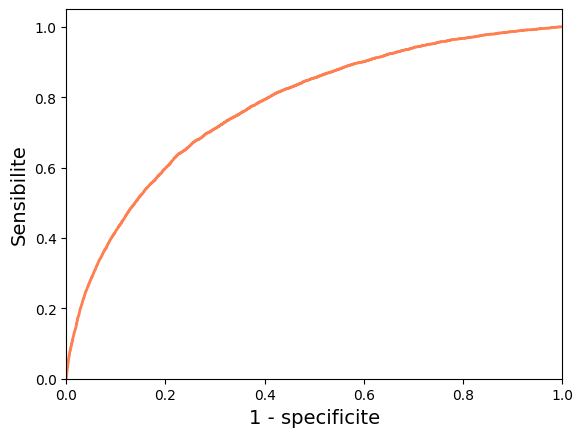

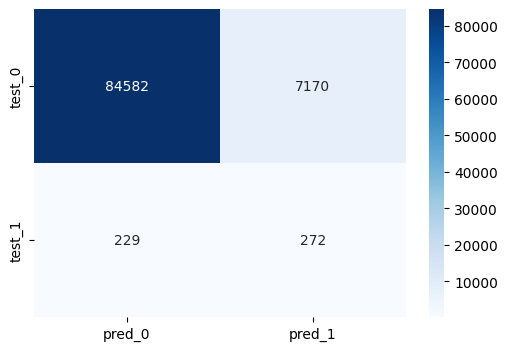

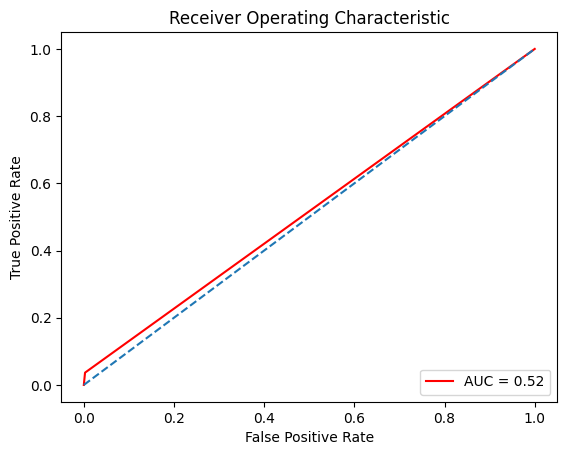

Prediction for :  TARGET


___Model___  __ROC-AUC__  __F-score Beta = 2__  __Recall__  Precision  \
0       LightGBM_7        0.531                 0.076       0.062      0.884   
0       LightGBM_8        0.523                 0.057       0.046      0.842   
0       LightGBM_4        0.523                 0.057       0.047      0.834   
0       LightGBM_1        0.521                 0.053       0.043      0.811   
0       LightGBM_3        0.521                 0.054       0.043      0.873   
0       LightGBM_5        0.520                 0.049       0.040      0.799   
0       LightGBM_9        0.520                 0.050       0.040      0.845   
0       LightGBM_6        0.520                 0.049       0.040      0.818   
0       LightGBM_0        0.519                 0.048       0.039      0.881   
0      HistBoost_2        0.518                 0.049       0.040      0.554   
0       LightGBM_2        0.518                 0.045       0.036      0.860   
0      HistBoost_4        0.517                 0.045       0.037      0.543   
0      HistBoost_1        0.517                 0.044       0.036      0.540   
0      HistBoost_3        0.516                 0.043       0.035      0.533   
0      HistBoost_0        0.515                 0.040       0.033      0.524   
0            Dummy        0.500                 0.000       0.000      0.000   
0  log_reg_SMOTE_1        0.495                 0.301       0.981      0.080   
0  log_reg_SMOTE_2        0.495                 0.301       0.981      0.080   
0        log_reg_3        0.494                 0.301       0.980      0.080   
0        log_reg_2        0.493                 0.300       0.972      0.080   
0  log_reg_SMOTE_3        0.493                 0.300       0.976      0.080   
0  log_reg_SMOTE_4        0.492                 0.299       0.970      0.079   
0        log_reg_1        0.489                 0.297       0.960      0.079   
0  log_reg_SMOTE_0        0.488                 0.296       0.943      0.079   
0        log_reg_4        0.481                 0.288       0.894      0.078   
0        log_reg_0        0.479                 0.285       0.872      0.077   

   F1-score  F1-score weighted  Accuracy  
0     0.116              0.892     0.924  
0     0.087              0.889     0.922  
0     0.088              0.889     0.922  
0     0.081              0.888     0.922  
0     0.083              0.889     0.922  
0     0.076              0.888     0.922  
0     0.077              0.888     0.922  
0     0.076              0.888     0.922  
0     0.075              0.888     0.922  
0     0.074              0.887     0.920  
0     0.070              0.887     0.922  
0     0.068              0.886     0.920  
0     0.067              0.886     0.920  
0     0.065              0.886     0.920  
0     0.062              0.886     0.920  
0     0.000              0.881     0.919  
0     0.148              0.028     0.087  
0     0.148              0.028     0.087  
0     0.148              0.026     0.086  
0     0.147              0.036     0.091  
0     0.147              0.031     0.088  
0     0.147              0.038     0.091  
0     0.146              0.044     0.094  
0     0.146              0.071     0.107  
0     0.143              0.128     0.135  
0     0.142              0.155     0.149

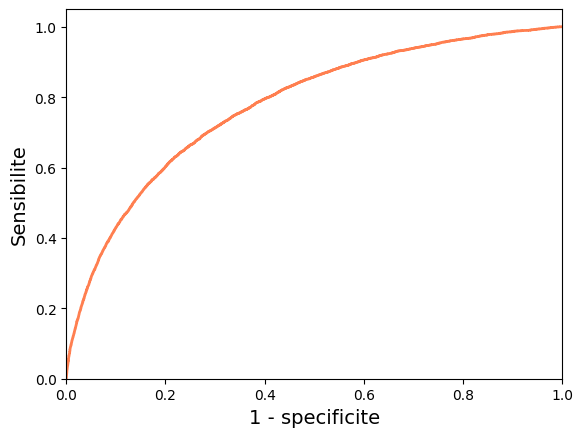

In [70]:
for i in range(5):
    # load model
    print("Loading HistBoost")
    clf = joblib.load('models/HistBoost/HistBoost_fold_{}.joblib'.format(i))

    y_pred = clf.predict(X_test)
    y_pred_proba = clf.predict_proba(X_test)[:, 1] # we take the prediction for the class 1
    evaluate_classification(y_test, y_pred, y_pred_proba=y_pred_proba)
    results = evaluate_models("HistBoost_{}".format(i), results, y_test, y_pred)

##### 3) Training model based on Cross-Validation and SMOTE

In [71]:
histBoost_clf_best_params_SMOTE = HistGradientBoostingClassifier(max_iter=100, max_leaf_nodes=31)
score = evaluate(histBoost_clf_best_params_SMOTE,
                     'HistBoost_SMOTE',
                     X,
                     y,
                     k_fold=5,
                     beta=2,
                     apply_smote=True,
                     smote_params={'k_neighbors':100, 'sampling_strategy':1})
#print(score)

Starting time
Iteration :  0
Starting fit and predict
Saving model with joblib
Iteration :  1
Starting fit and predict
Saving model with joblib
Iteration :  2
Starting fit and predict
Saving model with joblib
Iteration :  3
Starting fit and predict
Saving model with joblib
Iteration :  4
Starting fit and predict
Saving model with joblib
Computing time : 1222.9156789779663 seconds


Loading HistBoost SMOTE
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     84811
           1       0.54      0.03      0.06      7442

    accuracy                           0.92     92253
   macro avg       0.73      0.51      0.51     92253
weighted avg       0.89      0.92      0.89     92253

ROC-AUC 0.514


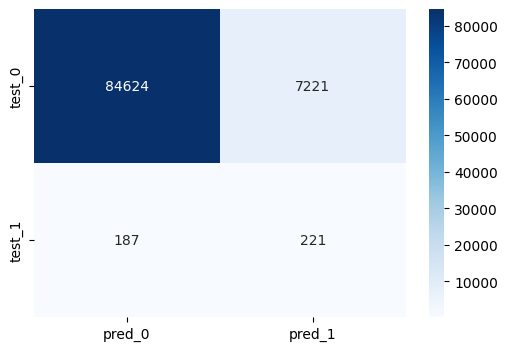

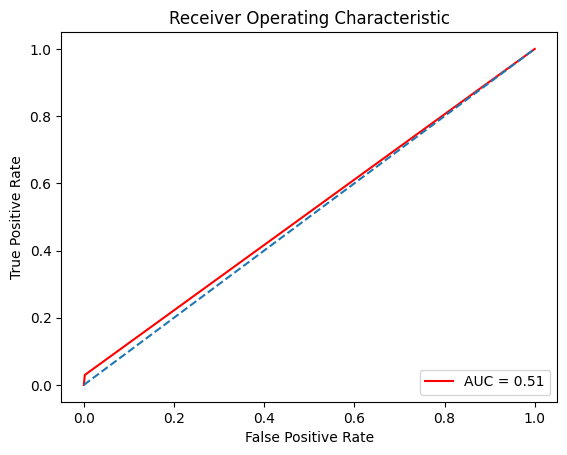

Prediction for :  TARGET


___Model___  __ROC-AUC__  __F-score Beta = 2__  __Recall__  \
0         LightGBM_7        0.531                 0.076       0.062   
0         LightGBM_8        0.523                 0.057       0.046   
0         LightGBM_4        0.523                 0.057       0.047   
0         LightGBM_1        0.521                 0.053       0.043   
0         LightGBM_3        0.521                 0.054       0.043   
0         LightGBM_5        0.520                 0.049       0.040   
0         LightGBM_9        0.520                 0.050       0.040   
0         LightGBM_6        0.520                 0.049       0.040   
0         LightGBM_0        0.519                 0.048       0.039   
0        HistBoost_2        0.518                 0.049       0.040   
0         LightGBM_2        0.518                 0.045       0.036   
0        HistBoost_4        0.517                 0.045       0.037   
0        HistBoost_1        0.517                 0.044       0.036   
0        HistBoost_3        0.516                 0.043       0.035   
0        HistBoost_0        0.515                 0.040       0.033   
0  HistBoost_SMOTE_0        0.514                 0.037       0.030   
0              Dummy        0.500                 0.000       0.000   
0    log_reg_SMOTE_1        0.495                 0.301       0.981   
0    log_reg_SMOTE_2        0.495                 0.301       0.981   
0          log_reg_3        0.494                 0.301       0.980   
0          log_reg_2        0.493                 0.300       0.972   
0    log_reg_SMOTE_3        0.493                 0.300       0.976   
0    log_reg_SMOTE_4        0.492                 0.299       0.970   
0          log_reg_1        0.489                 0.297       0.960   
0    log_reg_SMOTE_0        0.488                 0.296       0.943   
0          log_reg_4        0.481                 0.288       0.894   
0          log_reg_0        0.479                 0.285       0.872   

   Precision  F1-score  F1-score weighted  Accuracy  
0      0.884     0.116              0.892     0.924  
0      0.842     0.087              0.889     0.922  
0      0.834     0.088              0.889     0.922  
0      0.811     0.081              0.888     0.922  
0      0.873     0.083              0.889     0.922  
0      0.799     0.076              0.888     0.922  
0      0.845     0.077              0.888     0.922  
0      0.818     0.076              0.888     0.922  
0      0.881     0.075              0.888     0.922  
0      0.554     0.074              0.887     0.920  
0      0.860     0.070              0.887     0.922  
0      0.543     0.068              0.886     0.920  
0      0.540     0.067              0.886     0.920  
0      0.533     0.065              0.886     0.920  
0      0.524     0.062              0.886     0.920  
0      0.542     0.056              0.885     0.920  
0      0.000     0.000              0.881     0.919  
0      0.080     0.148              0.028     0.087  
0      0.080     0.148              0.028     0.087  
0      0.080     0.148              0.026     0.086  
0      0.080     0.147              0.036     0.091  
0      0.080     0.147              0.031     0.088  
0      0.079     0.147              0.038     0.091  
0      0.079     0.146              0.044     0.094  
0      0.079     0.146              0.071     0.107  
0      0.078     0.143              0.128     0.135  
0      0.077     0.142              0.155     0.149

Loading HistBoost SMOTE
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     84811
           1       0.53      0.03      0.06      7442

    accuracy                           0.92     92253
   macro avg       0.73      0.52      0.51     92253
weighted avg       0.89      0.92      0.89     92253

ROC-AUC 0.515


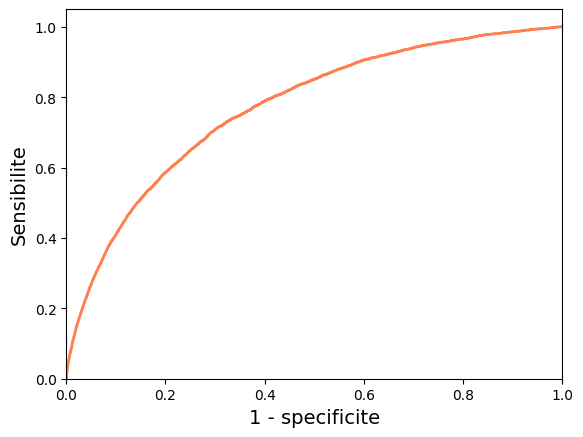

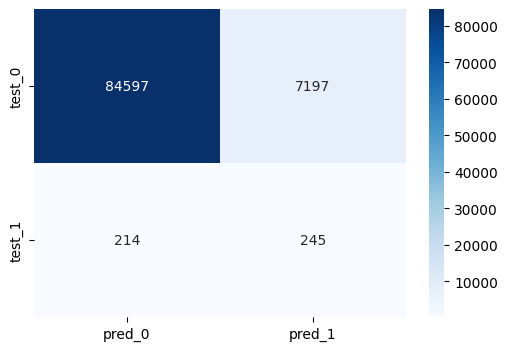

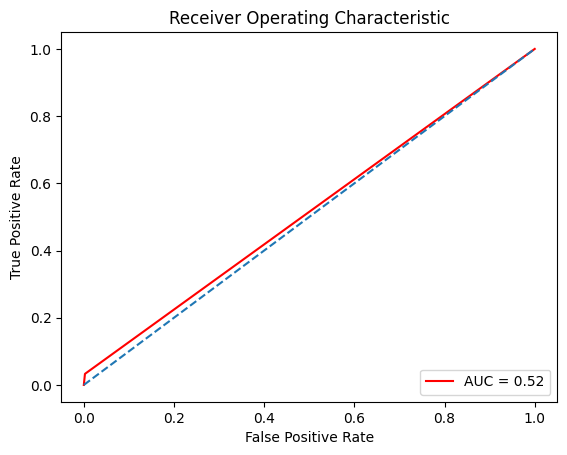

Prediction for :  TARGET


___Model___  __ROC-AUC__  __F-score Beta = 2__  __Recall__  \
0         LightGBM_7        0.531                 0.076       0.062   
0         LightGBM_8        0.523                 0.057       0.046   
0         LightGBM_4        0.523                 0.057       0.047   
0         LightGBM_1        0.521                 0.053       0.043   
0         LightGBM_3        0.521                 0.054       0.043   
0         LightGBM_5        0.520                 0.049       0.040   
0         LightGBM_9        0.520                 0.050       0.040   
0         LightGBM_6        0.520                 0.049       0.040   
0         LightGBM_0        0.519                 0.048       0.039   
0        HistBoost_2        0.518                 0.049       0.040   
0         LightGBM_2        0.518                 0.045       0.036   
0        HistBoost_4        0.517                 0.045       0.037   
0        HistBoost_1        0.517                 0.044       0.036   
0        HistBoost_3        0.516                 0.043       0.035   
0        HistBoost_0        0.515                 0.040       0.033   
0  HistBoost_SMOTE_1        0.515                 0.041       0.033   
0  HistBoost_SMOTE_0        0.514                 0.037       0.030   
0              Dummy        0.500                 0.000       0.000   
0    log_reg_SMOTE_1        0.495                 0.301       0.981   
0    log_reg_SMOTE_2        0.495                 0.301       0.981   
0          log_reg_3        0.494                 0.301       0.980   
0          log_reg_2        0.493                 0.300       0.972   
0    log_reg_SMOTE_3        0.493                 0.300       0.976   
0    log_reg_SMOTE_4        0.492                 0.299       0.970   
0          log_reg_1        0.489                 0.297       0.960   
0    log_reg_SMOTE_0        0.488                 0.296       0.943   
0          log_reg_4        0.481                 0.288       0.894   
0          log_reg_0        0.479                 0.285       0.872   

   Precision  F1-score  F1-score weighted  Accuracy  
0      0.884     0.116              0.892     0.924  
0      0.842     0.087              0.889     0.922  
0      0.834     0.088              0.889     0.922  
0      0.811     0.081              0.888     0.922  
0      0.873     0.083              0.889     0.922  
0      0.799     0.076              0.888     0.922  
0      0.845     0.077              0.888     0.922  
0      0.818     0.076              0.888     0.922  
0      0.881     0.075              0.888     0.922  
0      0.554     0.074              0.887     0.920  
0      0.860     0.070              0.887     0.922  
0      0.543     0.068              0.886     0.920  
0      0.540     0.067              0.886     0.920  
0      0.533     0.065              0.886     0.920  
0      0.524     0.062              0.886     0.920  
0      0.534     0.062              0.886     0.920  
0      0.542     0.056              0.885     0.920  
0      0.000     0.000              0.881     0.919  
0      0.080     0.148              0.028     0.087  
0      0.080     0.148              0.028     0.087  
0      0.080     0.148              0.026     0.086  
0      0.080     0.147              0.036     0.091  
0      0.080     0.147              0.031     0.088  
0      0.079     0.147              0.038     0.091  
0      0.079     0.146              0.044     0.094  
0      0.079     0.146              0.071     0.107  
0      0.078     0.143              0.128     0.135  
0      0.077     0.142              0.155     0.149

Loading HistBoost SMOTE
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     84811
           1       0.54      0.03      0.06      7442

    accuracy                           0.92     92253
   macro avg       0.73      0.52      0.51     92253
weighted avg       0.89      0.92      0.89     92253

ROC-AUC 0.516


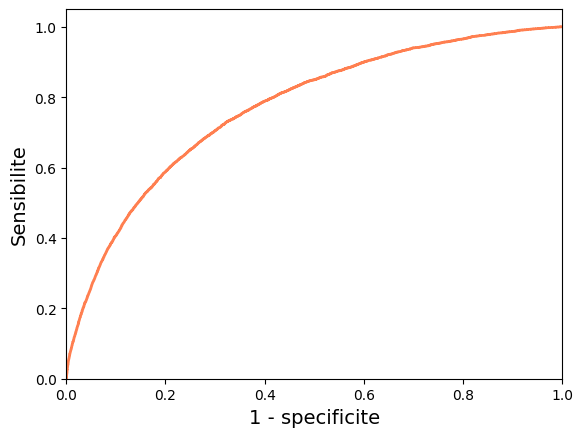

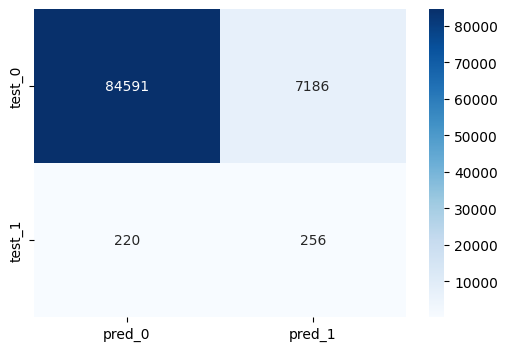

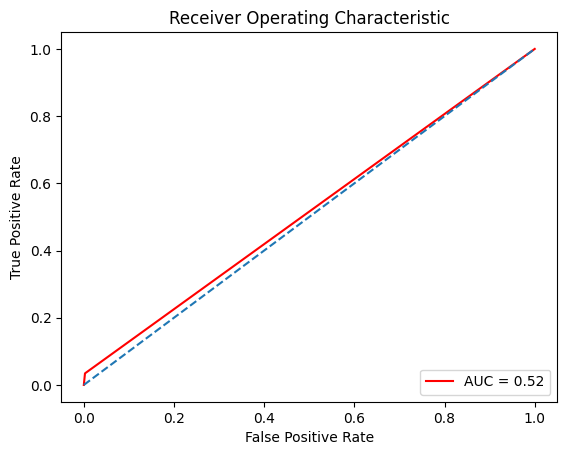

Prediction for :  TARGET


___Model___  __ROC-AUC__  __F-score Beta = 2__  __Recall__  \
0         LightGBM_7        0.531                 0.076       0.062   
0         LightGBM_8        0.523                 0.057       0.046   
0         LightGBM_4        0.523                 0.057       0.047   
0         LightGBM_1        0.521                 0.053       0.043   
0         LightGBM_3        0.521                 0.054       0.043   
0         LightGBM_5        0.520                 0.049       0.040   
0         LightGBM_9        0.520                 0.050       0.040   
0         LightGBM_6        0.520                 0.049       0.040   
0         LightGBM_0        0.519                 0.048       0.039   
0        HistBoost_2        0.518                 0.049       0.040   
0         LightGBM_2        0.518                 0.045       0.036   
0        HistBoost_4        0.517                 0.045       0.037   
0        HistBoost_1        0.517                 0.044       0.036   
0  HistBoost_SMOTE_2        0.516                 0.042       0.034   
0        HistBoost_3        0.516                 0.043       0.035   
0  HistBoost_SMOTE_1        0.515                 0.041       0.033   
0        HistBoost_0        0.515                 0.040       0.033   
0  HistBoost_SMOTE_0        0.514                 0.037       0.030   
0              Dummy        0.500                 0.000       0.000   
0    log_reg_SMOTE_1        0.495                 0.301       0.981   
0    log_reg_SMOTE_2        0.495                 0.301       0.981   
0          log_reg_3        0.494                 0.301       0.980   
0          log_reg_2        0.493                 0.300       0.972   
0    log_reg_SMOTE_3        0.493                 0.300       0.976   
0    log_reg_SMOTE_4        0.492                 0.299       0.970   
0          log_reg_1        0.489                 0.297       0.960   
0    log_reg_SMOTE_0        0.488                 0.296       0.943   
0          log_reg_4        0.481                 0.288       0.894   
0          log_reg_0        0.479                 0.285       0.872   

   Precision  F1-score  F1-score weighted  Accuracy  
0      0.884     0.116              0.892     0.924  
0      0.842     0.087              0.889     0.922  
0      0.834     0.088              0.889     0.922  
0      0.811     0.081              0.888     0.922  
0      0.873     0.083              0.889     0.922  
0      0.799     0.076              0.888     0.922  
0      0.845     0.077              0.888     0.922  
0      0.818     0.076              0.888     0.922  
0      0.881     0.075              0.888     0.922  
0      0.554     0.074              0.887     0.920  
0      0.860     0.070              0.887     0.922  
0      0.543     0.068              0.886     0.920  
0      0.540     0.067              0.886     0.920  
0      0.538     0.065              0.886     0.920  
0      0.533     0.065              0.886     0.920  
0      0.534     0.062              0.886     0.920  
0      0.524     0.062              0.886     0.920  
0      0.542     0.056              0.885     0.920  
0      0.000     0.000              0.881     0.919  
0      0.080     0.148              0.028     0.087  
0      0.080     0.148              0.028     0.087  
0      0.080     0.148              0.026     0.086  
0      0.080     0.147              0.036     0.091  
0      0.080     0.147              0.031     0.088  
0      0.079     0.147              0.038     0.091  
0      0.079     0.146              0.044     0.094  
0      0.079     0.146              0.071     0.107  
0      0.078     0.143              0.128     0.135  
0      0.077     0.142              0.155     0.149

Loading HistBoost SMOTE
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     84811
           1       0.48      0.03      0.06      7442

    accuracy                           0.92     92253
   macro avg       0.70      0.51      0.51     92253
weighted avg       0.89      0.92      0.88     92253

ROC-AUC 0.513


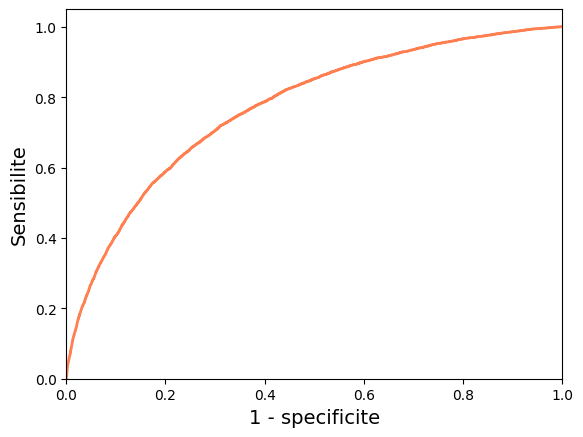

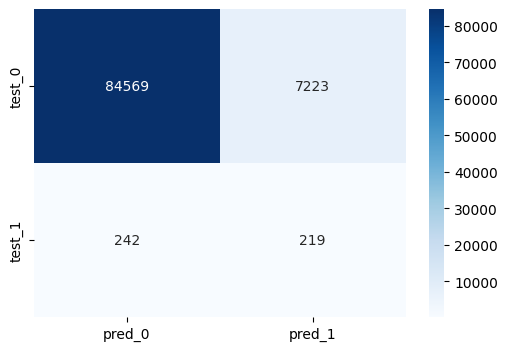

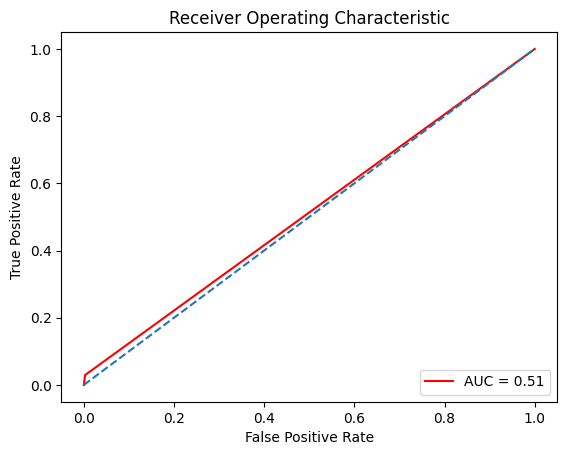

Prediction for :  TARGET


___Model___  __ROC-AUC__  __F-score Beta = 2__  __Recall__  \
0         LightGBM_7        0.531                 0.076       0.062   
0         LightGBM_4        0.523                 0.057       0.047   
0         LightGBM_8        0.523                 0.057       0.046   
0         LightGBM_1        0.521                 0.053       0.043   
0         LightGBM_3        0.521                 0.054       0.043   
0         LightGBM_5        0.520                 0.049       0.040   
0         LightGBM_9        0.520                 0.050       0.040   
0         LightGBM_6        0.520                 0.049       0.040   
0         LightGBM_0        0.519                 0.048       0.039   
0        HistBoost_2        0.518                 0.049       0.040   
0         LightGBM_2        0.518                 0.045       0.036   
0        HistBoost_4        0.517                 0.045       0.037   
0        HistBoost_1        0.517                 0.044       0.036   
0  HistBoost_SMOTE_2        0.516                 0.042       0.034   
0        HistBoost_3        0.516                 0.043       0.035   
0        HistBoost_0        0.515                 0.040       0.033   
0  HistBoost_SMOTE_1        0.515                 0.041       0.033   
0  HistBoost_SMOTE_0        0.514                 0.037       0.030   
0  HistBoost_SMOTE_3        0.513                 0.036       0.029   
0              Dummy        0.500                 0.000       0.000   
0    log_reg_SMOTE_1        0.495                 0.301       0.981   
0    log_reg_SMOTE_2        0.495                 0.301       0.981   
0          log_reg_3        0.494                 0.301       0.980   
0          log_reg_2        0.493                 0.300       0.972   
0    log_reg_SMOTE_3        0.493                 0.300       0.976   
0    log_reg_SMOTE_4        0.492                 0.299       0.970   
0          log_reg_1        0.489                 0.297       0.960   
0    log_reg_SMOTE_0        0.488                 0.296       0.943   
0          log_reg_4        0.481                 0.288       0.894   
0          log_reg_0        0.479                 0.285       0.872   

   Precision  F1-score  F1-score weighted  Accuracy  
0      0.884     0.116              0.892     0.924  
0      0.834     0.088              0.889     0.922  
0      0.842     0.087              0.889     0.922  
0      0.811     0.081              0.888     0.922  
0      0.873     0.083              0.889     0.922  
0      0.799     0.076              0.888     0.922  
0      0.845     0.077              0.888     0.922  
0      0.818     0.076              0.888     0.922  
0      0.881     0.075              0.888     0.922  
0      0.554     0.074              0.887     0.920  
0      0.860     0.070              0.887     0.922  
0      0.543     0.068              0.886     0.920  
0      0.540     0.067              0.886     0.920  
0      0.538     0.065              0.886     0.920  
0      0.533     0.065              0.886     0.920  
0      0.524     0.062              0.886     0.920  
0      0.534     0.062              0.886     0.920  
0      0.542     0.056              0.885     0.920  
0      0.475     0.055              0.885     0.919  
0      0.000     0.000              0.881     0.919  
0      0.080     0.148              0.028     0.087  
0      0.080     0.148              0.028     0.087  
0      0.080     0.148              0.026     0.086  
0      0.080     0.147              0.036     0.091  
0      0.080     0.147              0.031     0.088  
0      0.079     0.147              0.038     0.091  
0      0.079     0.146              0.044     0.094  
0      0.079     0.146              0.071     0.107  
0      0.078     0.143              0.128     0.135  
0      0.077     0.142              0.155     0.149

Loading HistBoost SMOTE
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     84811
           1       0.53      0.03      0.06      7442

    accuracy                           0.92     92253
   macro avg       0.72      0.51      0.51     92253
weighted avg       0.89      0.92      0.89     92253

ROC-AUC 0.515


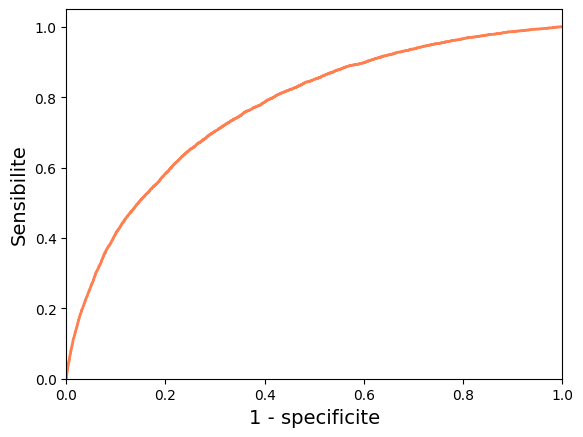

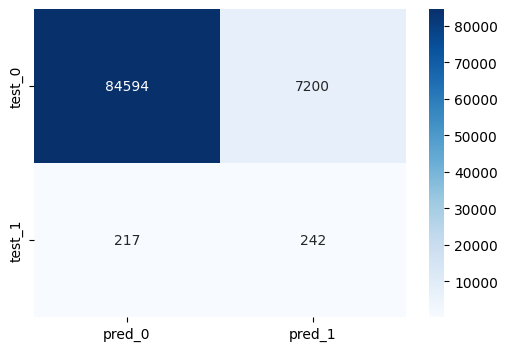

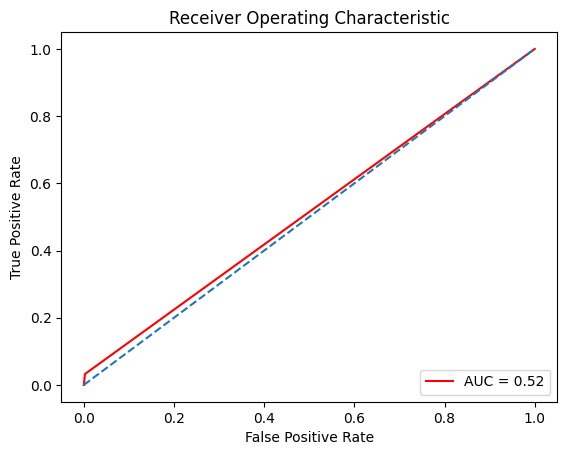

Prediction for :  TARGET


___Model___  __ROC-AUC__  __F-score Beta = 2__  __Recall__  \
0         LightGBM_7        0.531                 0.076       0.062   
0         LightGBM_8        0.523                 0.057       0.046   
0         LightGBM_4        0.523                 0.057       0.047   
0         LightGBM_1        0.521                 0.053       0.043   
0         LightGBM_3        0.521                 0.054       0.043   
0         LightGBM_5        0.520                 0.049       0.040   
0         LightGBM_9        0.520                 0.050       0.040   
0         LightGBM_6        0.520                 0.049       0.040   
0         LightGBM_0        0.519                 0.048       0.039   
0        HistBoost_2        0.518                 0.049       0.040   
0         LightGBM_2        0.518                 0.045       0.036   
0        HistBoost_4        0.517                 0.045       0.037   
0        HistBoost_1        0.517                 0.044       0.036   
0  HistBoost_SMOTE_2        0.516                 0.042       0.034   
0        HistBoost_3        0.516                 0.043       0.035   
0  HistBoost_SMOTE_1        0.515                 0.041       0.033   
0        HistBoost_0        0.515                 0.040       0.033   
0  HistBoost_SMOTE_4        0.515                 0.040       0.033   
0  HistBoost_SMOTE_0        0.514                 0.037       0.030   
0  HistBoost_SMOTE_3        0.513                 0.036       0.029   
0              Dummy        0.500                 0.000       0.000   
0    log_reg_SMOTE_1        0.495                 0.301       0.981   
0    log_reg_SMOTE_2        0.495                 0.301       0.981   
0          log_reg_3        0.494                 0.301       0.980   
0          log_reg_2        0.493                 0.300       0.972   
0    log_reg_SMOTE_3        0.493                 0.300       0.976   
0    log_reg_SMOTE_4        0.492                 0.299       0.970   
0          log_reg_1        0.489                 0.297       0.960   
0    log_reg_SMOTE_0        0.488                 0.296       0.943   
0          log_reg_4        0.481                 0.288       0.894   
0          log_reg_0        0.479                 0.285       0.872   

   Precision  F1-score  F1-score weighted  Accuracy  
0      0.884     0.116              0.892     0.924  
0      0.842     0.087              0.889     0.922  
0      0.834     0.088              0.889     0.922  
0      0.811     0.081              0.888     0.922  
0      0.873     0.083              0.889     0.922  
0      0.799     0.076              0.888     0.922  
0      0.845     0.077              0.888     0.922  
0      0.818     0.076              0.888     0.922  
0      0.881     0.075              0.888     0.922  
0      0.554     0.074              0.887     0.920  
0      0.860     0.070              0.887     0.922  
0      0.543     0.068              0.886     0.920  
0      0.540     0.067              0.886     0.920  
0      0.538     0.065              0.886     0.920  
0      0.533     0.065              0.886     0.920  
0      0.534     0.062              0.886     0.920  
0      0.524     0.062              0.886     0.920  
0      0.527     0.061              0.886     0.920  
0      0.542     0.056              0.885     0.920  
0      0.475     0.055              0.885     0.919  
0      0.000     0.000              0.881     0.919  
0      0.080     0.148              0.028     0.087  
0      0.080     0.148              0.028     0.087  
0      0.080     0.148              0.026     0.086  
0      0.080     0.147              0.036     0.091  
0      0.080     0.147              0.031     0.088  
0      0.079     0.147              0.038     0.091  
0      0.079     0.146              0.044     0.094  
0      0.079     0.146              0.071     0.107  
0      0.078     0.143              0.128     0.135  
0      0.077     0.142              0.155     0.149

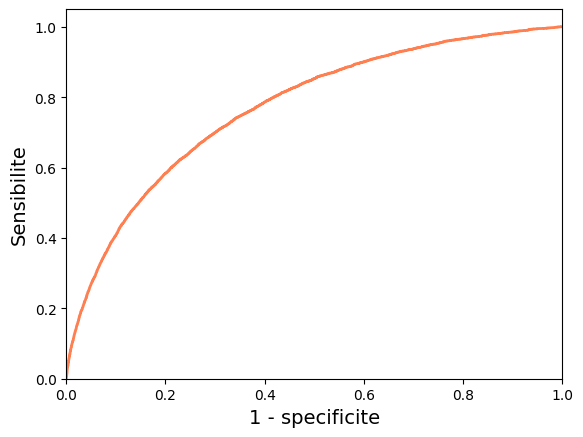

In [72]:
for i in range(5):
    # load model
    print("Loading HistBoost SMOTE")
    clf = joblib.load('models/HistBoost_SMOTE/HistBoost_SMOTE_fold_{}.joblib'.format(i))

    y_pred = clf.predict(X_test)
    y_pred_proba = clf.predict_proba(X_test)[:, 1] # we take the prediction for the class 1
    evaluate_classification(y_test, y_pred, y_pred_proba=y_pred_proba)
    results = evaluate_models("HistBoost_SMOTE_{}".format(i), results, y_test, y_pred)

#### Random Forest

##### 1) Training model based on Cross-Validation

In [73]:
rf = RandomForestClassifier(class_weight='balanced')
scores = evaluate(rf, 'RFC', X, y, k_fold=5, beta=2)
#display(scores)

Starting time
Iteration :  0
Starting fit and predict
Saving model with joblib
Iteration :  1
Starting fit and predict
Saving model with joblib
Iteration :  2
Starting fit and predict
Saving model with joblib
Iteration :  3
Starting fit and predict
Saving model with joblib
Iteration :  4
Starting fit and predict
Saving model with joblib
Computing time : 1204.0503833293915 seconds


Loading Random Forest
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     84811
           1       0.61      0.00      0.00      7442

    accuracy                           0.92     92253
   macro avg       0.76      0.50      0.48     92253
weighted avg       0.89      0.92      0.88     92253

ROC-AUC 0.501


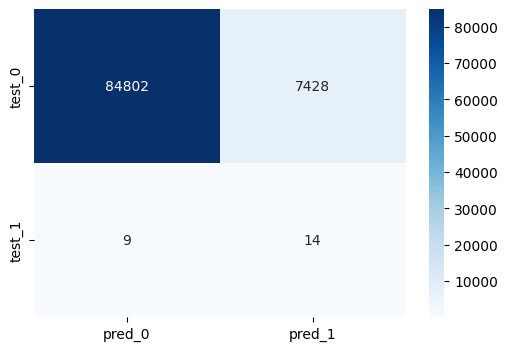

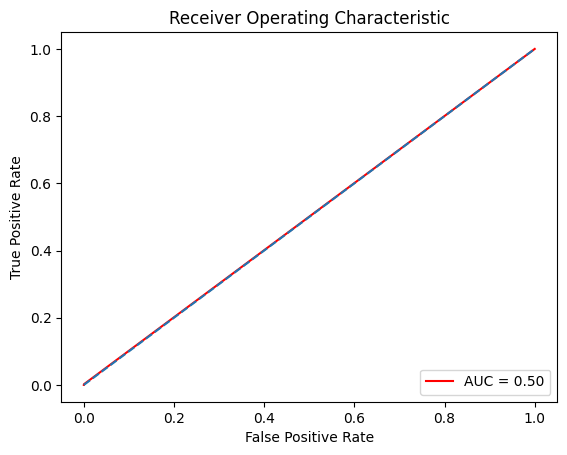

Prediction for :  TARGET


___Model___  __ROC-AUC__  __F-score Beta = 2__  __Recall__  \
0         LightGBM_7        0.531                 0.076       0.062   
0         LightGBM_8        0.523                 0.057       0.046   
0         LightGBM_4        0.523                 0.057       0.047   
0         LightGBM_1        0.521                 0.053       0.043   
0         LightGBM_3        0.521                 0.054       0.043   
0         LightGBM_5        0.520                 0.049       0.040   
0         LightGBM_9        0.520                 0.050       0.040   
0         LightGBM_6        0.520                 0.049       0.040   
0         LightGBM_0        0.519                 0.048       0.039   
0        HistBoost_2        0.518                 0.049       0.040   
0         LightGBM_2        0.518                 0.045       0.036   
0        HistBoost_4        0.517                 0.045       0.037   
0        HistBoost_1        0.517                 0.044       0.036   
0  HistBoost_SMOTE_2        0.516                 0.042       0.034   
0        HistBoost_3        0.516                 0.043       0.035   
0  HistBoost_SMOTE_4        0.515                 0.040       0.033   
0        HistBoost_0        0.515                 0.040       0.033   
0  HistBoost_SMOTE_1        0.515                 0.041       0.033   
0  HistBoost_SMOTE_0        0.514                 0.037       0.030   
0  HistBoost_SMOTE_3        0.513                 0.036       0.029   
0              RFC_0        0.501                 0.002       0.002   
0              Dummy        0.500                 0.000       0.000   
0    log_reg_SMOTE_1        0.495                 0.301       0.981   
0    log_reg_SMOTE_2        0.495                 0.301       0.981   
0          log_reg_3        0.494                 0.301       0.980   
0          log_reg_2        0.493                 0.300       0.972   
0    log_reg_SMOTE_3        0.493                 0.300       0.976   
0    log_reg_SMOTE_4        0.492                 0.299       0.970   
0          log_reg_1        0.489                 0.297       0.960   
0    log_reg_SMOTE_0        0.488                 0.296       0.943   
0          log_reg_4        0.481                 0.288       0.894   
0          log_reg_0        0.479                 0.285       0.872   

   Precision  F1-score  F1-score weighted  Accuracy  
0      0.884     0.116              0.892     0.924  
0      0.842     0.087              0.889     0.922  
0      0.834     0.088              0.889     0.922  
0      0.811     0.081              0.888     0.922  
0      0.873     0.083              0.889     0.922  
0      0.799     0.076              0.888     0.922  
0      0.845     0.077              0.888     0.922  
0      0.818     0.076              0.888     0.922  
0      0.881     0.075              0.888     0.922  
0      0.554     0.074              0.887     0.920  
0      0.860     0.070              0.887     0.922  
0      0.543     0.068              0.886     0.920  
0      0.540     0.067              0.886     0.920  
0      0.538     0.065              0.886     0.920  
0      0.533     0.065              0.886     0.920  
0      0.527     0.061              0.886     0.920  
0      0.524     0.062              0.886     0.920  
0      0.534     0.062              0.886     0.920  
0      0.542     0.056              0.885     0.920  
0      0.475     0.055              0.885     0.919  
0      0.609     0.004              0.881     0.919  
0      0.000     0.000              0.881     0.919  
0      0.080     0.148              0.028     0.087  
0      0.080     0.148              0.028     0.087  
0      0.080     0.148              0.026     0.086  
0      0.080     0.147              0.036     0.091  
0      0.080     0.147              0.031     0.088  
0      0.079     0.147              0.038     0.091  
0      0.079     0.146              0.044     0.094  
0      0.079     0.146              0.071    

Loading Random Forest
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     84811
           1       0.53      0.00      0.00      7442

    accuracy                           0.92     92253
   macro avg       0.72      0.50      0.48     92253
weighted avg       0.89      0.92      0.88     92253

ROC-AUC 0.501


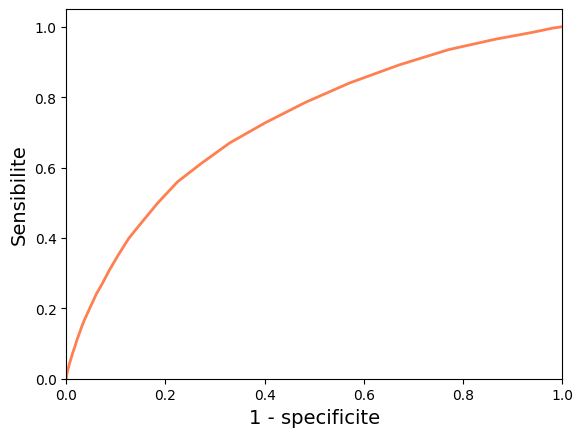

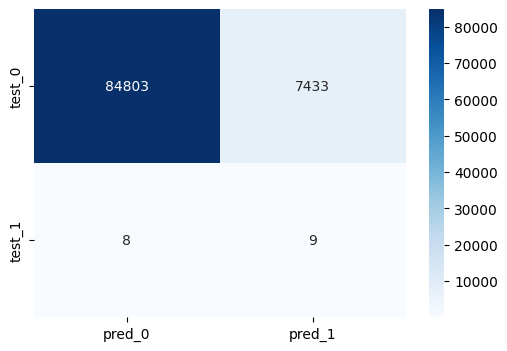

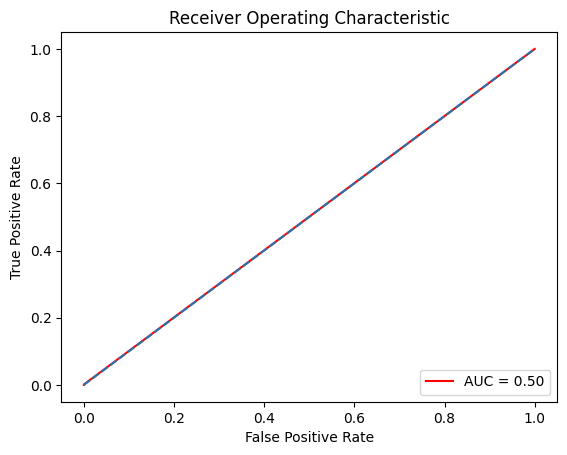

Prediction for :  TARGET


___Model___  __ROC-AUC__  __F-score Beta = 2__  __Recall__  \
0         LightGBM_7        0.531                 0.076       0.062   
0         LightGBM_8        0.523                 0.057       0.046   
0         LightGBM_4        0.523                 0.057       0.047   
0         LightGBM_1        0.521                 0.053       0.043   
0         LightGBM_3        0.521                 0.054       0.043   
0         LightGBM_5        0.520                 0.049       0.040   
0         LightGBM_9        0.520                 0.050       0.040   
0         LightGBM_6        0.520                 0.049       0.040   
0         LightGBM_0        0.519                 0.048       0.039   
0        HistBoost_2        0.518                 0.049       0.040   
0         LightGBM_2        0.518                 0.045       0.036   
0        HistBoost_4        0.517                 0.045       0.037   
0        HistBoost_1        0.517                 0.044       0.036   
0  HistBoost_SMOTE_2        0.516                 0.042       0.034   
0        HistBoost_3        0.516                 0.043       0.035   
0  HistBoost_SMOTE_1        0.515                 0.041       0.033   
0        HistBoost_0        0.515                 0.040       0.033   
0  HistBoost_SMOTE_4        0.515                 0.040       0.033   
0  HistBoost_SMOTE_0        0.514                 0.037       0.030   
0  HistBoost_SMOTE_3        0.513                 0.036       0.029   
0              RFC_0        0.501                 0.002       0.002   
0              RFC_1        0.501                 0.002       0.001   
0              Dummy        0.500                 0.000       0.000   
0    log_reg_SMOTE_1        0.495                 0.301       0.981   
0    log_reg_SMOTE_2        0.495                 0.301       0.981   
0          log_reg_3        0.494                 0.301       0.980   
0          log_reg_2        0.493                 0.300       0.972   
0    log_reg_SMOTE_3        0.493                 0.300       0.976   
0    log_reg_SMOTE_4        0.492                 0.299       0.970   
0          log_reg_1        0.489                 0.297       0.960   
0    log_reg_SMOTE_0        0.488                 0.296       0.943   
0          log_reg_4        0.481                 0.288       0.894   
0          log_reg_0        0.479                 0.285       0.872   

   Precision  F1-score  F1-score weighted  Accuracy  
0      0.884     0.116              0.892     0.924  
0      0.842     0.087              0.889     0.922  
0      0.834     0.088              0.889     0.922  
0      0.811     0.081              0.888     0.922  
0      0.873     0.083              0.889     0.922  
0      0.799     0.076              0.888     0.922  
0      0.845     0.077              0.888     0.922  
0      0.818     0.076              0.888     0.922  
0      0.881     0.075              0.888     0.922  
0      0.554     0.074              0.887     0.920  
0      0.860     0.070              0.887     0.922  
0      0.543     0.068              0.886     0.920  
0      0.540     0.067              0.886     0.920  
0      0.538     0.065              0.886     0.920  
0      0.533     0.065              0.886     0.920  
0      0.534     0.062              0.886     0.920  
0      0.524     0.062              0.886     0.920  
0      0.527     0.061              0.886     0.920  
0      0.542     0.056              0.885     0.920  
0      0.475     0.055              0.885     0.919  
0      0.609     0.004              0.881     0.919  
0      0.529     0.002              0.881     0.919  
0      0.000     0.000              0.881     0.919  
0      0.080     0.148              0.028     0.087  
0      0.080     0.148              0.028     0.087  
0      0.080     0.148              0.026     0.086  
0      0.080     0.147              0.036     0.091  
0      0.080     0.147              0.031     0.088  
0      0.079     0.147      

Loading Random Forest
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     84811
           1       0.68      0.00      0.00      7442

    accuracy                           0.92     92253
   macro avg       0.80      0.50      0.48     92253
weighted avg       0.90      0.92      0.88     92253

ROC-AUC 0.501


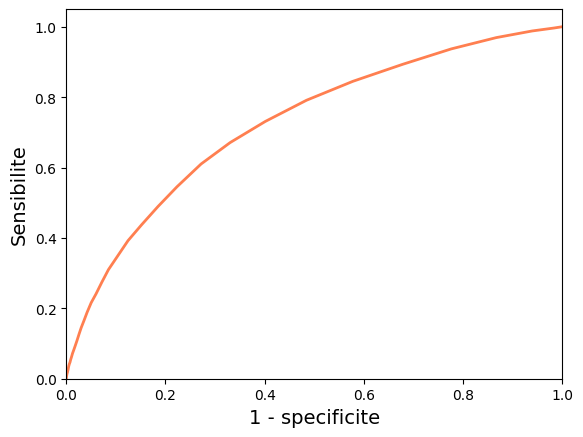

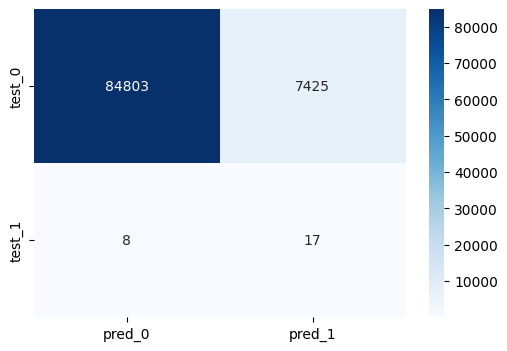

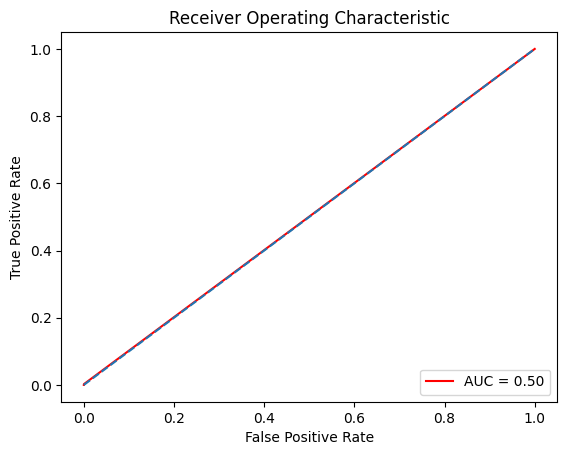

Prediction for :  TARGET


___Model___  __ROC-AUC__  __F-score Beta = 2__  __Recall__  \
0         LightGBM_7        0.531                 0.076       0.062   
0         LightGBM_4        0.523                 0.057       0.047   
0         LightGBM_8        0.523                 0.057       0.046   
0         LightGBM_1        0.521                 0.053       0.043   
0         LightGBM_3        0.521                 0.054       0.043   
0         LightGBM_5        0.520                 0.049       0.040   
0         LightGBM_9        0.520                 0.050       0.040   
0         LightGBM_6        0.520                 0.049       0.040   
0         LightGBM_0        0.519                 0.048       0.039   
0        HistBoost_2        0.518                 0.049       0.040   
0         LightGBM_2        0.518                 0.045       0.036   
0        HistBoost_4        0.517                 0.045       0.037   
0        HistBoost_1        0.517                 0.044       0.036   
0  HistBoost_SMOTE_2        0.516                 0.042       0.034   
0        HistBoost_3        0.516                 0.043       0.035   
0        HistBoost_0        0.515                 0.040       0.033   
0  HistBoost_SMOTE_4        0.515                 0.040       0.033   
0  HistBoost_SMOTE_1        0.515                 0.041       0.033   
0  HistBoost_SMOTE_0        0.514                 0.037       0.030   
0  HistBoost_SMOTE_3        0.513                 0.036       0.029   
0              RFC_1        0.501                 0.002       0.001   
0              RFC_2        0.501                 0.003       0.002   
0              RFC_0        0.501                 0.002       0.002   
0              Dummy        0.500                 0.000       0.000   
0    log_reg_SMOTE_1        0.495                 0.301       0.981   
0    log_reg_SMOTE_2        0.495                 0.301       0.981   
0          log_reg_3        0.494                 0.301       0.980   
0          log_reg_2        0.493                 0.300       0.972   
0    log_reg_SMOTE_3        0.493                 0.300       0.976   
0    log_reg_SMOTE_4        0.492                 0.299       0.970   
0          log_reg_1        0.489                 0.297       0.960   
0    log_reg_SMOTE_0        0.488                 0.296       0.943   
0          log_reg_4        0.481                 0.288       0.894   
0          log_reg_0        0.479                 0.285       0.872   

   Precision  F1-score  F1-score weighted  Accuracy  
0      0.884     0.116              0.892     0.924  
0      0.834     0.088              0.889     0.922  
0      0.842     0.087              0.889     0.922  
0      0.811     0.081              0.888     0.922  
0      0.873     0.083              0.889     0.922  
0      0.799     0.076              0.888     0.922  
0      0.845     0.077              0.888     0.922  
0      0.818     0.076              0.888     0.922  
0      0.881     0.075              0.888     0.922  
0      0.554     0.074              0.887     0.920  
0      0.860     0.070              0.887     0.922  
0      0.543     0.068              0.886     0.920  
0      0.540     0.067              0.886     0.920  
0      0.538     0.065              0.886     0.920  
0      0.533     0.065              0.886     0.920  
0      0.524     0.062              0.886     0.920  
0      0.527     0.061              0.886     0.920  
0      0.534     0.062              0.886     0.920  
0      0.542     0.056              0.885     0.920  
0      0.475     0.055              0.885     0.919  
0      0.529     0.002              0.881     0.919  
0      0.680     0.005              0.881     0.919  
0      0.609     0.004              0.881     0.919  
0      0.000     0.000              0.881     0.919  
0      0.080     0.148              0.028     0.087  
0      0.080     0.148              0.028     0.087  
0      0.080     0.148              0.026     0.086  
0      0.08

Loading Random Forest
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     84811
           1       0.57      0.00      0.00      7442

    accuracy                           0.92     92253
   macro avg       0.74      0.50      0.48     92253
weighted avg       0.89      0.92      0.88     92253

ROC-AUC 0.501


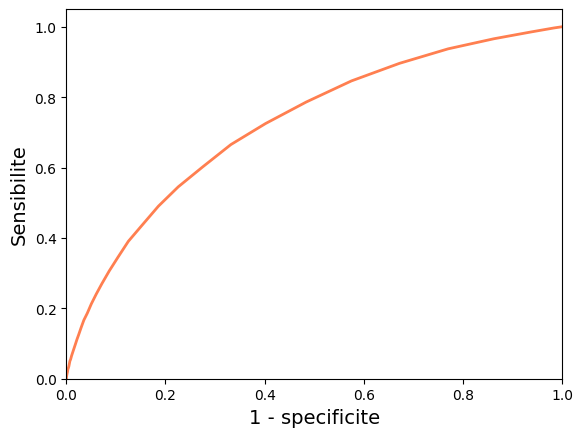

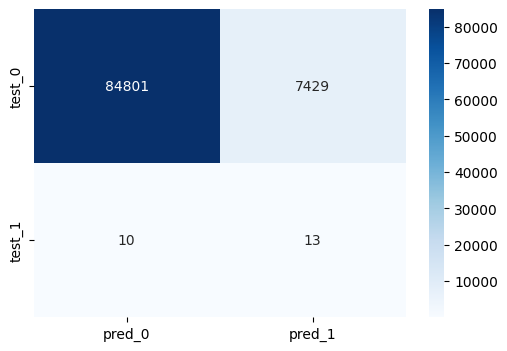

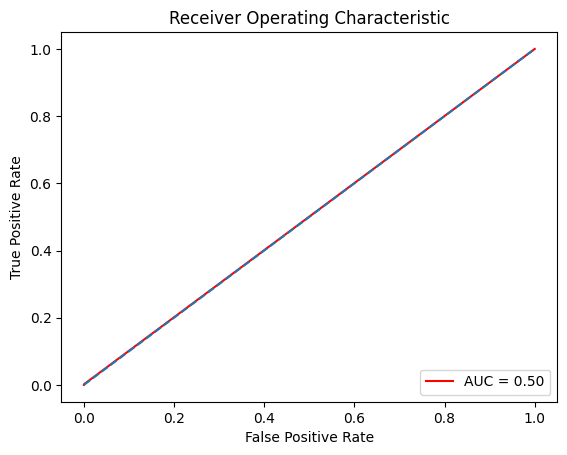

Prediction for :  TARGET


___Model___  __ROC-AUC__  __F-score Beta = 2__  __Recall__  \
0         LightGBM_7        0.531                 0.076       0.062   
0         LightGBM_8        0.523                 0.057       0.046   
0         LightGBM_4        0.523                 0.057       0.047   
0         LightGBM_1        0.521                 0.053       0.043   
0         LightGBM_3        0.521                 0.054       0.043   
0         LightGBM_5        0.520                 0.049       0.040   
0         LightGBM_9        0.520                 0.050       0.040   
0         LightGBM_6        0.520                 0.049       0.040   
0         LightGBM_0        0.519                 0.048       0.039   
0        HistBoost_2        0.518                 0.049       0.040   
0         LightGBM_2        0.518                 0.045       0.036   
0        HistBoost_4        0.517                 0.045       0.037   
0        HistBoost_1        0.517                 0.044       0.036   
0  HistBoost_SMOTE_2        0.516                 0.042       0.034   
0        HistBoost_3        0.516                 0.043       0.035   
0  HistBoost_SMOTE_4        0.515                 0.040       0.033   
0  HistBoost_SMOTE_1        0.515                 0.041       0.033   
0        HistBoost_0        0.515                 0.040       0.033   
0  HistBoost_SMOTE_0        0.514                 0.037       0.030   
0  HistBoost_SMOTE_3        0.513                 0.036       0.029   
0              RFC_0        0.501                 0.002       0.002   
0              RFC_3        0.501                 0.002       0.002   
0              RFC_2        0.501                 0.003       0.002   
0              RFC_1        0.501                 0.002       0.001   
0              Dummy        0.500                 0.000       0.000   
0    log_reg_SMOTE_1        0.495                 0.301       0.981   
0    log_reg_SMOTE_2        0.495                 0.301       0.981   
0          log_reg_3        0.494                 0.301       0.980   
0          log_reg_2        0.493                 0.300       0.972   
0    log_reg_SMOTE_3        0.493                 0.300       0.976   
0    log_reg_SMOTE_4        0.492                 0.299       0.970   
0          log_reg_1        0.489                 0.297       0.960   
0    log_reg_SMOTE_0        0.488                 0.296       0.943   
0          log_reg_4        0.481                 0.288       0.894   
0          log_reg_0        0.479                 0.285       0.872   

   Precision  F1-score  F1-score weighted  Accuracy  
0      0.884     0.116              0.892     0.924  
0      0.842     0.087              0.889     0.922  
0      0.834     0.088              0.889     0.922  
0      0.811     0.081              0.888     0.922  
0      0.873     0.083              0.889     0.922  
0      0.799     0.076              0.888     0.922  
0      0.845     0.077              0.888     0.922  
0      0.818     0.076              0.888     0.922  
0      0.881     0.075              0.888     0.922  
0      0.554     0.074              0.887     0.920  
0      0.860     0.070              0.887     0.922  
0      0.543     0.068              0.886     0.920  
0      0.540     0.067              0.886     0.920  
0      0.538     0.065              0.886     0.920  
0      0.533     0.065              0.886     0.920  
0      0.527     0.061              0.886     0.920  
0      0.534     0.062              0.886     0.920  
0      0.524     0.062              0.886     0.920  
0      0.542     0.056              0.885     0.920  
0      0.475     0.055              0.885     0.919  
0      0.609     0.004              0.881     0.919  
0      0.565     0.003              0.881     0.919  
0      0.680     0.005              0.881     0.919  
0      0.529     0.002              0.881     0.919  
0      0.000     0.000              0.881     0.919  
0      0.080     0.148              0.028     0.

Loading Random Forest
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     84811
           1       0.65      0.00      0.00      7442

    accuracy                           0.92     92253
   macro avg       0.78      0.50      0.48     92253
weighted avg       0.90      0.92      0.88     92253

ROC-AUC 0.501


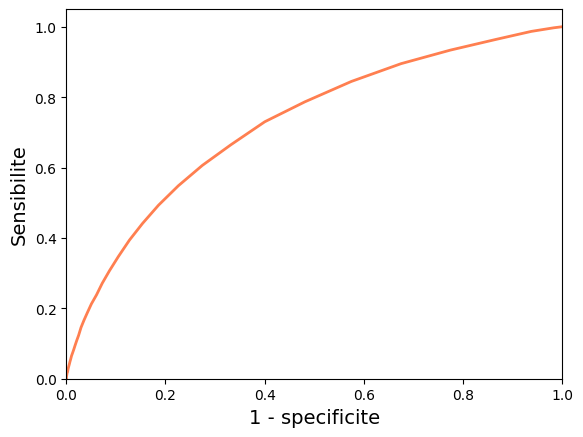

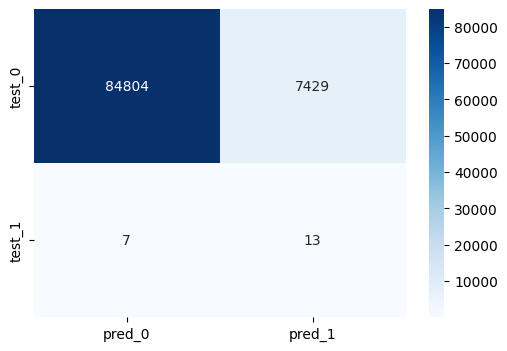

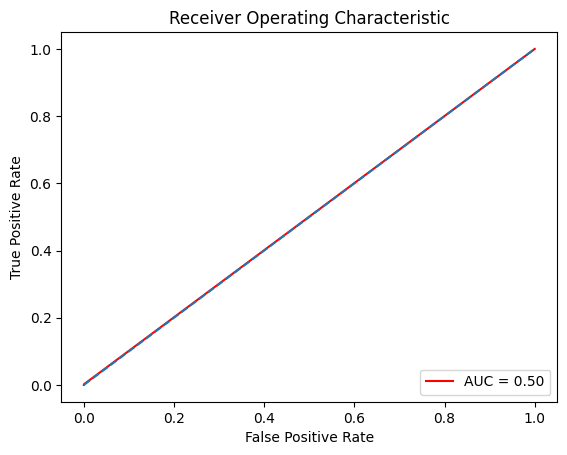

Prediction for :  TARGET


___Model___  __ROC-AUC__  __F-score Beta = 2__  __Recall__  \
0         LightGBM_7        0.531                 0.076       0.062   
0         LightGBM_4        0.523                 0.057       0.047   
0         LightGBM_8        0.523                 0.057       0.046   
0         LightGBM_1        0.521                 0.053       0.043   
0         LightGBM_3        0.521                 0.054       0.043   
0         LightGBM_5        0.520                 0.049       0.040   
0         LightGBM_9        0.520                 0.050       0.040   
0         LightGBM_6        0.520                 0.049       0.040   
0         LightGBM_0        0.519                 0.048       0.039   
0         LightGBM_2        0.518                 0.045       0.036   
0        HistBoost_2        0.518                 0.049       0.040   
0        HistBoost_4        0.517                 0.045       0.037   
0        HistBoost_1        0.517                 0.044       0.036   
0  HistBoost_SMOTE_2        0.516                 0.042       0.034   
0        HistBoost_3        0.516                 0.043       0.035   
0  HistBoost_SMOTE_4        0.515                 0.040       0.033   
0  HistBoost_SMOTE_1        0.515                 0.041       0.033   
0        HistBoost_0        0.515                 0.040       0.033   
0  HistBoost_SMOTE_0        0.514                 0.037       0.030   
0  HistBoost_SMOTE_3        0.513                 0.036       0.029   
0              RFC_1        0.501                 0.002       0.001   
0              RFC_0        0.501                 0.002       0.002   
0              RFC_4        0.501                 0.002       0.002   
0              RFC_2        0.501                 0.003       0.002   
0              RFC_3        0.501                 0.002       0.002   
0              Dummy        0.500                 0.000       0.000   
0    log_reg_SMOTE_1        0.495                 0.301       0.981   
0    log_reg_SMOTE_2        0.495                 0.301       0.981   
0          log_reg_3        0.494                 0.301       0.980   
0          log_reg_2        0.493                 0.300       0.972   
0    log_reg_SMOTE_3        0.493                 0.300       0.976   
0    log_reg_SMOTE_4        0.492                 0.299       0.970   
0          log_reg_1        0.489                 0.297       0.960   
0    log_reg_SMOTE_0        0.488                 0.296       0.943   
0          log_reg_4        0.481                 0.288       0.894   
0          log_reg_0        0.479                 0.285       0.872   

   Precision  F1-score  F1-score weighted  Accuracy  
0      0.884     0.116              0.892     0.924  
0      0.834     0.088              0.889     0.922  
0      0.842     0.087              0.889     0.922  
0      0.811     0.081              0.888     0.922  
0      0.873     0.083              0.889     0.922  
0      0.799     0.076              0.888     0.922  
0      0.845     0.077              0.888     0.922  
0      0.818     0.076              0.888     0.922  
0      0.881     0.075              0.888     0.922  
0      0.860     0.070              0.887     0.922  
0      0.554     0.074              0.887     0.920  
0      0.543     0.068              0.886     0.920  
0      0.540     0.067              0.886     0.920  
0      0.538     0.065              0.886     0.920  
0      0.533     0.065              0.886     0.920  
0      0.527     0.061              0.886     0.920  
0      0.534     0.062              0.886     0.920  
0      0.524     0.062              0.886     0.920  
0      0.542     0.056              0.885     0.920  
0      0.475     0.055              0.885     0.919  
0      0.529     0.002              0.881     0.919  
0      0.609     0.004              0.881     0.919  
0      0.650     0.003              0.881     0.919  
0      0.680     0.005              0.881     0.919  
0      0.565     0.003         

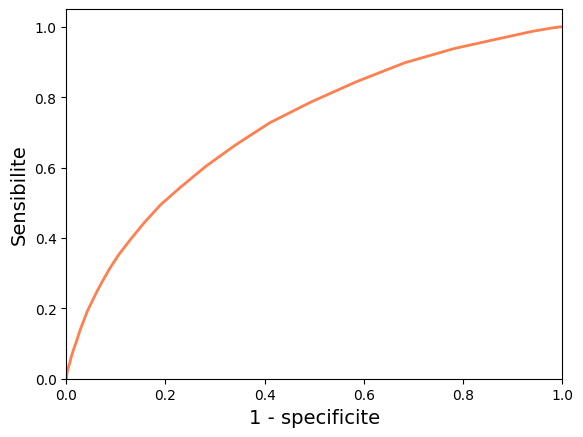

In [80]:
for i in range(5):
    # load model
    print("Loading Random Forest")
    clf = joblib.load('models/RFC/RFC_fold_{}.joblib'.format(i))

    y_pred = clf.predict(X_test)
    y_pred_proba = clf.predict_proba(X_test)[:, 1] # we take the prediction for the class 1
    evaluate_classification(y_test, y_pred, y_pred_proba=y_pred_proba)
    results = evaluate_models("RFC_{}".format(i), results, y_test, y_pred)

##### 2) Training model based on Cross-Validation and SMOTE

In [ ]:
rf_SMOTE = RandomForestClassifier(class_weight='balanced')
scores = evaluate(rf_SMOTE,
                      'RFC_SMOTE',
                      X,
                      y,
                      k_fold=5,
                      beta=2,
                      apply_smote=True,
                      smote_params={'k_neighbors':100, 'sampling_strategy':1})
#display(scores)

Loading Random Forest SMOTE
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     84811
           1       0.48      0.01      0.01      7442

    accuracy                           0.92     92253
   macro avg       0.70      0.50      0.48     92253
weighted avg       0.88      0.92      0.88     92253

ROC-AUC 0.503


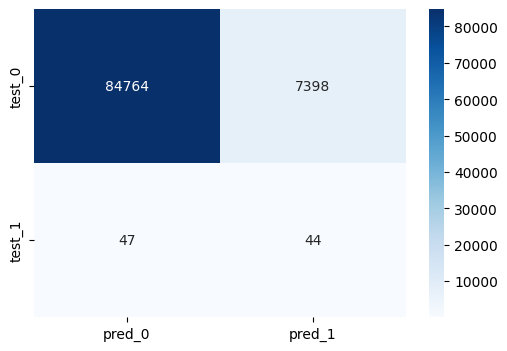

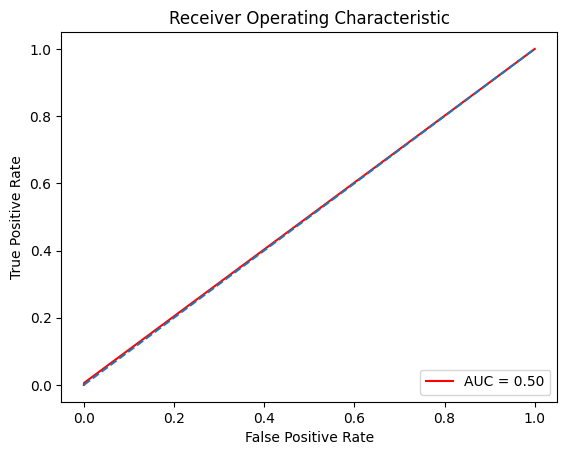

Prediction for :  TARGET


___Model___  __ROC-AUC__  __F-score Beta = 2__  __Recall__  \
0         LightGBM_7        0.531                 0.076       0.062   
0         LightGBM_8        0.523                 0.057       0.046   
0         LightGBM_4        0.523                 0.057       0.047   
0         LightGBM_1        0.521                 0.053       0.043   
0         LightGBM_3        0.521                 0.054       0.043   
0         LightGBM_5        0.520                 0.049       0.040   
0         LightGBM_9        0.520                 0.050       0.040   
0         LightGBM_6        0.520                 0.049       0.040   
0         LightGBM_0        0.519                 0.048       0.039   
0        HistBoost_2        0.518                 0.049       0.040   
0         LightGBM_2        0.518                 0.045       0.036   
0        HistBoost_4        0.517                 0.045       0.037   
0        HistBoost_1        0.517                 0.044       0.036   
0  HistBoost_SMOTE_2        0.516                 0.042       0.034   
0        HistBoost_3        0.516                 0.043       0.035   
0  HistBoost_SMOTE_4        0.515                 0.040       0.033   
0  HistBoost_SMOTE_1        0.515                 0.041       0.033   
0        HistBoost_0        0.515                 0.040       0.033   
0  HistBoost_SMOTE_0        0.514                 0.037       0.030   
0  HistBoost_SMOTE_3        0.513                 0.036       0.029   
0        RFC_SMOTE_0        0.503                 0.007       0.006   
0              RFC_0        0.501                 0.002       0.002   
0              RFC_4        0.501                 0.002       0.002   
0              RFC_2        0.501                 0.003       0.002   
0              RFC_3        0.501                 0.002       0.002   
0              RFC_1        0.501                 0.002       0.001   
0              Dummy        0.500                 0.000       0.000   
0    log_reg_SMOTE_1        0.495                 0.301       0.981   
0    log_reg_SMOTE_2        0.495                 0.301       0.981   
0          log_reg_3        0.494                 0.301       0.980   
0          log_reg_2        0.493                 0.300       0.972   
0    log_reg_SMOTE_3        0.493                 0.300       0.976   
0    log_reg_SMOTE_4        0.492                 0.299       0.970   
0          log_reg_1        0.489                 0.297       0.960   
0    log_reg_SMOTE_0        0.488                 0.296       0.943   
0          log_reg_4        0.481                 0.288       0.894   
0          log_reg_0        0.479                 0.285       0.872   

   Precision  F1-score  F1-score weighted  Accuracy  
0      0.884     0.116              0.892     0.924  
0      0.842     0.087              0.889     0.922  
0      0.834     0.088              0.889     0.922  
0      0.811     0.081              0.888     0.922  
0      0.873     0.083              0.889     0.922  
0      0.799     0.076              0.888     0.922  
0      0.845     0.077              0.888     0.922  
0      0.818     0.076              0.888     0.922  
0      0.881     0.075              0.888     0.922  
0      0.554     0.074              0.887     0.920  
0      0.860     0.070              0.887     0.922  
0      0.543     0.068              0.886     0.920  
0      0.540     0.067              0.886     0.920  
0      0.538     0.065              0.886     0.920  
0      0.533     0.065              0.886     0.920  
0      0.527     0.061              0.886     0.920  
0      0.534     0.062              0.886     0.920  
0      0.524     0.062              0.886     0.920  
0      0.542     0.056              0.885     0.920  
0      0.475     0.055              0.885     0.919  
0      0.484     0.012              0.882     0.919  
0      0.609     0.004              0.881     0.919  
0      0.650     0.003              0.881     0.919  
0      0.680  

Loading Random Forest SMOTE
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     84811
           1       0.49      0.01      0.01      7442

    accuracy                           0.92     92253
   macro avg       0.70      0.50      0.49     92253
weighted avg       0.89      0.92      0.88     92253

ROC-AUC 0.503


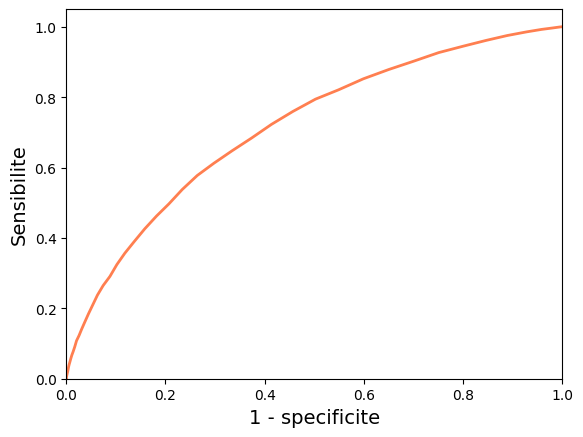

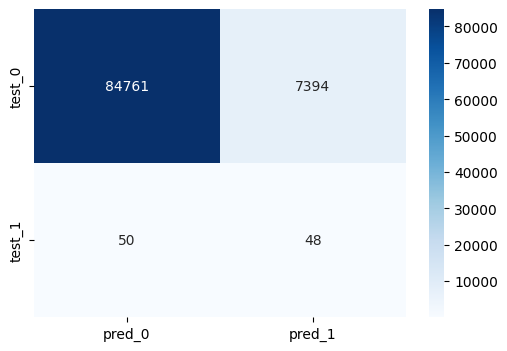

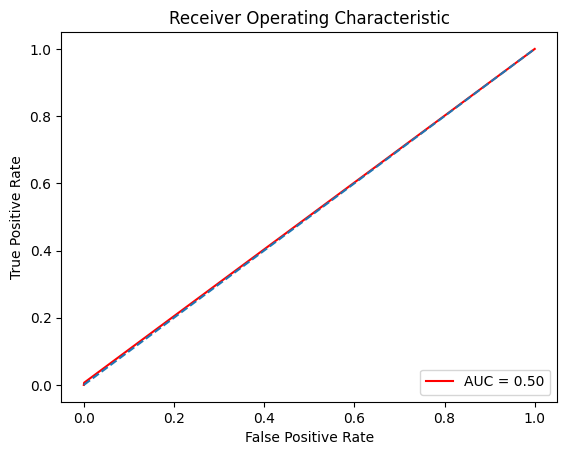

Prediction for :  TARGET


___Model___  __ROC-AUC__  __F-score Beta = 2__  __Recall__  \
0         LightGBM_7        0.531                 0.076       0.062   
0         LightGBM_4        0.523                 0.057       0.047   
0         LightGBM_8        0.523                 0.057       0.046   
0         LightGBM_1        0.521                 0.053       0.043   
0         LightGBM_3        0.521                 0.054       0.043   
0         LightGBM_5        0.520                 0.049       0.040   
0         LightGBM_9        0.520                 0.050       0.040   
0         LightGBM_6        0.520                 0.049       0.040   
0         LightGBM_0        0.519                 0.048       0.039   
0         LightGBM_2        0.518                 0.045       0.036   
0        HistBoost_2        0.518                 0.049       0.040   
0        HistBoost_4        0.517                 0.045       0.037   
0        HistBoost_1        0.517                 0.044       0.036   
0  HistBoost_SMOTE_2        0.516                 0.042       0.034   
0        HistBoost_3        0.516                 0.043       0.035   
0  HistBoost_SMOTE_4        0.515                 0.040       0.033   
0  HistBoost_SMOTE_1        0.515                 0.041       0.033   
0        HistBoost_0        0.515                 0.040       0.033   
0  HistBoost_SMOTE_0        0.514                 0.037       0.030   
0  HistBoost_SMOTE_3        0.513                 0.036       0.029   
0        RFC_SMOTE_0        0.503                 0.007       0.006   
0        RFC_SMOTE_1        0.503                 0.008       0.006   
0              RFC_4        0.501                 0.002       0.002   
0              RFC_2        0.501                 0.003       0.002   
0              RFC_3        0.501                 0.002       0.002   
0              RFC_1        0.501                 0.002       0.001   
0              RFC_0        0.501                 0.002       0.002   
0              Dummy        0.500                 0.000       0.000   
0    log_reg_SMOTE_1        0.495                 0.301       0.981   
0    log_reg_SMOTE_2        0.495                 0.301       0.981   
0          log_reg_3        0.494                 0.301       0.980   
0          log_reg_2        0.493                 0.300       0.972   
0    log_reg_SMOTE_3        0.493                 0.300       0.976   
0    log_reg_SMOTE_4        0.492                 0.299       0.970   
0          log_reg_1        0.489                 0.297       0.960   
0    log_reg_SMOTE_0        0.488                 0.296       0.943   
0          log_reg_4        0.481                 0.288       0.894   
0          log_reg_0        0.479                 0.285       0.872   

   Precision  F1-score  F1-score weighted  Accuracy  
0      0.884     0.116              0.892     0.924  
0      0.834     0.088              0.889     0.922  
0      0.842     0.087              0.889     0.922  
0      0.811     0.081              0.888     0.922  
0      0.873     0.083              0.889     0.922  
0      0.799     0.076              0.888     0.922  
0      0.845     0.077              0.888     0.922  
0      0.818     0.076              0.888     0.922  
0      0.881     0.075              0.888     0.922  
0      0.860     0.070              0.887     0.922  
0      0.554     0.074              0.887     0.920  
0      0.543     0.068              0.886     0.920  
0      0.540     0.067              0.886     0.920  
0      0.538     0.065              0.886     0.920  
0      0.533     0.065              0.886     0.920  
0      0.527     0.061              0.886     0.920  
0      0.534     0.062              0.886     0.920  
0      0.524     0.062              0.886     0.920  
0      0.542     0.056              0.885     0.920  
0      0.475     0.055              0.885     0.919  
0      0.484     0.012              0.882     0.919  
0      0.490     0.013              0.882     0.919

Loading Random Forest SMOTE
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     84811
           1       0.46      0.01      0.01      7442

    accuracy                           0.92     92253
   macro avg       0.69      0.50      0.48     92253
weighted avg       0.88      0.92      0.88     92253

ROC-AUC 0.503


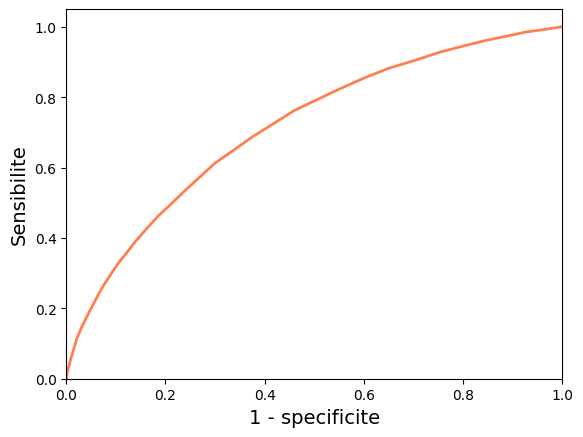

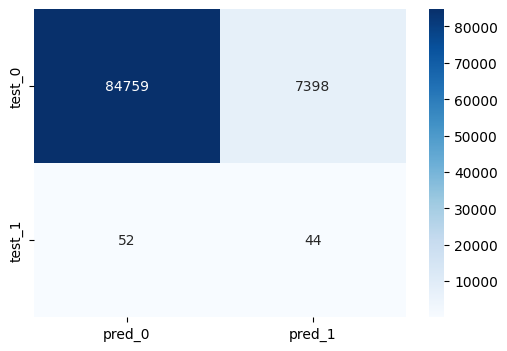

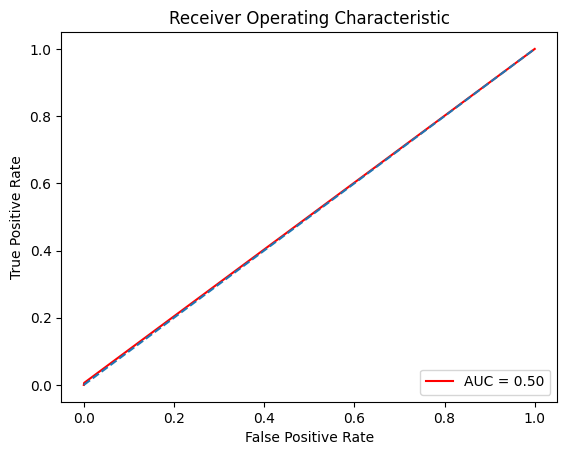

Prediction for :  TARGET


___Model___  __ROC-AUC__  __F-score Beta = 2__  __Recall__  \
0         LightGBM_7        0.531                 0.076       0.062   
0         LightGBM_8        0.523                 0.057       0.046   
0         LightGBM_4        0.523                 0.057       0.047   
0         LightGBM_1        0.521                 0.053       0.043   
0         LightGBM_3        0.521                 0.054       0.043   
0         LightGBM_5        0.520                 0.049       0.040   
0         LightGBM_9        0.520                 0.050       0.040   
0         LightGBM_6        0.520                 0.049       0.040   
0         LightGBM_0        0.519                 0.048       0.039   
0        HistBoost_2        0.518                 0.049       0.040   
0         LightGBM_2        0.518                 0.045       0.036   
0        HistBoost_4        0.517                 0.045       0.037   
0        HistBoost_1        0.517                 0.044       0.036   
0  HistBoost_SMOTE_2        0.516                 0.042       0.034   
0        HistBoost_3        0.516                 0.043       0.035   
0  HistBoost_SMOTE_4        0.515                 0.040       0.033   
0  HistBoost_SMOTE_1        0.515                 0.041       0.033   
0        HistBoost_0        0.515                 0.040       0.033   
0  HistBoost_SMOTE_0        0.514                 0.037       0.030   
0  HistBoost_SMOTE_3        0.513                 0.036       0.029   
0        RFC_SMOTE_0        0.503                 0.007       0.006   
0        RFC_SMOTE_1        0.503                 0.008       0.006   
0        RFC_SMOTE_2        0.503                 0.007       0.006   
0              RFC_2        0.501                 0.003       0.002   
0              RFC_3        0.501                 0.002       0.002   
0              RFC_1        0.501                 0.002       0.001   
0              RFC_0        0.501                 0.002       0.002   
0              RFC_4        0.501                 0.002       0.002   
0              Dummy        0.500                 0.000       0.000   
0    log_reg_SMOTE_1        0.495                 0.301       0.981   
0    log_reg_SMOTE_2        0.495                 0.301       0.981   
0          log_reg_3        0.494                 0.301       0.980   
0          log_reg_2        0.493                 0.300       0.972   
0    log_reg_SMOTE_3        0.493                 0.300       0.976   
0    log_reg_SMOTE_4        0.492                 0.299       0.970   
0          log_reg_1        0.489                 0.297       0.960   
0    log_reg_SMOTE_0        0.488                 0.296       0.943   
0          log_reg_4        0.481                 0.288       0.894   
0          log_reg_0        0.479                 0.285       0.872   

   Precision  F1-score  F1-score weighted  Accuracy  
0      0.884     0.116              0.892     0.924  
0      0.842     0.087              0.889     0.922  
0      0.834     0.088              0.889     0.922  
0      0.811     0.081              0.888     0.922  
0      0.873     0.083              0.889     0.922  
0      0.799     0.076              0.888     0.922  
0      0.845     0.077              0.888     0.922  
0      0.818     0.076              0.888     0.922  
0      0.881     0.075              0.888     0.922  
0      0.554     0.074              0.887     0.920  
0      0.860     0.070              0.887     0.922  
0      0.543     0.068              0.886     0.920  
0      0.540     0.067              0.886     0.920  
0      0.538     0.065              0.886     0.920  
0      0.533     0.065              0.886     0.920  
0      0.527     0.061              0.886     0.920  
0      0.534     0.062              0.886     0.920  
0      0.524     0.062              0.886     0.920  
0      0.542     0.056              0.885     0.920  
0      0.475     0.055              0.885     0.919  
0      0.484     0.012            

Loading Random Forest SMOTE
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     84811
           1       0.52      0.01      0.01      7442

    accuracy                           0.92     92253
   macro avg       0.72      0.50      0.49     92253
weighted avg       0.89      0.92      0.88     92253

ROC-AUC 0.503


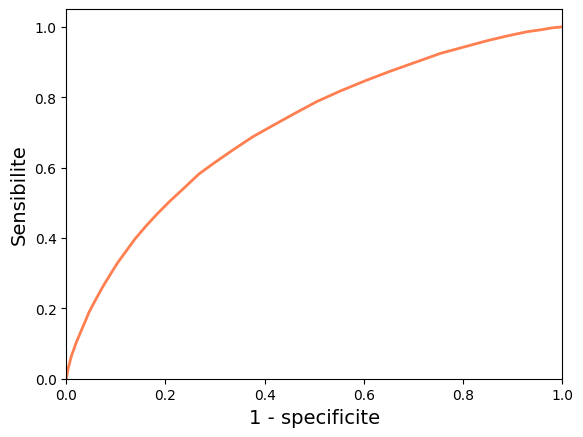

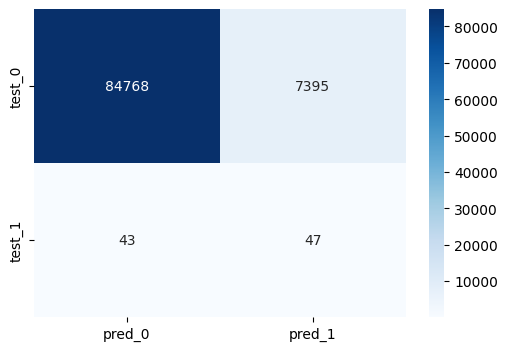

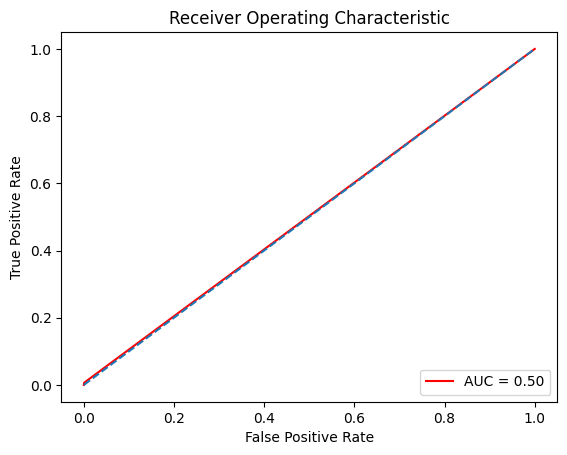

Prediction for :  TARGET


___Model___  __ROC-AUC__  __F-score Beta = 2__  __Recall__  \
0         LightGBM_7        0.531                 0.076       0.062   
0         LightGBM_4        0.523                 0.057       0.047   
0         LightGBM_8        0.523                 0.057       0.046   
0         LightGBM_1        0.521                 0.053       0.043   
0         LightGBM_3        0.521                 0.054       0.043   
0         LightGBM_5        0.520                 0.049       0.040   
0         LightGBM_9        0.520                 0.050       0.040   
0         LightGBM_6        0.520                 0.049       0.040   
0         LightGBM_0        0.519                 0.048       0.039   
0         LightGBM_2        0.518                 0.045       0.036   
0        HistBoost_2        0.518                 0.049       0.040   
0        HistBoost_4        0.517                 0.045       0.037   
0        HistBoost_1        0.517                 0.044       0.036   
0  HistBoost_SMOTE_2        0.516                 0.042       0.034   
0        HistBoost_3        0.516                 0.043       0.035   
0  HistBoost_SMOTE_4        0.515                 0.040       0.033   
0  HistBoost_SMOTE_1        0.515                 0.041       0.033   
0        HistBoost_0        0.515                 0.040       0.033   
0  HistBoost_SMOTE_0        0.514                 0.037       0.030   
0  HistBoost_SMOTE_3        0.513                 0.036       0.029   
0        RFC_SMOTE_2        0.503                 0.007       0.006   
0        RFC_SMOTE_0        0.503                 0.007       0.006   
0        RFC_SMOTE_1        0.503                 0.008       0.006   
0        RFC_SMOTE_3        0.503                 0.008       0.006   
0              RFC_3        0.501                 0.002       0.002   
0              RFC_1        0.501                 0.002       0.001   
0              RFC_0        0.501                 0.002       0.002   
0              RFC_4        0.501                 0.002       0.002   
0              RFC_2        0.501                 0.003       0.002   
0              Dummy        0.500                 0.000       0.000   
0    log_reg_SMOTE_1        0.495                 0.301       0.981   
0    log_reg_SMOTE_2        0.495                 0.301       0.981   
0          log_reg_3        0.494                 0.301       0.980   
0          log_reg_2        0.493                 0.300       0.972   
0    log_reg_SMOTE_3        0.493                 0.300       0.976   
0    log_reg_SMOTE_4        0.492                 0.299       0.970   
0          log_reg_1        0.489                 0.297       0.960   
0    log_reg_SMOTE_0        0.488                 0.296       0.943   
0          log_reg_4        0.481                 0.288       0.894   
0          log_reg_0        0.479                 0.285       0.872   

   Precision  F1-score  F1-score weighted  Accuracy  
0      0.884     0.116              0.892     0.924  
0      0.834     0.088              0.889     0.922  
0      0.842     0.087              0.889     0.922  
0      0.811     0.081              0.888     0.922  
0      0.873     0.083              0.889     0.922  
0      0.799     0.076              0.888     0.922  
0      0.845     0.077              0.888     0.922  
0      0.818     0.076              0.888     0.922  
0      0.881     0.075              0.888     0.922  
0      0.860     0.070              0.887     0.922  
0      0.554     0.074              0.887     0.920  
0      0.543     0.068              0.886     0.920  
0      0.540     0.067              0.886     0.920  
0      0.538     0.065              0.886     0.920  
0      0.533     0.065              0.886     0.920  
0      0.527     0.061              0.886     0.920  
0      0.534     0.062              0.886     0.920  
0      0.524     0.062              0.886     0.920  
0      0.542     0.056              0.885     0.920  
0      0.475     

Loading Random Forest SMOTE
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     84811
           1       0.46      0.01      0.01      7442

    accuracy                           0.92     92253
   macro avg       0.69      0.50      0.48     92253
weighted avg       0.88      0.92      0.88     92253

ROC-AUC 0.503


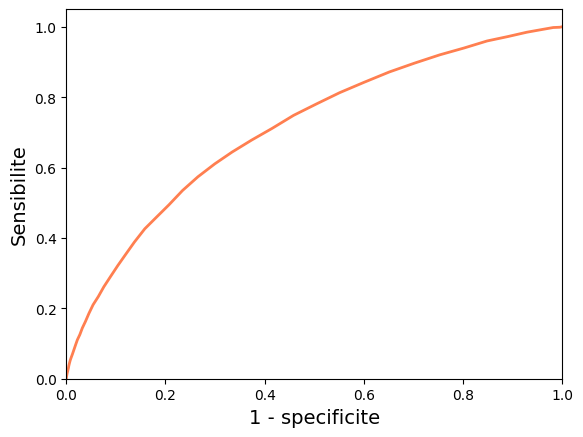

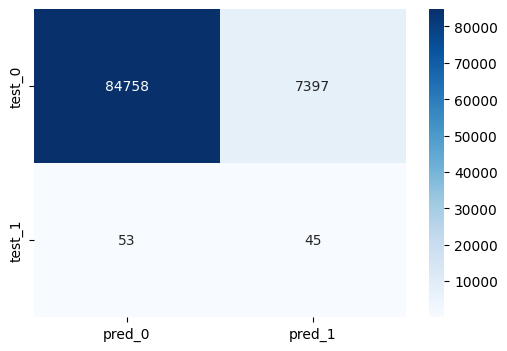

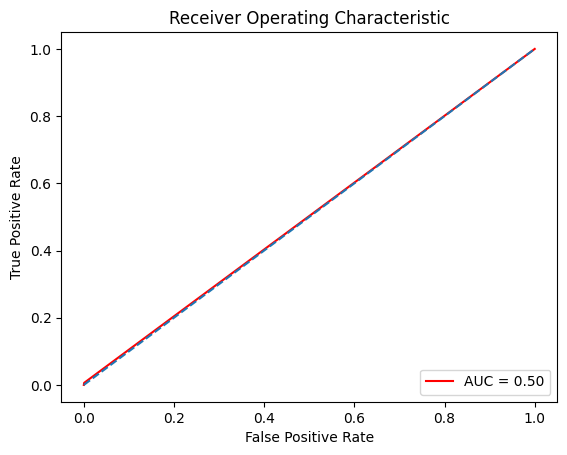

Prediction for :  TARGET


___Model___  __ROC-AUC__  __F-score Beta = 2__  __Recall__  \
0         LightGBM_7        0.531                 0.076       0.062   
0         LightGBM_8        0.523                 0.057       0.046   
0         LightGBM_4        0.523                 0.057       0.047   
0         LightGBM_1        0.521                 0.053       0.043   
0         LightGBM_3        0.521                 0.054       0.043   
0         LightGBM_5        0.520                 0.049       0.040   
0         LightGBM_9        0.520                 0.050       0.040   
0         LightGBM_6        0.520                 0.049       0.040   
0         LightGBM_0        0.519                 0.048       0.039   
0         LightGBM_2        0.518                 0.045       0.036   
0        HistBoost_2        0.518                 0.049       0.040   
0        HistBoost_1        0.517                 0.044       0.036   
0        HistBoost_4        0.517                 0.045       0.037   
0  HistBoost_SMOTE_2        0.516                 0.042       0.034   
0        HistBoost_3        0.516                 0.043       0.035   
0  HistBoost_SMOTE_4        0.515                 0.040       0.033   
0  HistBoost_SMOTE_1        0.515                 0.041       0.033   
0        HistBoost_0        0.515                 0.040       0.033   
0  HistBoost_SMOTE_0        0.514                 0.037       0.030   
0  HistBoost_SMOTE_3        0.513                 0.036       0.029   
0        RFC_SMOTE_1        0.503                 0.008       0.006   
0        RFC_SMOTE_3        0.503                 0.008       0.006   
0        RFC_SMOTE_2        0.503                 0.007       0.006   
0        RFC_SMOTE_0        0.503                 0.007       0.006   
0        RFC_SMOTE_4        0.503                 0.008       0.006   
0              RFC_1        0.501                 0.002       0.001   
0              RFC_0        0.501                 0.002       0.002   
0              RFC_4        0.501                 0.002       0.002   
0              RFC_2        0.501                 0.003       0.002   
0              RFC_3        0.501                 0.002       0.002   
0              Dummy        0.500                 0.000       0.000   
0    log_reg_SMOTE_1        0.495                 0.301       0.981   
0    log_reg_SMOTE_2        0.495                 0.301       0.981   
0          log_reg_3        0.494                 0.301       0.980   
0          log_reg_2        0.493                 0.300       0.972   
0    log_reg_SMOTE_3        0.493                 0.300       0.976   
0    log_reg_SMOTE_4        0.492                 0.299       0.970   
0          log_reg_1        0.489                 0.297       0.960   
0    log_reg_SMOTE_0        0.488                 0.296       0.943   
0          log_reg_4        0.481                 0.288       0.894   
0          log_reg_0        0.479                 0.285       0.872   

   Precision  F1-score  F1-score weighted  Accuracy  
0      0.884     0.116              0.892     0.924  
0      0.842     0.087              0.889     0.922  
0      0.834     0.088              0.889     0.922  
0      0.811     0.081              0.888     0.922  
0      0.873     0.083              0.889     0.922  
0      0.799     0.076              0.888     0.922  
0      0.845     0.077              0.888     0.922  
0      0.818     0.076              0.888     0.922  
0      0.881     0.075              0.888     0.922  
0      0.860     0.070              0.887     0.922  
0      0.554     0.074              0.887     0.920  
0      0.540     0.067              0.886     0.920  
0      0.543     0.068              0.886     0.920  
0      0.538     0.065              0.886     0.920  
0      0.533     0.065              0.886     0.920  
0      0.527     0.061              0.886     0.920  
0      0.534     0.062              0.886     0.920  
0      0.524     0.062              0.886     0.920  


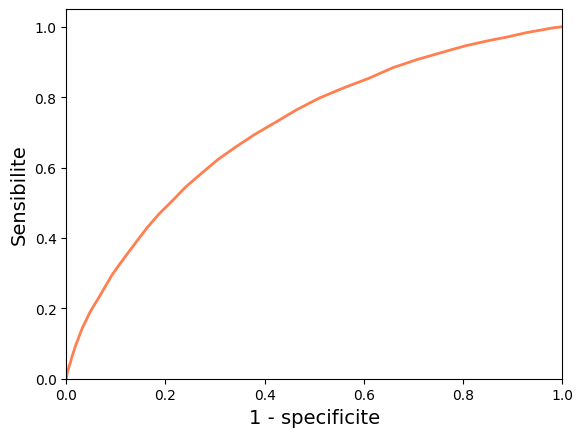

In [81]:
for i in range(5):
    # load model
    print("Loading Random Forest SMOTE")
    clf = joblib.load('models/RFC_SMOTE/RFC_SMOTE_fold_{}.joblib'.format(i))

    y_pred = clf.predict(X_test)
    y_pred_proba = clf.predict_proba(X_test)[:, 1] # we take the prediction for the class 1
    evaluate_classification(y_test, y_pred, y_pred_proba=y_pred_proba)
    results = evaluate_models("RFC_SMOTE_{}".format(i), results, y_test, y_pred)

### 3) Feature Importance

Model chosen : LightGBM 7.
It has a good precision and though the recall is low, its AUC is the best.

In [82]:
import shap

In [83]:
best_model_path = "models/LGBM/LGBMClassifier_fold_{}.joblib".format(7)
best_model = joblib.load(best_model_path)

In [84]:
all_clients_to_predict = pd.read_csv("dataset/cleaned/data_test_preprocessed_vf.csv", index_col="SK_ID_CURR")

#### 1) Model's feature importance

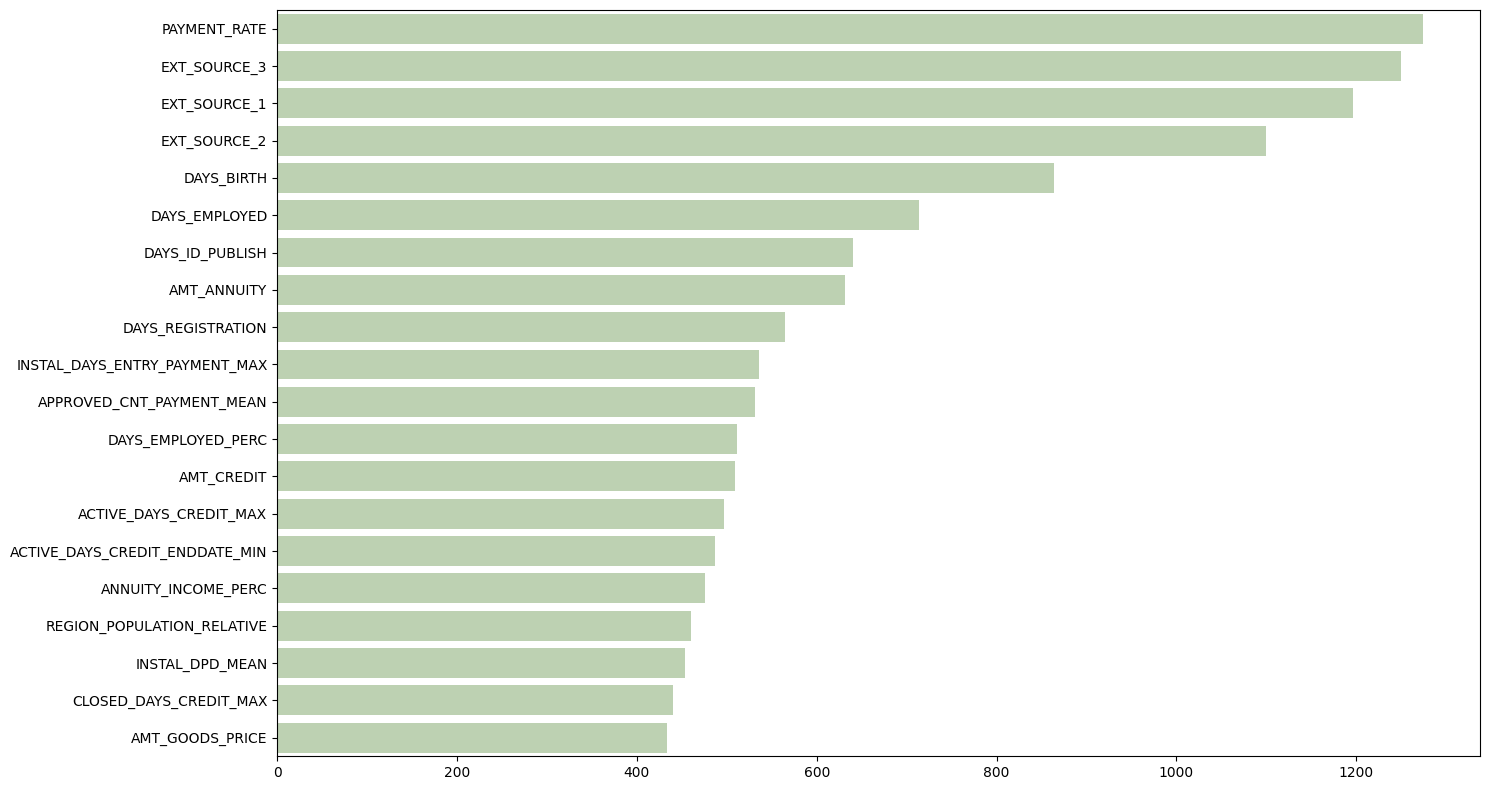

In [99]:
columns = all_clients_to_predict.columns.tolist()
feature_importance_dict = get_feature_importance_model(best_model, columns)
plot_feature_importance(feature_importance_dict)

#### 2) SHAP feature importance

In [86]:
explainer = shap.Explainer(best_model, all_clients_to_predict)

sample_clients = all_clients_to_predict.sample(1000)
shap_values = explainer.shap_values(sample_clients)

100%|===================| 999/1000 [01:48<00:00]        

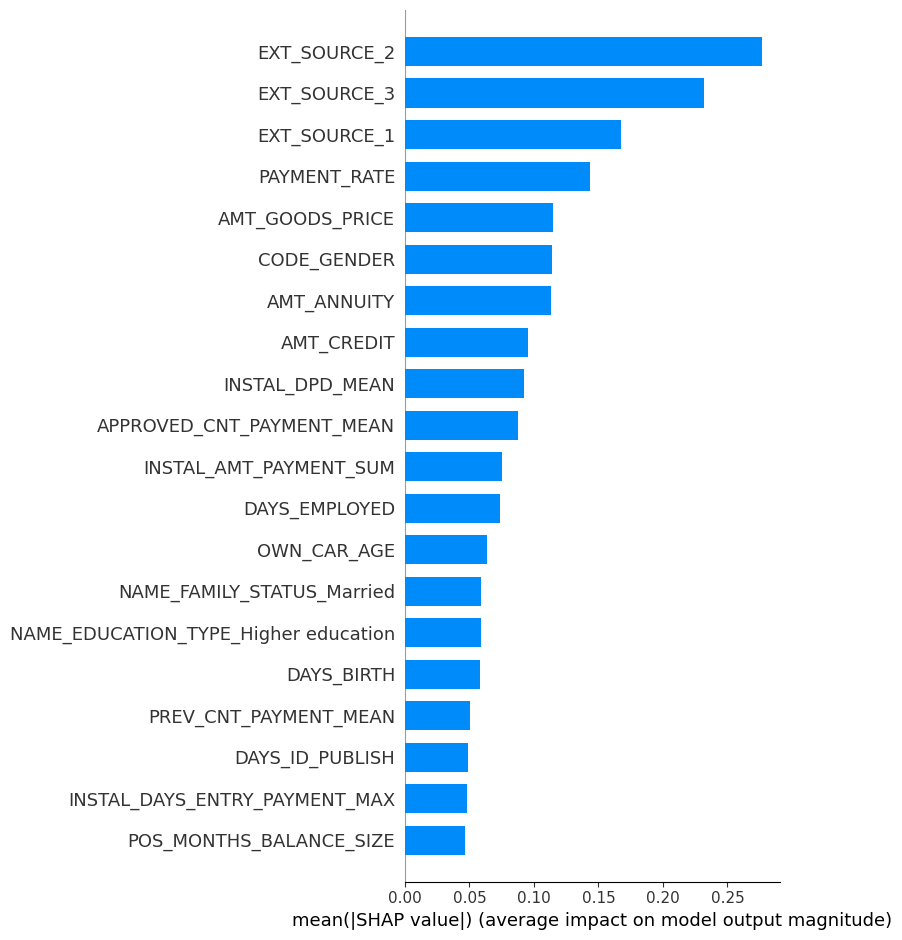

In [93]:
shap.summary_plot(shap_values, sample_clients, plot_type="bar")

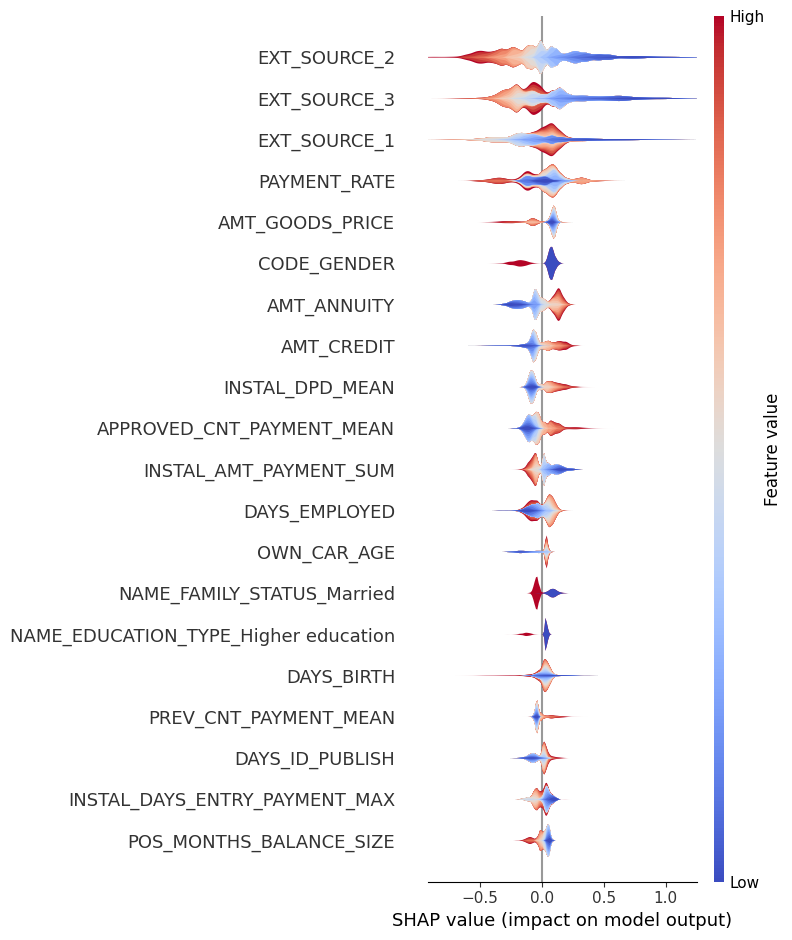

In [91]:
shap.summary_plot(shap_values, sample_clients, plot_type="layered_violin", color='coolwarm')

For the most importance feature


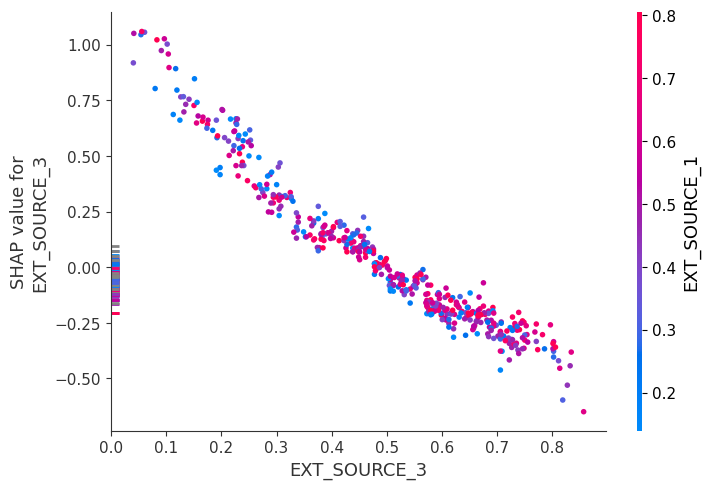

In [95]:
print("For the most importance feature")
shap.dependence_plot("EXT_SOURCE_3", shap_values, sample_clients)

In [96]:
# End of notebook time
t1 = time()
print("computing time : {:8.6f} sec".format(t1 - t0))
print("computing time : " + strftime('%H:%M:%S', gmtime(t1 - t0)))

computing time : 13185.226429 sec
computing time : 03:39:45
